Problem Statement:Here our objective is to build a model which will predict wheather a person is trying to change his/her job or not? 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV


import warnings
warnings.filterwarnings('ignore')
import missingno as msno
%matplotlib inline

In [2]:
train = pd.read_csv('aug_train.csv')
test = pd.read_csv('aug_test.csv')

In [3]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


Before Dig into the main analysing process process Let's get familliar with the datasets.

#Meaning of each individual features.
enrollee_id : Unique ID for candidate

city: City code

city_ development _index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change


In [4]:
train.shape

(19158, 14)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [6]:
train.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


Here one interesting things to notice is all the Numerical features are not contains Null values.

In [7]:
#Let's have a glance on the features.

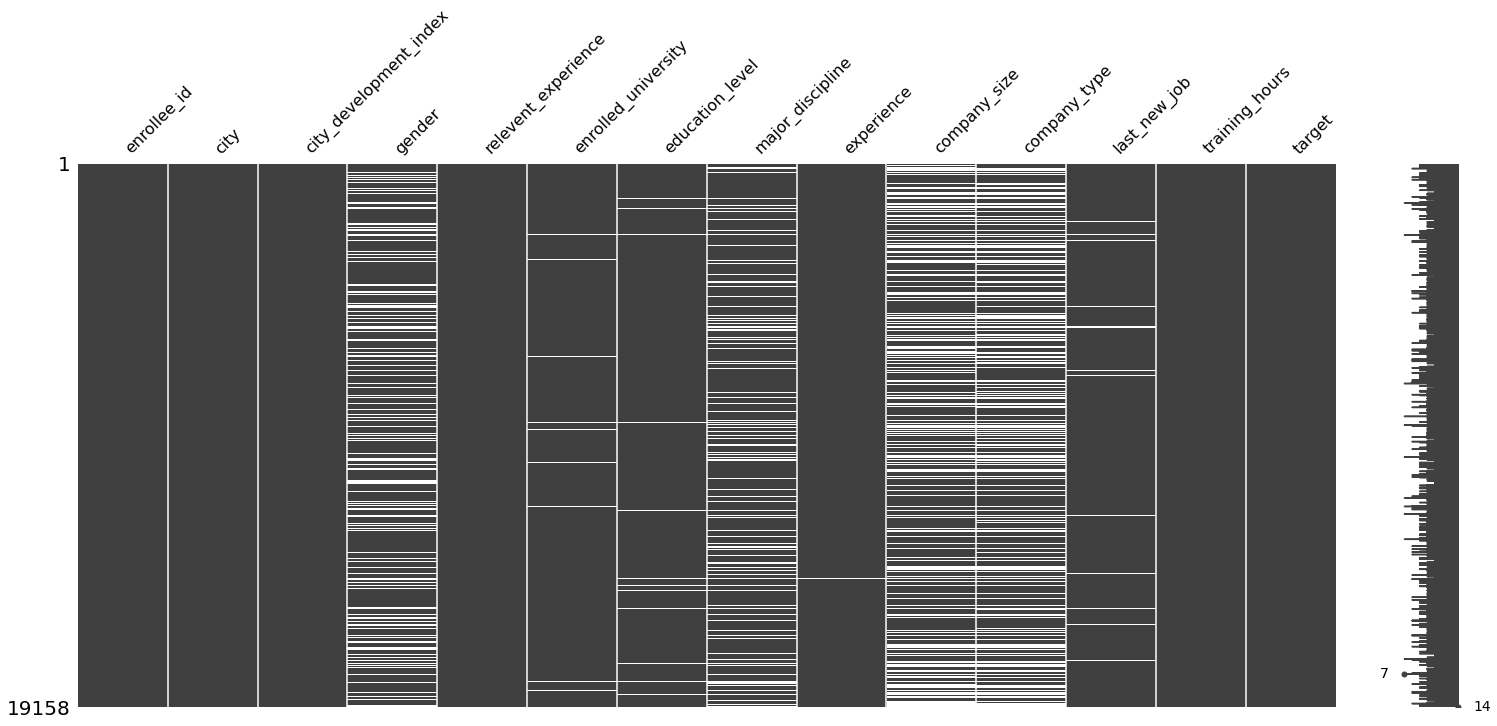

In [8]:
msno.matrix(train)

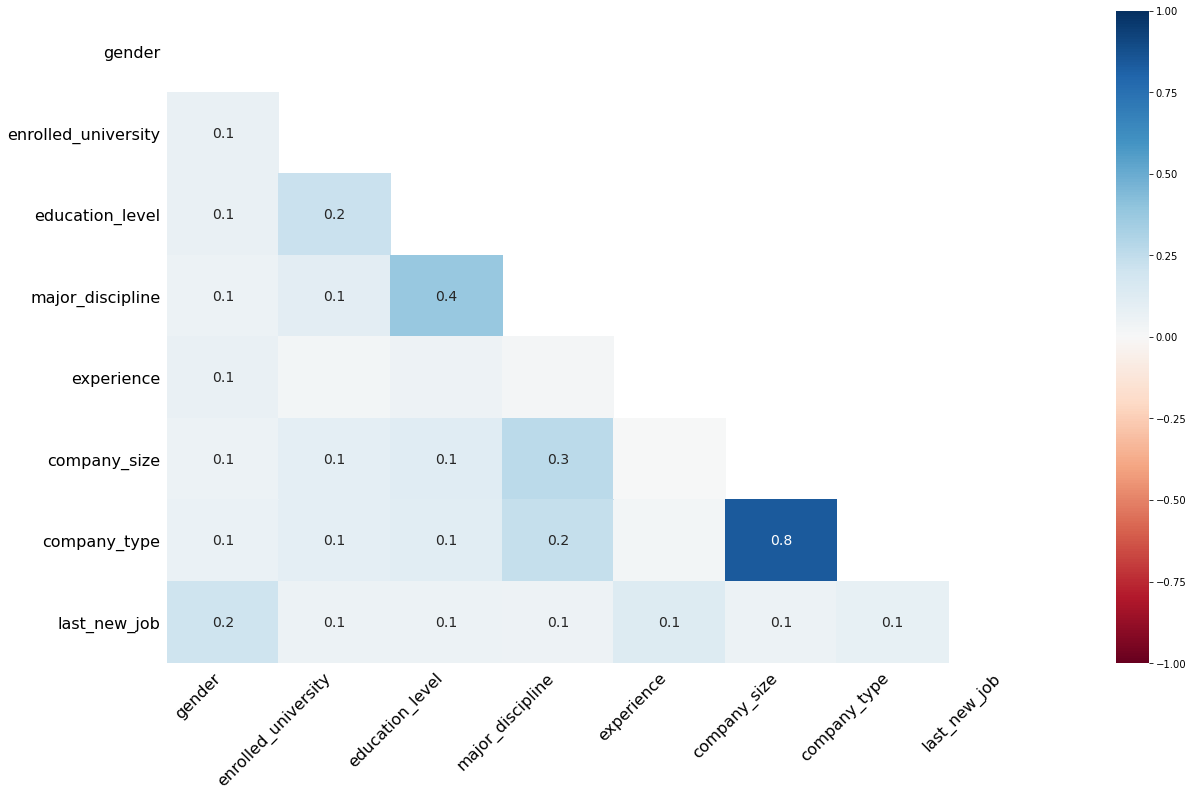

In [9]:
msno.heatmap(train)

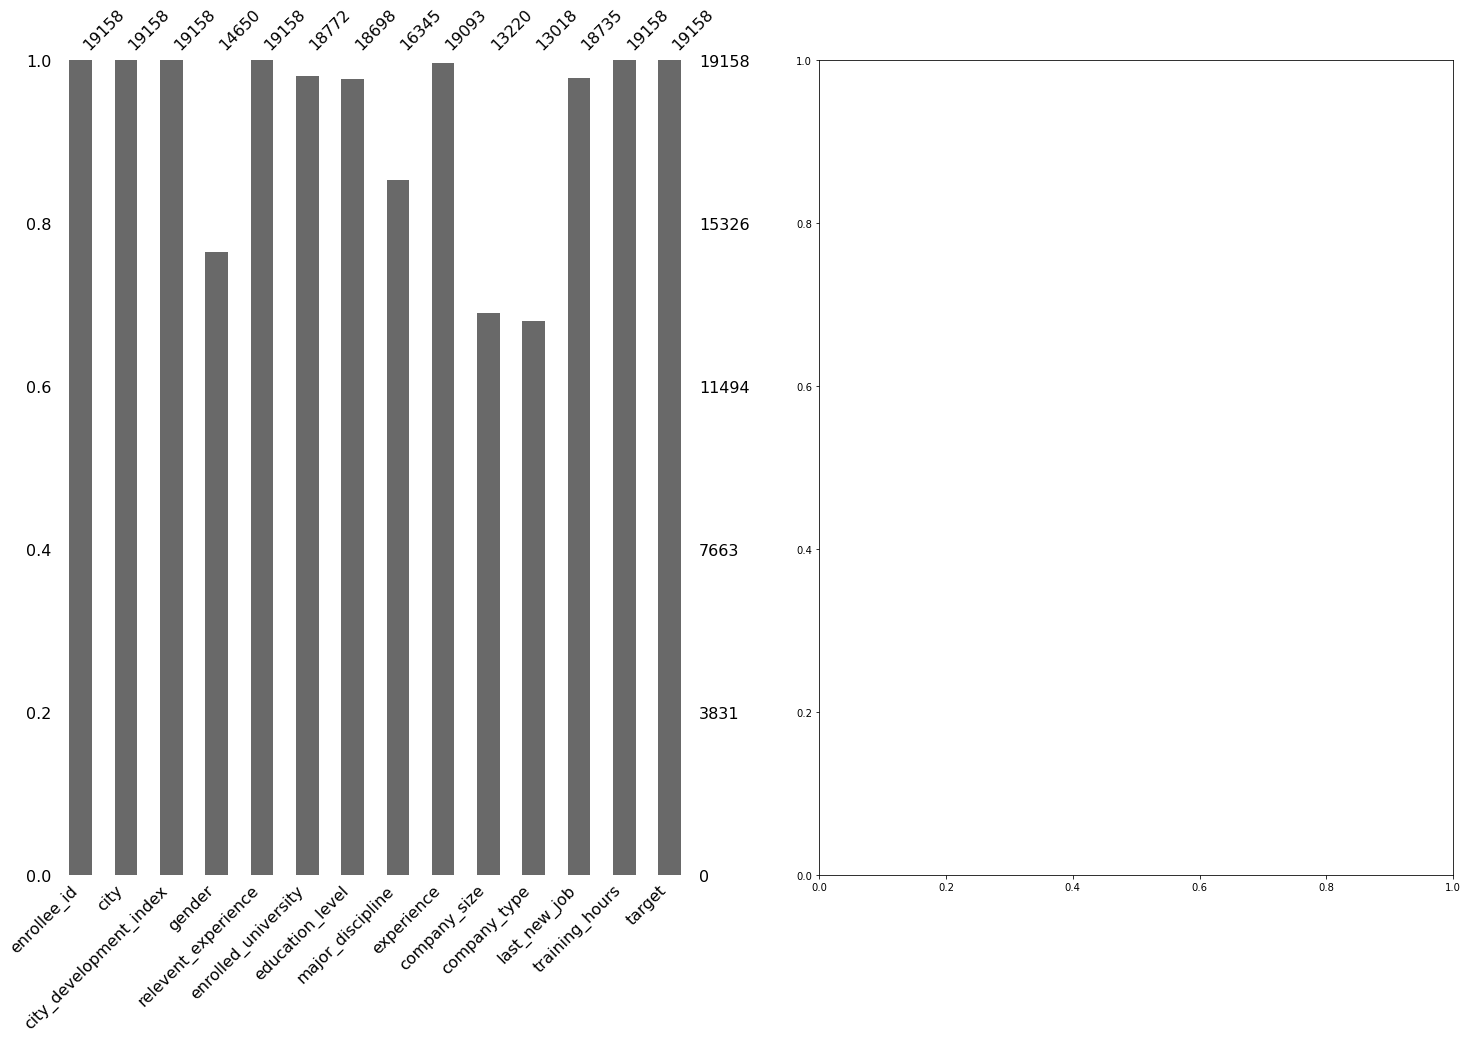

In [10]:
fig, ax = plt.subplots(figsize=(25, 15),nrows=1,ncols = 2)
msno.bar(train,ax=ax[0])

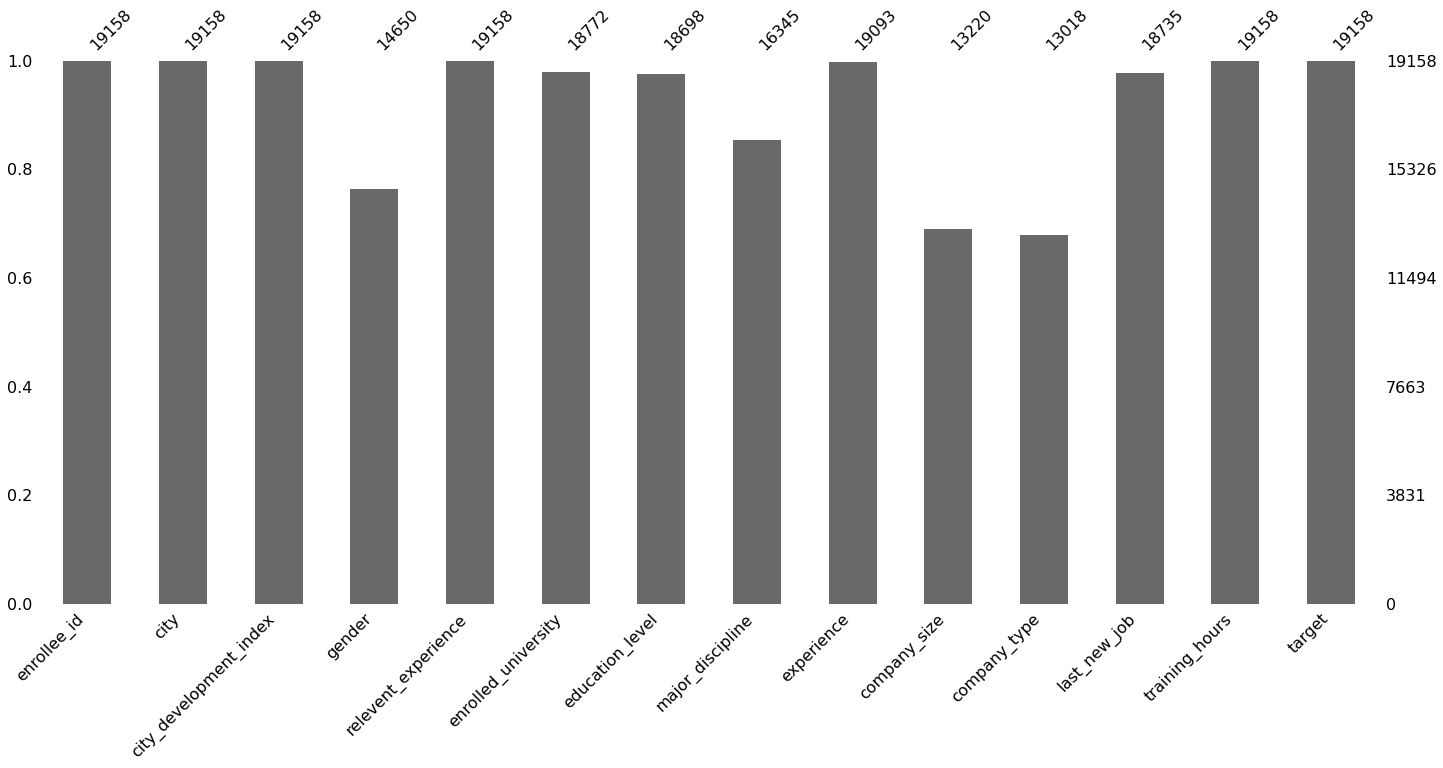

In [11]:
msno.bar(train)

In [12]:
train.isna().mean().round(4) * 100

enrollee_id                0.00
city                       0.00
city_development_index     0.00
gender                    23.53
relevent_experience        0.00
enrolled_university        2.01
education_level            2.40
major_discipline          14.68
experience                 0.34
company_size              30.99
company_type              32.05
last_new_job               2.21
training_hours             0.00
target                     0.00
dtype: float64

In [13]:
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_df = pd.DataFrame({#'column_name': train.columns,
                                 'percent_missing': percent_missing})
percent_missing

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64

In [14]:
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,percent_missing
enrollee_id,0.000000
city,0.000000
city_development_index,0.000000
relevent_experience,0.000000
training_hours,0.000000
target,0.000000
experience,0.339284
enrolled_university,2.014824
last_new_job,2.207955
education_level,2.401086


Here we are seeing that most of the features that contains missing values are categorical 
and we can fill those value by mode , but this could leads to imbalanced data and make our ml model baised
 so it's better to delete those.

In [15]:
train.dropna(inplace=True)
test.dropna(inplace=True)

# Data Cleaning

In [16]:
train.isna().mean()

enrollee_id               0.0
city                      0.0
city_development_index    0.0
gender                    0.0
relevent_experience       0.0
enrolled_university       0.0
education_level           0.0
major_discipline          0.0
experience                0.0
company_size              0.0
company_type              0.0
last_new_job              0.0
training_hours            0.0
target                    0.0
dtype: float64

I don't think enrolle_id, city, company_size will be handy to take in our process.So drop this three columns. 

In [17]:
train.drop(['enrollee_id','city','company_size'], axis = 1, inplace = True)

In [18]:
train['experience'].unique()

array(['15', '>20', '13', '7', '5', '16', '11', '<1', '18', '19', '12',
       '10', '9', '2', '6', '4', '14', '3', '8', '17', '20', '1'],
      dtype=object)

Here we are seeing that there are > and < sign with 20 and 1. So before Modeling let's solve this by adding and Substracting a fraction 
number with 20 and 1 

In [19]:
def replace(experience):
    if experience == '>20':
        return 21
    elif experience == '<1':
        return 0

    else:
        return experience
    


In [20]:
train.experience = train.experience.map(replace)

In [21]:
train['experience'].unique()

array(['15', 21, '13', '7', '5', '16', '11', 0, '18', '19', '12', '10',
       '9', '2', '6', '4', '14', '3', '8', '17', '20', '1'], dtype=object)

In [22]:
def replace(last_new_job):
    if last_new_job == '>4':
        return 5
    elif last_new_job == 'never':
        return 0

    else:
        return last_new_job
    


In [23]:
train.last_new_job = train.last_new_job.map(replace)

In [24]:
train['last_new_job'].unique()

array([5, '4', '1', '3', '2', 0], dtype=object)

In [25]:
#Now let's have look at my data and hope it's clean now
train.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_type,last_new_job,training_hours,target
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,Pvt Ltd,5,47,0.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21,Funded Startup,4,8,0.0
7,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,Pvt Ltd,5,18,1.0
8,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,Pvt Ltd,1,46,1.0
11,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,Pvt Ltd,1,108,0.0


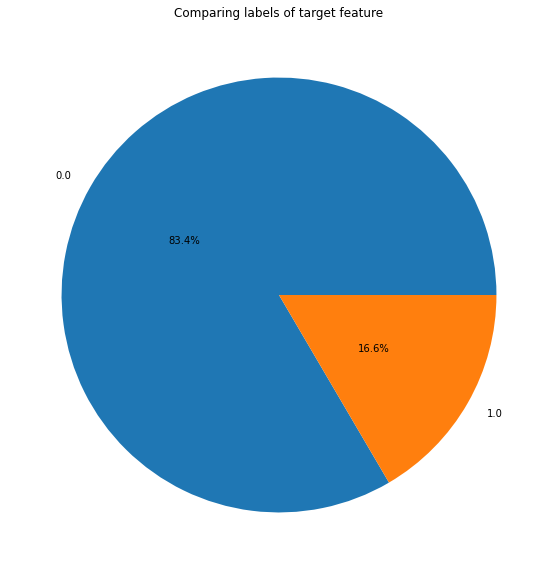

In [26]:
#First Check weather our dataset is balanced or not?
values = train['target'].value_counts().values.tolist()
labels = train['target'].value_counts().index
plt.figure(figsize= (10,10))
plt.title('Comparing labels of target feature')
plt.pie(x = values, labels = labels, autopct='%1.1f%%', pctdistance= .5)
plt.show()


Here we are seeing that our dataset is imbalanced we have to fix this before modeling.  

In [27]:
train['company_type'].unique()

array(['Pvt Ltd', 'Funded Startup', 'Early Stage Startup',
       'Public Sector', 'NGO', 'Other'], dtype=object)

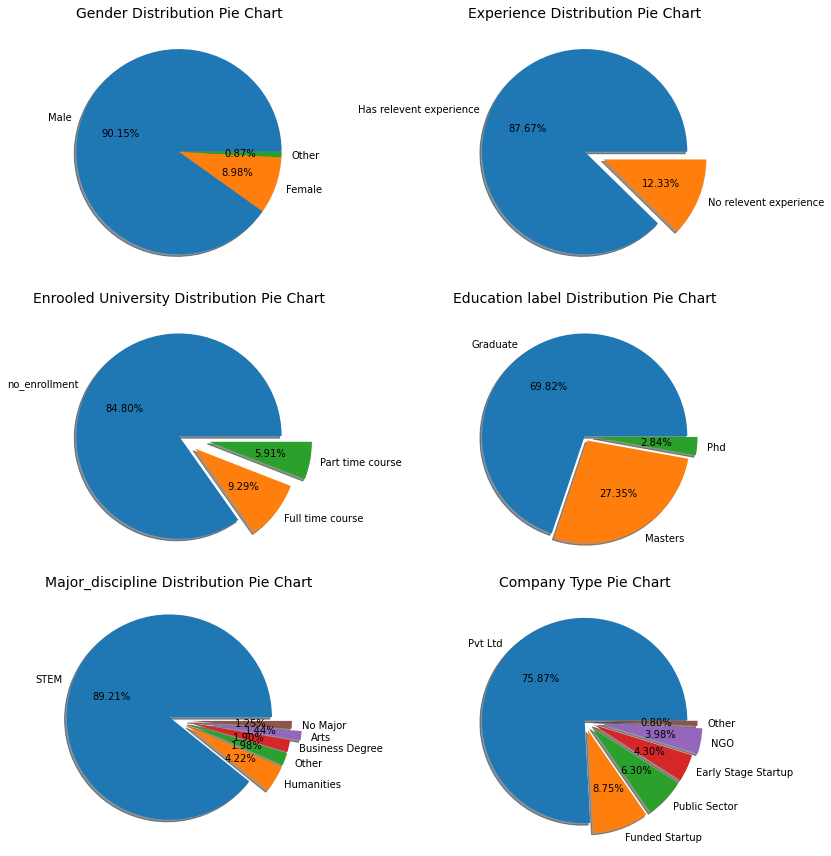

In [28]:

fig, ax = plt.subplots(3,2, figsize = (12,12))
((ax1, ax2), (ax3, ax4), (ax5, ax6)) = ax

labels = train['gender'].value_counts().index
values = train['gender'].value_counts().tolist()
ax1.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True)
ax1.set_title("Gender Distribution Pie Chart", fontdict={'fontsize': 14})

labels = train['relevent_experience'].value_counts().index
values = train['relevent_experience'].value_counts().tolist()
ax2.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True, explode=[0, 0.2])
ax2.set_title("Experience Distribution Pie Chart", fontdict={'fontsize': 14})

labels = train['enrolled_university'].value_counts().index
values = train['enrolled_university'].value_counts().tolist()
ax3.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True, explode=[0, 0.2,.3])
ax3.set_title("Enrooled University Distribution Pie Chart", fontdict={'fontsize': 14})

labels = train['education_level'].value_counts().index
values = train['education_level'].value_counts().tolist()
ax4.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True, explode=[0, 0.05,.1])
ax4.set_title("Education label Distribution Pie Chart", fontdict={'fontsize': 14})

labels = train['major_discipline'].value_counts().index
values = train['major_discipline'].value_counts().tolist()
ax5.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True, explode=[0.1, 0.1, 0.1, 0.1, 0.2, 0.1])
ax5.set_title("Major_discipline Distribution Pie Chart", fontdict={'fontsize': 14})



labels = train['company_type'].value_counts().index
values = train['company_type'].value_counts().tolist()
ax6.pie(x=values, labels=labels, autopct="%1.2f%%", shadow=True, explode=[0, 0.1,.1,.1, .15,.1])
ax6.set_title("Company Type Pie Chart", fontdict={'fontsize': 14})


plt.tight_layout()
plt.show()

Let's Make Some obsevations from the visualizations.

1. Almost 90% people are male who were takong that course.

2. Almost 87% candidate has realvent experience in Data Science and rest of them don't have any
experience but interasted in this field.

3. Almost 85% candidate were enrolled in University.

4. ALmost 70% guy were graduate and interesting is around 3% phd guy also there.

5. It's natural that most of the candidate will be form STEM background. But From rest of the groups
candidates from humanities are interested more.

6. And most of the guys are from private sector.

Let's see how all the categorical features effecting in target variable.

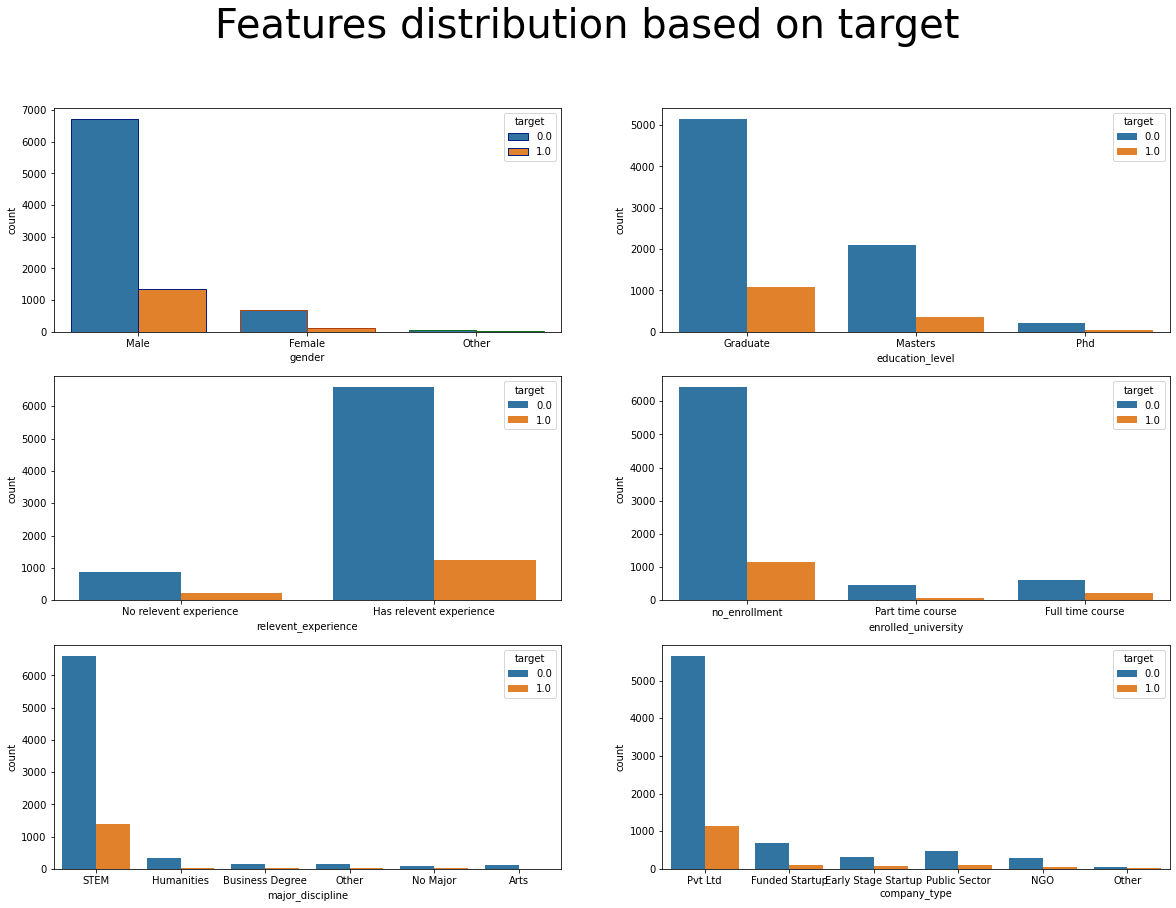

In [29]:
fig_dims = (20, 14)
fig, ax =plt.subplots(3,2,figsize = fig_dims)
sns.countplot(x = train['gender'],hue = train['target'], ax=ax[0,0], edgecolor=sns.color_palette("dark", 60))
sns.countplot(train['education_level'],hue = train['target'], ax=ax[0,1])
sns.countplot(x = train['relevent_experience'],hue = train['target'], ax=ax[1,0])
sns.countplot(train['enrolled_university'],hue = train['target'], ax=ax[1,1])
sns.countplot(x = train['major_discipline'],hue = train['target'], ax=ax[2,0])
sns.countplot(x = train['company_type'],hue = train['target'], ax=ax[2,1])


fig.suptitle('Features distribution based on target ',fontsize=40)
fig.show()


Let's make some observations.

Here we are seeing that in each Chart any one class having majority of the data points.That's why we cann't
compare confidently. So here ratio could be a good factor to compare.

1. Though something to see is even people from public sector are also getting interest in Data Science.

2. Peopler are from Arts background are completly not interested in switching job.


Let's try to explore Numerical coulumns.And have their distribution with respect to target columns.

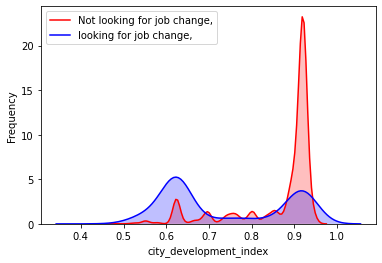

In [30]:
#plt.xticks([0,1])

g = sns.kdeplot(train['city_development_index'][(train["target"] == 0) & (train['city_development_index'].notnull())], color="Red", shade = True)
g = sns.kdeplot(train['city_development_index'][(train["target"] == 1) & (train['city_development_index'].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel('city_development_index')
g.set_ylabel("Frequency")
g = g.legend(["Not looking for job change,","looking for job change,"])

Make Obsebations.

1. Peoples city_development_index ranging in around .666 and and around .9 are interested in changing.

2. Peoples are toatally not interested in job change whose city_development_index are nearly .9

In [31]:
## new City_devlopment_cat feature based on this obserbations.
bins = [0,.45,.67,.84,1]
labels=[0,1,2,3]
train['City_devlopment_cat'] = pd.cut(train['city_development_index'], bins=bins, labels=labels)
train[['City_devlopment_cat', 'target']].groupby(['City_devlopment_cat'], as_index=False).mean().sort_values(by='target', ascending=False)

,City_devlopment_cat,target
1,1,0.563852
0,0,0.250000
2,2,0.116200
3,3,0.084714


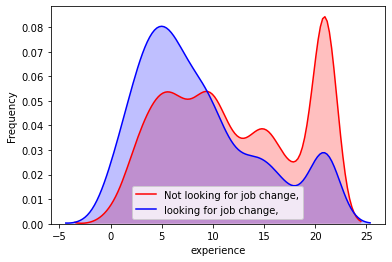

In [32]:
g = sns.kdeplot(train['experience'][(train["target"] == 0) & (train['experience'].notnull())], color="Red", shade = True)
g = sns.kdeplot(train['experience'][(train["target"] == 1) & (train['experience'].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel('experience')
g.set_ylabel("Frequency")
g = g.legend(["Not looking for job change,","looking for job change,"])

Make Obserbations.

1. People ranging  experience from 1 to 10 years are most likely to change.
2. People  having experience of around 20 years are not looking to change the job.

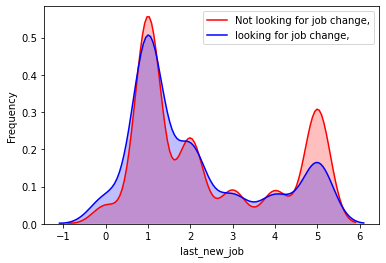

In [33]:
g = sns.kdeplot(train['last_new_job'][(train["target"] == 0) & (train['last_new_job'].notnull())], color="Red", shade = True)
g = sns.kdeplot(train['last_new_job'][(train["target"] == 1) & (train['last_new_job'].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel('last_new_job')
g.set_ylabel("Frequency")
g = g.legend(["Not looking for job change,","looking for job change,"])

make obserbations

1.People left their last job from 1 to 2 years ago are most likely to change job
 and also same for who are not wanted to change job.

In [34]:
train['last_new_job'].astype(int)

1        5
4        4
7        5
8        1
11       1
        ..
19147    1
19149    1
19150    3
19152    1
19155    4
Name: last_new_job, Length: 8955, dtype: int32

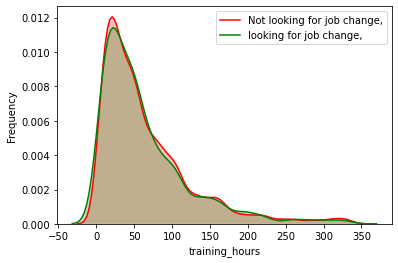

In [35]:
g = sns.kdeplot(train['training_hours'][(train["target"] == 0) & (train['training_hours'].notnull())], color="Red", shade = True)
g = sns.kdeplot(train['training_hours'][(train["target"] == 1) & (train['training_hours'].notnull())], ax =g, color="Green", shade= True)
g.set_xlabel('training_hours')
g.set_ylabel("Frequency")
g = g.legend(["Not looking for job change,","looking for job change,"])

Nothing to much  say about this graph.

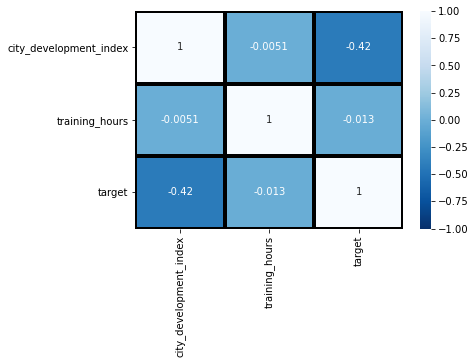

In [36]:
sns.heatmap(train.corr(), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'Blues_r', linewidths=3, linecolor='black')


In the corelation matrix not seeing any good relationship among the numerical features.
So let's see How Categorical features are interrelated among themselves.

In [37]:
train['target'].value_counts()

0.0    7472
1.0    1483
Name: target, dtype: int64

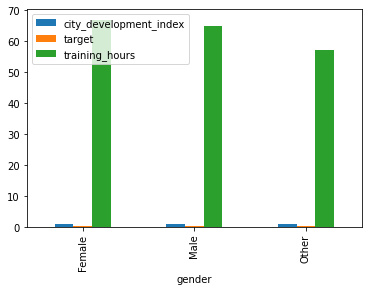

In [38]:
#Let's use pivot table to analyze it.
table = pd.pivot_table(train,index=['gender'])
table
table.plot(kind='bar')

Here one interesting point to notice is Female have a higher training hours then others.

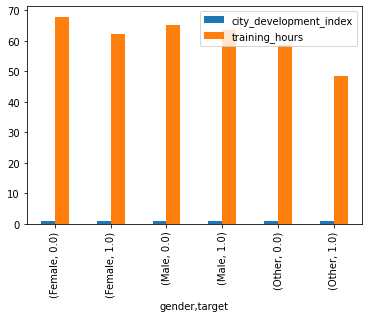

In [39]:
table = pd.pivot_table(train,index=['gender','target'])
table
table.plot(kind='bar')

Obervations:
    
1. Who are wanted to change the job their training hour is less then 
who don't want in all three catrgory.

2. Who are wanted to change the job have less experience then is  then 
who don't want in all three catrgory.
 

                               city_development_index  training_hours
gender target education_level                                        
Female 0.0    Graduate                       0.869034       69.852608
              Masters                        0.872407       64.979381
              Phd                            0.895316       60.605263
       1.0    Graduate                       0.754918       61.858824
              Masters                        0.754810       55.190476
              Phd                            0.919000      145.000000
Male   0.0    Graduate                       0.863611       65.717070
              Masters                        0.867793       63.702444
              Phd                            0.895478       68.532967
       1.0    Graduate                       0.723447       64.371859
              Masters                        0.739337       61.142857
              Phd                            0.893267       63.900000
Other  0.0    Gradua

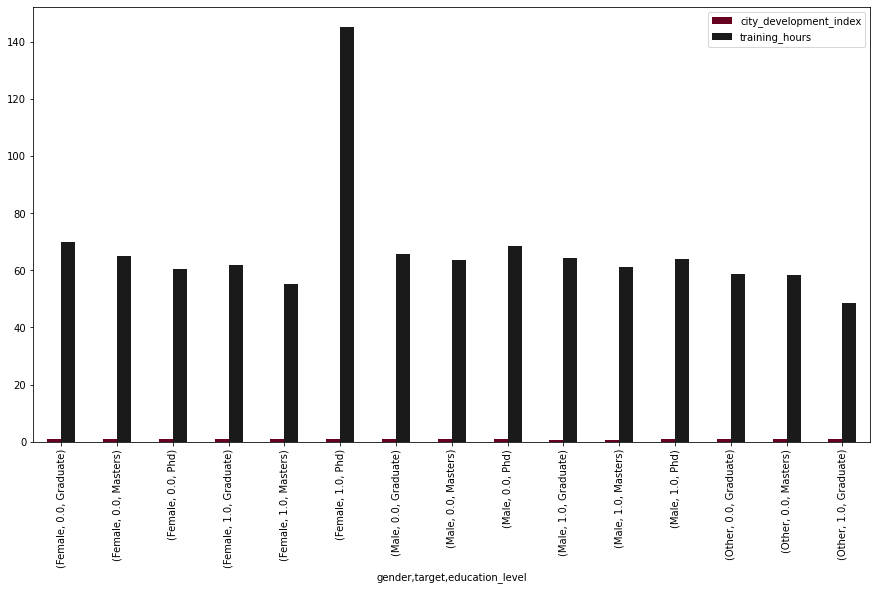

In [40]:
table = pd.pivot_table(train,index=['gender','target','education_level'])
print(table)
table.plot(kind='bar',
           figsize = (15,8),
           colormap = 'RdGy')

Obsevations

1. Female who want to change job have a much more higher training
hours then others and Education_level is PHD and much more experience also.

2. And in Others ccategory only graduate are wanted to change job.

                        target
gender education_level        
Female Graduate           85.0
       Masters            42.0
       Phd                 4.0
Male   Graduate          995.0
       Masters           315.0
       Phd                30.0
Other  Graduate           12.0
       Masters             0.0


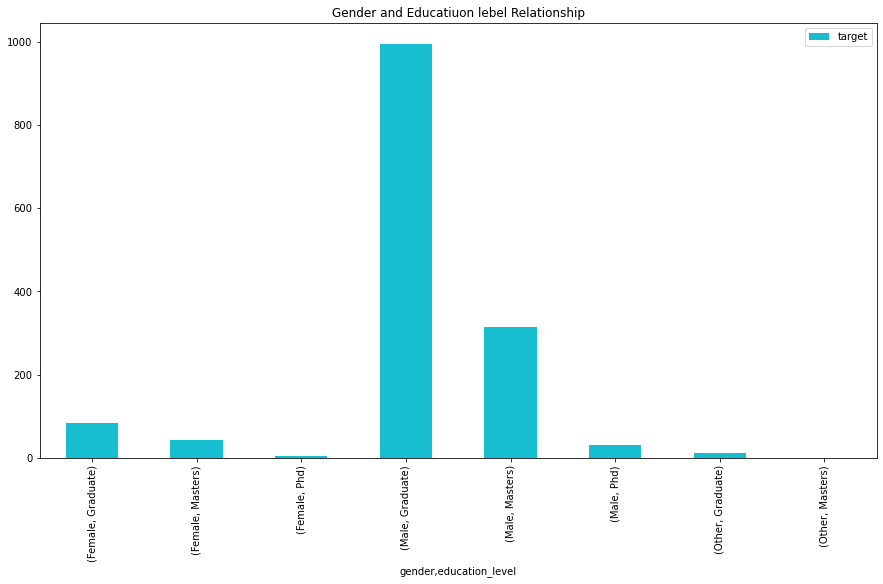

In [41]:
table = pd.pivot_table(train,
                       index=['gender','education_level'],
                       aggfunc={'target':np.sum}
                      )
print(table)
table.plot(kind='bar',
           figsize = (15,8),
           colormap = 'tab10_r',
           title = 'Gender and Educatiuon lebel Relationship')

observations:

1. Female graduate candidates are more in numbers in changing job.

2. Same case for male also as graduate completed students have a intent for a job.

                                            target
gender enrolled_university education_level        
Female Full time course    Graduate           10.0
                           Masters             9.0
                           Phd                 0.0
       Part time course    Graduate            7.0
                           Masters             1.0
       no_enrollment       Graduate           68.0
                           Masters            32.0
                           Phd                 4.0
Male   Full time course    Graduate          157.0
                           Masters            54.0
                           Phd                 2.0
       Part time course    Graduate           57.0
                           Masters            11.0
                           Phd                 1.0
       no_enrollment       Graduate          781.0
                           Masters           250.0
                           Phd                27.0
Other  Full time course    Grad

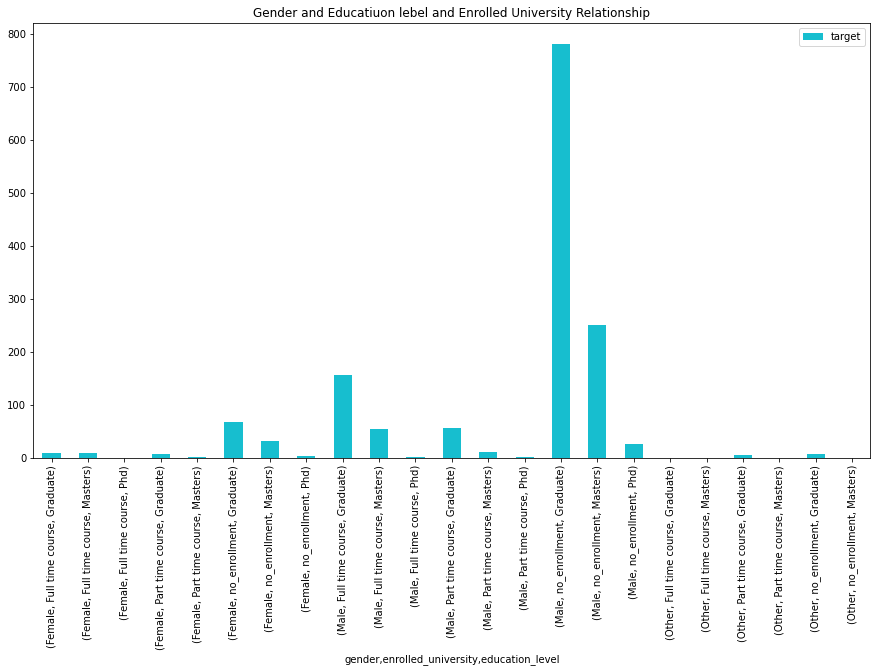

In [42]:
table = pd.pivot_table(train,
                       index=['gender','enrolled_university','education_level'],
                       aggfunc={'target':np.sum}
                      )
print(table)
table.plot(kind='bar',
           figsize = (15,8),
           colormap = 'tab10_r',
           title = 'Gender and Educatiuon lebel and Enrolled University Relationship')

Observations:
    
1. male Graduate candidate having no_enrollment are much more
interested in job then part time and Full time. Same cases for Female also.

2. Tree structure based algorithm could be handy for this particuler case.

                                  target
company_type        last_new_job        
Early Stage Startup 0                7.0
                    5                3.0
                    1               50.0
                    2               13.0
                    3                1.0
                    4                4.0
Funded Startup      0                1.0
                    5                1.0
                    1               69.0
                    2               27.0
                    3                5.0
                    4                5.0
NGO                 0                1.0
                    5               13.0
                    1               31.0
                    2                4.0
                    3                4.0
                    4                2.0
Other               0                2.0
                    5                3.0
                    1                4.0
                    2                3.0
                

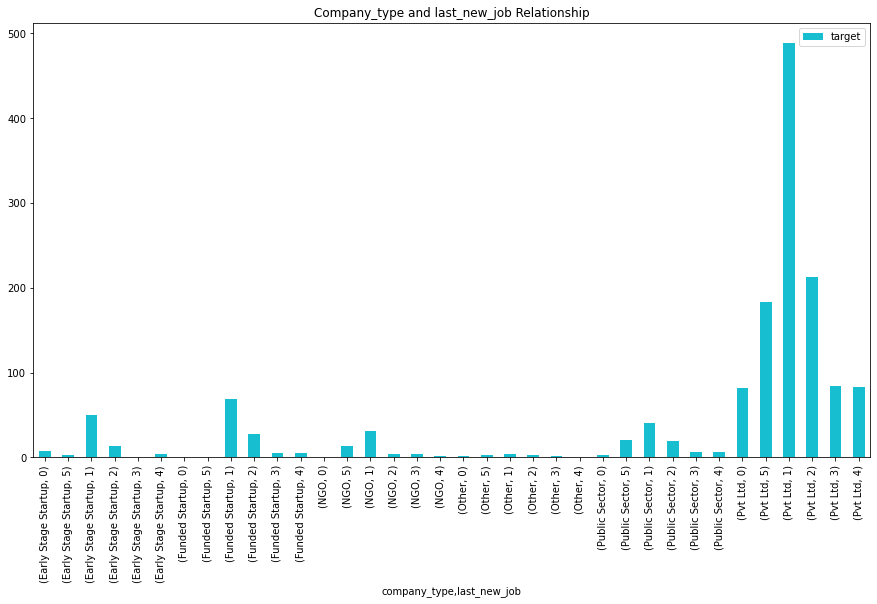

In [43]:
table = pd.pivot_table(train,
                       index=['company_type','last_new_job'],
                       aggfunc={'target':np.sum}
                      )
print(table)
table.plot(kind='bar',
           figsize = (15,8),
           colormap = 'tab10_r',
           title = 'Company_type and last_new_job Relationship')

Observations

1. Working in various types of company but having 1 years experienced candudate are mostly interested 
in changing job.

2. And Candidate Working in NGO and Public Sector having experience of 5 years also partly interested in changing job.

                              target                               
enrolled_university Full time course Part time course no_enrollment
last_new_job                                                       
0                               14.0              2.0          80.0
5                               12.0              7.0         204.0
1                              136.0             47.0         499.0
2                               44.0             11.0         224.0
3                                9.0              9.0          84.0
4                               17.0              6.0          78.0


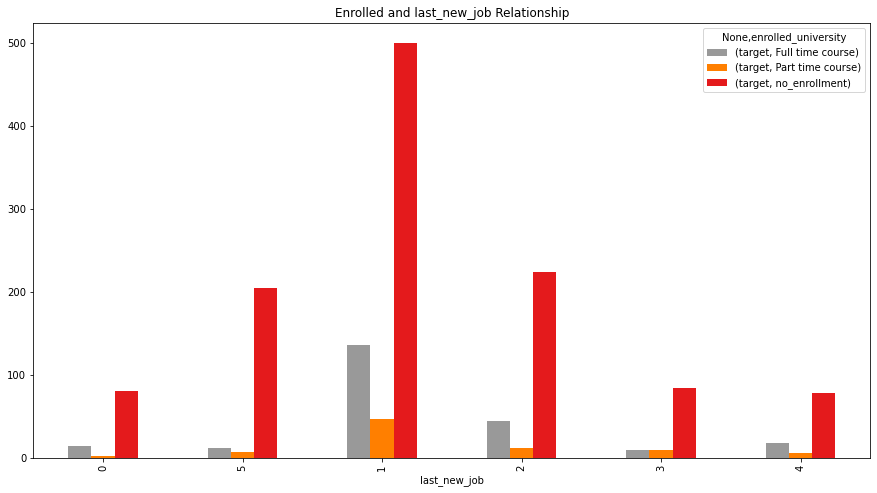

In [44]:
table = pd.pivot_table(train,
                       index=['last_new_job'],
                       columns = ['enrolled_university'],
                       aggfunc={'target':np.sum}
                      )
print(table)
table.plot(kind='bar',
           figsize = (15,8),
           colormap = 'Set1_r',
           title = 'Enrolled and last_new_job Relationship')

Observations
1. Candidate who are enrolled in a part time courese are less interested in changing job.

2. Candidate emrolled in a university and having 1 years experience are mostly interesrted in changing job.

                                  target                               
enrolled_university     Full time course Part time course no_enrollment
major_discipline gender                                                
Arts             Female              0.0              NaN           2.0
                 Male                0.0              0.0           6.0
                 Other               NaN              1.0           0.0
Business Degree  Female              NaN              NaN           2.0
                 Male                1.0              1.0          17.0
                 Other               NaN              NaN           0.0
Humanities       Female              NaN              0.0           8.0
                 Male                1.0              2.0          29.0
                 Other               NaN              NaN           0.0
No Major         Female              NaN              0.0           1.0
                 Male                2.0              2.0       

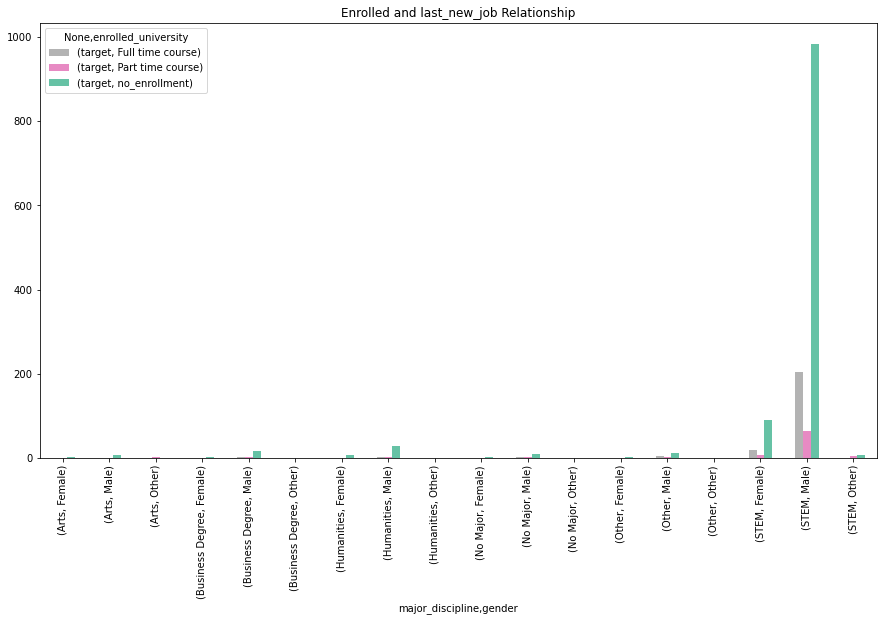

In [45]:
table = pd.pivot_table(train,
                       index=['major_discipline','gender'],
                       columns = ['enrolled_university'],
                       values = ['target'],
                       aggfunc=np.sum
                       
                      )
print(table)
table.plot(kind='bar',
           figsize = (15,8),
           colormap = 'Set2_r',
           title = 'Enrolled and last_new_job Relationship')

# Encoding The columns

In [46]:
train.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_type,last_new_job,training_hours,target,City_devlopment_cat
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,Pvt Ltd,5,47,0.0,2
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21,Funded Startup,4,8,0.0,2
7,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,Pvt Ltd,5,18,1.0,2
8,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,Pvt Ltd,1,46,1.0,3
11,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,Pvt Ltd,1,108,0.0,3


In [47]:
df = train.copy()

In [48]:
df = pd.get_dummies(df,
                    columns=['gender', 'relevent_experience', 'enrolled_university', 'major_discipline', 'company_type'],
                    drop_first=True)

As education_level is an ordinal categorical features that's why we have to map the each lavel with
keeping order in mind.

In [49]:
df['education_level'] = df['education_level'].map( {'Graduate': 0, 'Masters': 1,'Phd': 2} ).astype(int)


In [50]:
df.head()

,city_development_index,education_level,experience,last_new_job,training_hours,target,City_devlopment_cat,gender_Male,gender_Other,relevent_experience_No relevent experience,...,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
1,0.776,0,15,5,47,0.0,2,1,0,1,...,0,0,0,0,1,0,0,0,0,1
4,0.767,1,21,4,8,0.0,2,1,0,0,...,0,0,0,0,1,1,0,0,0,0
7,0.762,0,13,5,18,1.0,2,1,0,0,...,0,0,0,0,1,0,0,0,0,1
8,0.920,0,7,1,46,1.0,3,1,0,0,...,0,0,0,0,1,0,0,0,0,1
11,0.920,0,5,1,108,0.0,3,1,0,0,...,0,0,0,0,1,0,0,0,0,1


In [51]:
X = df.drop(['target'], axis=1)
y = df['target']

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

In [54]:
from sklearn.preprocessing import StandardScaler
ScalerX = StandardScaler()
X_train = ScalerX.fit_transform(X_train)
X_test = ScalerX.transform(X_test)

# Handling imbalance data using SMOTE based techniques

### A) SMOTE Technique

In [55]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0.0: 5961, 1.0: 1203})
After Counter({0.0: 5961, 1.0: 5961})


### B) ADASYN Technique

In [56]:
from imblearn.over_sampling import ADASYN

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)


Before Counter({0.0: 5961, 1.0: 1203})
After Counter({1.0: 5979, 0.0: 5961})


## C) Hybrid Techniques

### C.1) SMOTE + Tomek Links

In [57]:
from imblearn.combine import SMOTETomek

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)


Before Counter({0.0: 5961, 1.0: 1203})
After Counter({0.0: 5733, 1.0: 5733})


### C.2) SMOTE + ENN

In [58]:
from imblearn.combine import SMOTEENN

counter = Counter(y_train)
print('Before',counter)
#oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0.0: 5961, 1.0: 1203})
After Counter({1.0: 4332, 0.0: 3645})


### C.3) SMOTE + Under Sampling

In [59]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
sm = SMOTE(sampling_strategy = .3)
rus =  RandomUnderSampler(sampling_strategy=.4)

pipeline = Pipeline(steps = [('smote', sm),('under',rus)])

counter = Counter(y_train)
print('Before',counter)
#over and undersampling the train dataset using SMOTE + RandomUnderSampler
X_train_smrus, y_train_smrus = pipeline.fit_resample(X_train, y_train)

counter = Counter(y_train_smrus)
print('After',counter)

Before Counter({0.0: 5961, 1.0: 1203})
After Counter({0.0: 4470, 1.0: 1788})


# Model Building

In [60]:
model = list()
resample = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()

In [61]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    resample.append(sampling)


# Model-1: Logistic Regression

### 1. Original Unsampled Data

In [62]:
log_model=LogisticRegression()

params={'C':np.logspace( -10, 1, 15),'class_weight':[None,'balanced'],'penalty':['l1','l2']}

cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# Create grid search using 5-fold cross validation
clf_LR = GridSearchCV(log_model, params, cv=cv, scoring='roc_auc', n_jobs=-1)
clf_LR.fit(X_train, y_train)
clf_LR.best_estimator_

LogisticRegression(C=0.26826957952797276, class_weight='balanced')

In [63]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'actual')

Confusion Matrix
[[1183  328]
 [ 114  166]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84      1511
         1.0       0.34      0.59      0.43       280

    accuracy                           0.75      1791
   macro avg       0.62      0.69      0.64      1791
weighted avg       0.82      0.75      0.78      1791
 

AUC-ROC
0.7371513661718824


### 2.SMOTE Resampling

In [64]:
clf_LR.fit(X_train_sm, y_train_sm)
clf_LR.best_estimator_

LogisticRegression(C=0.04393970560760786, class_weight='balanced')

In [65]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote')

Confusion Matrix
[[1192  319]
 [ 111  169]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.79      0.85      1511
         1.0       0.35      0.60      0.44       280

    accuracy                           0.76      1791
   macro avg       0.63      0.70      0.64      1791
weighted avg       0.83      0.76      0.78      1791
 

AUC-ROC
0.7399120733667391


### 3.ADASYN Resampling

In [66]:
clf_LR.fit(X_train_ada, y_train_ada)
clf_LR.best_estimator_

LogisticRegression(C=0.26826957952797276)

In [67]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'adasyn')

Confusion Matrix
[[1147  364]
 [ 105  175]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.92      0.76      0.83      1511
         1.0       0.32      0.62      0.43       280

    accuracy                           0.74      1791
   macro avg       0.62      0.69      0.63      1791
weighted avg       0.82      0.74      0.77      1791
 

AUC-ROC
0.7379762692634962


### 4.SMOTE + Tomek Resampling

In [68]:
clf_LR.fit(X_train_smtom, y_train_smtom)
clf_LR.best_estimator_

LogisticRegression(C=10.0)

In [69]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote+tomek')

Confusion Matrix
[[1197  314]
 [ 111  169]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85      1511
         1.0       0.35      0.60      0.44       280

    accuracy                           0.76      1791
   macro avg       0.63      0.70      0.65      1791
weighted avg       0.83      0.76      0.79      1791
 

AUC-ROC
0.7407275219816583


### 5.SMOTE + ENN Resampling

In [70]:
clf_LR.fit(X_train_smenn, y_train_smenn)
clf_LR.best_estimator_

LogisticRegression(C=1.6378937069540613)

In [71]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote+enn')

Confusion Matrix
[[1144  367]
 [ 104  176]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.92      0.76      0.83      1511
         1.0       0.32      0.63      0.43       280

    accuracy                           0.74      1791
   macro avg       0.62      0.69      0.63      1791
weighted avg       0.82      0.74      0.77      1791
 

AUC-ROC
0.7384206296681479


### 6. SMOTE + Under Sampling

In [72]:
clf_LR.fit(X_train_smrus, y_train_smrus)
clf_LR.best_estimator_

LogisticRegression(C=0.26826957952797276, class_weight='balanced')

In [73]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote+rus')

Confusion Matrix
[[1177  334]
 [ 110  170]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84      1511
         1.0       0.34      0.61      0.43       280

    accuracy                           0.75      1791
   macro avg       0.63      0.69      0.64      1791
weighted avg       0.82      0.75      0.78      1791
 

AUC-ROC
0.7387089912073366


# Model-2: Decision Tree

In [74]:
estimators = [2,10,30,50,100]
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]
#Impurity
criterion = ['gini', 'entropy']
#The number of features to consider when looking for the best split
max_features = ['log2', 'sqrt', 'auto']


### 1. Original Unsampled Data

In [75]:
tree_model = DecisionTreeClassifier()
tree_param_grid = { 
    'max_features':max_features,
    'criterion':criterion,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

clf_DT = RandomizedSearchCV(tree_model, tree_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
clf_DT.fit(X_train, y_train)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished


DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='auto',
                       min_samples_split=100)

In [76]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'actual')

Confusion Matrix
[[1414   97]
 [ 169  111]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91      1511
         1.0       0.53      0.40      0.45       280

    accuracy                           0.85      1791
   macro avg       0.71      0.67      0.68      1791
weighted avg       0.84      0.85      0.84      1791
 

AUC-ROC
0.7305308688664082


### 2.SMOTE Resampling

In [77]:
clf_DT.fit(X_train_sm, y_train_sm)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished


DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='log2',
                       min_samples_leaf=5, min_samples_split=20)

In [78]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote')

Confusion Matrix
[[1286  225]
 [ 148  132]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87      1511
         1.0       0.37      0.47      0.41       280

    accuracy                           0.79      1791
   macro avg       0.63      0.66      0.64      1791
weighted avg       0.81      0.79      0.80      1791
 

AUC-ROC
0.7066405880684504


### 3.ADASYN Resampling

In [79]:
clf_DT.fit(X_train_ada, y_train_ada)
clf_DT.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished


DecisionTreeClassifier(max_depth=15, max_features='log2', min_samples_split=5)

In [80]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'adasyn')

Confusion Matrix
[[1206  305]
 [ 136  144]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.80      0.85      1511
         1.0       0.32      0.51      0.40       280

    accuracy                           0.75      1791
   macro avg       0.61      0.66      0.62      1791
weighted avg       0.81      0.75      0.78      1791
 

AUC-ROC
0.6489458258485393


### 4. SMOTE + Tomek Resampling

In [81]:
clf_DT.fit(X_train_smtom, y_train_smtom)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished


DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='log2',
                       min_samples_leaf=2, min_samples_split=20)

In [82]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote+tomek')

Confusion Matrix
[[1274  237]
 [ 135  145]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      1511
         1.0       0.38      0.52      0.44       280

    accuracy                           0.79      1791
   macro avg       0.64      0.68      0.66      1791
weighted avg       0.82      0.79      0.80      1791
 

AUC-ROC
0.7168301503261795


### 5.SMOTE + ENN Resampling

In [83]:
clf_DT.fit(X_train_smenn, y_train_smenn)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


DecisionTreeClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=15)

In [84]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote+enn')

Confusion Matrix
[[1240  271]
 [ 130  150]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.82      0.86      1511
         1.0       0.36      0.54      0.43       280

    accuracy                           0.78      1791
   macro avg       0.63      0.68      0.64      1791
weighted avg       0.82      0.78      0.79      1791
 

AUC-ROC
0.705944502221802


### 6. SMOTE + Under Sampling

In [85]:
clf_DT.fit(X_train_smrus, y_train_smrus)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished


DecisionTreeClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=100)

In [86]:
test_eval(clf_LR, X_test, y_test, 'Decision Tree', 'smote+rus')

Confusion Matrix
[[1177  334]
 [ 110  170]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84      1511
         1.0       0.34      0.61      0.43       280

    accuracy                           0.75      1791
   macro avg       0.63      0.69      0.64      1791
weighted avg       0.82      0.75      0.78      1791
 

AUC-ROC
0.7387089912073366


# Model-3: Random Forest

### 1. Original Unsampled Data

In [87]:
rf_model = RandomForestClassifier()

rf_params={'n_estimators':estimators,
           'max_features':max_features,
           'criterion':criterion,
           'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf}

clf_RF = RandomizedSearchCV(rf_model, rf_params, cv=cv, scoring='roc_auc', n_jobs=-1, n_iter=20, verbose=2)
clf_RF.fit(X_train, y_train)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s finished


RandomForestClassifier(max_depth=9, max_features='log2', min_samples_split=15,
                       n_estimators=30)

In [88]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'actual')

Confusion Matrix
[[1404  107]
 [ 146  134]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      1511
         1.0       0.56      0.48      0.51       280

    accuracy                           0.86      1791
   macro avg       0.73      0.70      0.72      1791
weighted avg       0.85      0.86      0.85      1791
 

AUC-ROC
0.7346258390848066


### 2.SMOTE Resampling

In [89]:
clf_RF.fit(X_train_sm, y_train_sm)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.6s finished


RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_split=5)

In [90]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote')

Confusion Matrix
[[1382  129]
 [ 142  138]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      1511
         1.0       0.52      0.49      0.50       280

    accuracy                           0.85      1791
   macro avg       0.71      0.70      0.71      1791
weighted avg       0.85      0.85      0.85      1791
 

AUC-ROC
0.7138118086413916


### 3.ADASYN Resampling

In [91]:
clf_RF.fit(X_train_ada, y_train_ada)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.7s finished


RandomForestClassifier(criterion='entropy', max_depth=13, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=30)

In [92]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'adasyn')

Confusion Matrix
[[1368  143]
 [ 137  143]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      1511
         1.0       0.50      0.51      0.51       280

    accuracy                           0.84      1791
   macro avg       0.70      0.71      0.71      1791
weighted avg       0.85      0.84      0.84      1791
 

AUC-ROC
0.715950883993571


### 4. SMOTE + Tomek Resampling

In [93]:
clf_RF.fit(X_train_smtom, y_train_smtom)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.1s finished


RandomForestClassifier(max_depth=15, max_features='log2', min_samples_split=5,
                       n_estimators=50)

In [94]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote+tomek')

Confusion Matrix
[[1382  129]
 [ 140  140]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      1511
         1.0       0.52      0.50      0.51       280

    accuracy                           0.85      1791
   macro avg       0.71      0.71      0.71      1791
weighted avg       0.85      0.85      0.85      1791
 

AUC-ROC
0.7141509879928145


### 5. SMOTE + ENN Resampling

In [95]:
clf_RF.fit(X_train_smenn, y_train_smenn)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.6s finished


RandomForestClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=30)

In [96]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote+enn')

Confusion Matrix
[[1330  181]
 [ 131  149]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90      1511
         1.0       0.45      0.53      0.49       280

    accuracy                           0.83      1791
   macro avg       0.68      0.71      0.69      1791
weighted avg       0.84      0.83      0.83      1791
 

AUC-ROC
0.7248144558948663


### 6. SMOTE + Under Sampling

In [97]:
clf_RF.fit(X_train_smrus, y_train_smrus)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.3s finished


RandomForestClassifier(max_depth=13, max_features='log2', min_samples_leaf=5,
                       min_samples_split=20, n_estimators=50)

In [98]:
test_eval(clf_LR, X_test, y_test, 'Random Forest', 'smote+rus')

Confusion Matrix
[[1177  334]
 [ 110  170]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84      1511
         1.0       0.34      0.61      0.43       280

    accuracy                           0.75      1791
   macro avg       0.63      0.69      0.64      1791
weighted avg       0.82      0.75      0.78      1791
 

AUC-ROC
0.7387089912073366


# Model-4: AdaBoast

In [99]:
from sklearn.ensemble import AdaBoostClassifier
clf_ada=AdaBoostClassifier()
clf_ada.fit(X_train, y_train)
#Actual data
test_eval(clf_ada, X_test, y_test, 'AdaBoast', 'actual')

Confusion Matrix
[[1406  105]
 [ 156  124]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      1511
         1.0       0.54      0.44      0.49       280

    accuracy                           0.85      1791
   macro avg       0.72      0.69      0.70      1791
weighted avg       0.84      0.85      0.85      1791
 

AUC-ROC
0.736308735936466


In [100]:
#smote
clf_ada.fit(X_train_sm, y_train_sm)
test_eval(clf_ada, X_test, y_test, 'AdaBoast', 'Smote')

#Adasyn
clf_ada.fit(X_train_ada, y_train_ada)
test_eval(clf_ada, X_test, y_test, 'AdaBoast', 'adasyn')

#smote + tomek
clf_ada.fit(X_train_smtom, y_train_smtom)
test_eval(clf_ada, X_test, y_test, 'AdaBoast', 'smote+tomek')

#smote + enn
clf_ada.fit(X_train_smenn, y_train_smenn)
test_eval(clf_ada, X_test, y_test, 'AdaBoast', 'smote+enn')

#smote + 
clf_ada.fit(X_train_smrus, y_train_smrus)
test_eval(clf_ada, X_test, y_test, 'AdaBoast', 'smote+rus')




Confusion Matrix
[[1358  153]
 [ 139  141]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90      1511
         1.0       0.48      0.50      0.49       280

    accuracy                           0.84      1791
   macro avg       0.69      0.70      0.70      1791
weighted avg       0.84      0.84      0.84      1791
 

AUC-ROC
0.7106599224732911
Confusion Matrix
[[1317  194]
 [ 131  149]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89      1511
         1.0       0.43      0.53      0.48       280

    accuracy                           0.82      1791
   macro avg       0.67      0.70      0.68      1791
weighted avg       0.84      0.82      0.83      1791
 

AUC-ROC
0.7137160820648577
Confusion Matrix
[[1365  146]
 [ 137  143]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      

# Model-5: GradientBoast¶

In [101]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier()

gb_params = { 
    "n_estimators":[1,3,5,10,15,20,30,40,50,],
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

clf_gb=RandomizedSearchCV(gb_model,gb_params,cv=cv, scoring='roc_auc',n_jobs=1)

clf_gb.fit(X_train, y_train)
clf_gb.best_estimator_




GradientBoostingClassifier(learning_rate=0.05, max_depth=5,
                           min_samples_split=100, n_estimators=50)

In [102]:
#Actual data
#clf_gb.fit(X_train, y_train)
#clf_gb.best_estimator_
test_eval(clf_gb, X_test, y_test, 'GradientBoast', 'actual')
#smote
clf_gb.fit(X_train_sm, y_train_sm)
clf_gb.best_estimator_
test_eval(clf_gb, X_test, y_test, 'GradientBoast', 'Smote')

#Adasyn
clf_gb.fit(X_train_ada, y_train_ada)
clf_gb.best_estimator_
test_eval(clf_gb, X_test, y_test, 'GradientBoast', 'adasyn')

#smote + tomek
clf_gb.fit(X_train_smtom, y_train_smtom)
clf_gb.best_estimator_
test_eval(clf_gb, X_test, y_test, 'GradientBoast', 'smote+tomek')

#smote + enn
clf_gb.fit(X_train_smenn, y_train_smenn)
clf_gb.best_estimator_
test_eval(clf_gb, X_test, y_test, 'GradientBoast', 'smote+enn')

#smote + rus
clf_gb.fit(X_train_smrus, y_train_smrus)
clf_gb.best_estimator_
test_eval(clf_gb, X_test, y_test, 'GradientBoast', 'smote+rus')


Confusion Matrix
[[1408  103]
 [ 151  129]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      1511
         1.0       0.56      0.46      0.50       280

    accuracy                           0.86      1791
   macro avg       0.73      0.70      0.71      1791
weighted avg       0.85      0.86      0.85      1791
 

AUC-ROC
0.7388838990261889
Confusion Matrix
[[1370  141]
 [ 160  120]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      1511
         1.0       0.46      0.43      0.44       280

    accuracy                           0.83      1791
   macro avg       0.68      0.67      0.67      1791
weighted avg       0.83      0.83      0.83      1791
 

AUC-ROC
0.7048631464498439
Confusion Matrix
[[1374  137]
 [ 153  127]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      

# Model-6: SGDClassifier

In [107]:
from sklearn.linear_model import SGDClassifier
sgd_params = {
    "loss" : [ "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

sgd_model = SGDClassifier()
clf_sgd=RandomizedSearchCV(sgd_model,sgd_params,cv=cv, scoring='roc_auc',n_jobs=1)

clf_sgd.fit(X_train, y_train)
clf_sgd.best_estimator_


SGDClassifier(alpha=0.01, loss='log', penalty='none')

In [108]:
#Actual data
#clf_gb.fit(X_train, y_train)
#clf_gb.best_estimator_
test_eval(clf_sgd, X_test, y_test, 'SGDClassifier', 'actual')
#smote
clf_sgd.fit(X_train_sm, y_train_sm)
clf_sgd.best_estimator_
test_eval(clf_sgd, X_test, y_test, 'SGDClassifier', 'Smote')

#Adasyn
clf_sgd.fit(X_train_ada, y_train_ada)
clf_sgd.best_estimator_
test_eval(clf_sgd, X_test, y_test, 'SGDClassifier', 'adasyn')

#smote + tomek
clf_sgd.fit(X_train_smtom, y_train_smtom)
clf_sgd.best_estimator_
test_eval(clf_sgd, X_test, y_test, 'SGDClassifier', 'smote+tomek')

#smote + enn
clf_sgd.fit(X_train_smenn, y_train_smenn)
clf_sgd.best_estimator_
test_eval(clf_sgd, X_test, y_test, 'SGDClassifier', 'smote+enn')

#smote + rus
clf_sgd.fit(X_train_smrus, y_train_smrus)
clf_sgd.best_estimator_
test_eval(clf_sgd, X_test, y_test, 'SGDClassifier', 'smote+rus')


Confusion Matrix
[[1416   95]
 [ 184   96]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91      1511
         1.0       0.50      0.34      0.41       280

    accuracy                           0.84      1791
   macro avg       0.69      0.64      0.66      1791
weighted avg       0.83      0.84      0.83      1791
 

AUC-ROC
0.7363855535596104
Confusion Matrix
[[1146  365]
 [ 108  172]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.76      0.83      1511
         1.0       0.32      0.61      0.42       280

    accuracy                           0.74      1791
   macro avg       0.62      0.69      0.62      1791
weighted avg       0.82      0.74      0.77      1791
 

AUC-ROC
0.7327101257445401
Confusion Matrix
[[1111  400]
 [ 103  177]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.92      

# Model-7: LGBMClassifier

In [109]:
import lightgbm as lgbm

In [110]:

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

lgb_model = lgbm.LGBMClassifier()
lgb_params ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 200), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'bagging_fraction': sp_uniform(0.5, 0.8),
             #'bagging_frequency': sp_randint(5, 8),
             'feature_fraction': sp_uniform(0.5, 0.8),
             'max_depth': sp_randint(10, 13),
             'min_data_in_leaf': sp_randint(50, 80),}
#clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
clf_lgb=RandomizedSearchCV(lgb_model,lgb_params,cv=cv, scoring='roc_auc',n_jobs=1)

clf_lgb.fit(X_train, y_train)
clf_lgb.best_estimator_


[LightGBM] [Warning] feature_fraction is set=0.7805813031635698, colsample_bytree=0.6572131264211502 will be ignored. Current value: feature_fraction=0.7805813031635698
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=185 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_fraction is set=0.7940750195397659, subsample=0.8963204569280647 will be ignored. Current value: bagging_fraction=0.7940750195397659
[LightGBM] [Warning] feature_fraction is set=0.7805813031635698, colsample_bytree=0.6572131264211502 will be ignored. Current value: feature_fraction=0.7805813031635698
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=185 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] bagging_fraction is set=0.7940750195397659, subsample=0.8963204569280647 will be ignored. Current value: bagging_fraction=0.7940750195397659
[LightGBM] [Warning] feature_fraction is set=0.7805813031635698, colsample_bytree=0.65721312

[LightGBM] [Warning] feature_fraction is set=0.8438673759911388, colsample_bytree=0.8438040290543123 will be ignored. Current value: feature_fraction=0.8438673759911388
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=146 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] bagging_fraction is set=0.7546127369345594, subsample=0.5608180756272341 will be ignored. Current value: bagging_fraction=0.7546127369345594
[LightGBM] [Warning] feature_fraction is set=0.8438673759911388, colsample_bytree=0.8438040290543123 will be ignored. Current value: feature_fraction=0.8438673759911388
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=146 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] bagging_fraction is set=0.7546127369345594, subsample=0.5608180756272341 will be ignored. Current value: bagging_fraction=0.7546127369345594
[LightGBM] [Warning] feature_fraction is set=0.8438673759911388, colsample_bytree=0.84380402

LGBMClassifier(bagging_fraction=0.7940750195397659,
               colsample_bytree=0.6572131264211502,
               feature_fraction=0.7805813031635698, max_depth=10,
               min_child_samples=185, min_data_in_leaf=54, num_leaves=6,
               reg_alpha=50, reg_lambda=10, subsample=0.8963204569280647)

In [111]:
#Actual data
#clf_gb.fit(X_train, y_train)
#clf_gb.best_estimator_
test_eval(clf_lgb, X_test, y_test, 'LGBMClassifier', 'actual')
#smote
clf_lgb.fit(X_train_sm, y_train_sm)
clf_lgb.best_estimator_
test_eval(clf_lgb, X_test, y_test, 'LGBMClassifier', 'Smote')

#Adasyn
clf_lgb.fit(X_train_ada, y_train_ada)
clf_lgb.best_estimator_
test_eval(clf_lgb, X_test, y_test, 'LGBMClassifier', 'adasyn')

#smote + tomek
clf_lgb.fit(X_train_smtom, y_train_smtom)
clf_lgb.best_estimator_
test_eval(clf_lgb, X_test, y_test, 'LGBMClassifier', 'smote+tomek')

#smote + enn
clf_lgb.fit(X_train_smenn, y_train_smenn)
clf_lgb.best_estimator_
test_eval(clf_lgb, X_test, y_test, 'LGBMClassifier', 'smote+enn')

#smote + rus
clf_lgb.fit(X_train_smrus, y_train_smrus)
clf_lgb.best_estimator_
test_eval(clf_lgb, X_test, y_test, 'LGBMClassifier', 'smote+rus')


Confusion Matrix
[[1405  106]
 [ 146  134]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      1511
         1.0       0.56      0.48      0.52       280

    accuracy                           0.86      1791
   macro avg       0.73      0.70      0.72      1791
weighted avg       0.85      0.86      0.85      1791
 

AUC-ROC
0.7357651035265198
[LightGBM] [Warning] feature_fraction is set=0.9994849099374683, colsample_bytree=0.6998117646646645 will be ignored. Current value: feature_fraction=0.9994849099374683
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=188 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] bagging_fraction is set=0.5027206670135635, subsample=0.6911804381825493 will be ignored. Current value: bagging_fraction=0.5027206670135635
[LightGBM] [Warning] feature_fraction is set=0.9994849099374683, colsample_bytree=0.6998117646646645 will be ignored. Curr

[LightGBM] [Warning] feature_fraction is set=0.9264051761574135, colsample_bytree=0.5898826042356589 will be ignored. Current value: feature_fraction=0.9264051761574135
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=167 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] bagging_fraction is set=0.7565150275812416, subsample=0.6332668836478771 will be ignored. Current value: bagging_fraction=0.7565150275812416
[LightGBM] [Warning] feature_fraction is set=0.9264051761574135, colsample_bytree=0.5898826042356589 will be ignored. Current value: feature_fraction=0.9264051761574135
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=167 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] bagging_fraction is set=0.7565150275812416, subsample=0.6332668836478771 will be ignored. Current value: bagging_fraction=0.7565150275812416
[LightGBM] [Warning] feature_fraction is set=0.9264051761574135, colsample_bytree=0.58988260

[LightGBM] [Warning] feature_fraction is set=0.6961918678582726, colsample_bytree=0.7268711614826022 will be ignored. Current value: feature_fraction=0.6961918678582726
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=130 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] bagging_fraction is set=0.7819303519522008, subsample=0.239026112724339 will be ignored. Current value: bagging_fraction=0.7819303519522008
[LightGBM] [Warning] feature_fraction is set=0.6961918678582726, colsample_bytree=0.7268711614826022 will be ignored. Current value: feature_fraction=0.6961918678582726
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=130 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] bagging_fraction is set=0.7819303519522008, subsample=0.239026112724339 will be ignored. Current value: bagging_fraction=0.7819303519522008
[LightGBM] [Warning] feature_fraction is set=0.6961918678582726, colsample_bytree=0.7268711614

[LightGBM] [Warning] feature_fraction is set=0.5363530383860285, colsample_bytree=0.8819218551283929 will be ignored. Current value: feature_fraction=0.5363530383860285
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=159 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] bagging_fraction is set=1.0584539946842342, subsample=0.9858165112961821 will be ignored. Current value: bagging_fraction=1.0584539946842342
[LightGBM] [Warning] feature_fraction is set=0.5363530383860285, colsample_bytree=0.8819218551283929 will be ignored. Current value: feature_fraction=0.5363530383860285
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=159 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] bagging_fraction is set=1.0584539946842342, subsample=0.9858165112961821 will be ignored. Current value: bagging_fraction=1.0584539946842342
[LightGBM] [Warning] feature_fraction is set=0.5363530383860285, colsample_bytree=0.88192185

[LightGBM] [Warning] feature_fraction is set=0.7597585487571776, colsample_bytree=0.9883040925168873 will be ignored. Current value: feature_fraction=0.7597585487571776
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=178 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] bagging_fraction is set=0.7673291066705643, subsample=0.44001709315549786 will be ignored. Current value: bagging_fraction=0.7673291066705643
[LightGBM] [Warning] feature_fraction is set=0.7597585487571776, colsample_bytree=0.9883040925168873 will be ignored. Current value: feature_fraction=0.7597585487571776
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=178 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] bagging_fraction is set=0.7673291066705643, subsample=0.44001709315549786 will be ignored. Current value: bagging_fraction=0.7673291066705643
[LightGBM] [Warning] feature_fraction is set=0.7597585487571776, colsample_bytree=0.988304

Confusion Matrix
[[1342  169]
 [ 135  145]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      1511
         1.0       0.46      0.52      0.49       280

    accuracy                           0.83      1791
   macro avg       0.69      0.70      0.69      1791
weighted avg       0.84      0.83      0.83      1791
 

AUC-ROC
0.7220182944124044
[LightGBM] [Warning] feature_fraction is set=1.193375684525802, colsample_bytree=0.47969841192437934 will be ignored. Current value: feature_fraction=1.193375684525802
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=168 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] bagging_fraction is set=0.7053863263093578, subsample=0.3357571974943328 will be ignored. Current value: bagging_fraction=0.7053863263093578
[LightGBM] [Warning] feature_fraction is set=1.193375684525802, colsample_bytree=0.47969841192437934 will be ignored. Curre

[LightGBM] [Warning] feature_fraction is set=0.5128946725521362, colsample_bytree=0.8888302581763374 will be ignored. Current value: feature_fraction=0.5128946725521362
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=178 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] bagging_fraction is set=0.6372532919968548, subsample=0.3327405463772573 will be ignored. Current value: bagging_fraction=0.6372532919968548
[LightGBM] [Warning] feature_fraction is set=0.5128946725521362, colsample_bytree=0.8888302581763374 will be ignored. Current value: feature_fraction=0.5128946725521362
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=178 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] bagging_fraction is set=0.6372532919968548, subsample=0.3327405463772573 will be ignored. Current value: bagging_fraction=0.6372532919968548
[LightGBM] [Warning] feature_fraction is set=0.5128946725521362, colsample_bytree=0.88883025

[LightGBM] [Warning] feature_fraction is set=0.744928369302104, colsample_bytree=0.8133296031739203 will be ignored. Current value: feature_fraction=0.744928369302104
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=199 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] bagging_fraction is set=0.9170752822151911, subsample=0.5244512666084189 will be ignored. Current value: bagging_fraction=0.9170752822151911
[LightGBM] [Warning] feature_fraction is set=0.744928369302104, colsample_bytree=0.8133296031739203 will be ignored. Current value: feature_fraction=0.744928369302104
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=199 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] bagging_fraction is set=0.9170752822151911, subsample=0.5244512666084189 will be ignored. Current value: bagging_fraction=0.9170752822151911
[LightGBM] [Warning] feature_fraction is set=0.744928369302104, colsample_bytree=0.8133296031739

[LightGBM] [Warning] feature_fraction is set=0.8602492780149036, colsample_bytree=0.7623072784024101 will be ignored. Current value: feature_fraction=0.8602492780149036
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=196 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] bagging_fraction is set=0.7287385048939131, subsample=0.40392620941481855 will be ignored. Current value: bagging_fraction=0.7287385048939131
[LightGBM] [Warning] feature_fraction is set=0.8602492780149036, colsample_bytree=0.7623072784024101 will be ignored. Current value: feature_fraction=0.8602492780149036
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=196 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] bagging_fraction is set=0.7287385048939131, subsample=0.40392620941481855 will be ignored. Current value: bagging_fraction=0.7287385048939131
[LightGBM] [Warning] feature_fraction is set=0.8602492780149036, colsample_bytree=0.762307

[LightGBM] [Warning] feature_fraction is set=0.9492662498696927, colsample_bytree=0.789014972014689 will be ignored. Current value: feature_fraction=0.9492662498696927
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=173 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] bagging_fraction is set=0.7355472165864375, subsample=0.2234595571849389 will be ignored. Current value: bagging_fraction=0.7355472165864375
[LightGBM] [Warning] feature_fraction is set=0.9492662498696927, colsample_bytree=0.789014972014689 will be ignored. Current value: feature_fraction=0.9492662498696927
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=173 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] bagging_fraction is set=0.7355472165864375, subsample=0.2234595571849389 will be ignored. Current value: bagging_fraction=0.7355472165864375
[LightGBM] [Warning] feature_fraction is set=0.9492662498696927, colsample_bytree=0.7890149720

[LightGBM] [Warning] feature_fraction is set=0.5844831581993953, colsample_bytree=0.7579129123478946 will be ignored. Current value: feature_fraction=0.5844831581993953
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=174 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_fraction is set=1.1624818508523012, subsample=0.33421697052365984 will be ignored. Current value: bagging_fraction=1.1624818508523012
[LightGBM] [Warning] feature_fraction is set=0.5844831581993953, colsample_bytree=0.7579129123478946 will be ignored. Current value: feature_fraction=0.5844831581993953
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=174 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_fraction is set=1.1624818508523012, subsample=0.33421697052365984 will be ignored. Current value: bagging_fraction=1.1624818508523012
[LightGBM] [Warning] feature_fraction is set=0.5844831581993953, colsample_bytree=0.757912

[LightGBM] [Warning] feature_fraction is set=1.1992628553940978, colsample_bytree=0.6335452371339044 will be ignored. Current value: feature_fraction=1.1992628553940978
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=119 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] bagging_fraction is set=0.9792705308422983, subsample=0.8165068022931705 will be ignored. Current value: bagging_fraction=0.9792705308422983
[LightGBM] [Warning] feature_fraction is set=1.1992628553940978, colsample_bytree=0.6335452371339044 will be ignored. Current value: feature_fraction=1.1992628553940978
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=119 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] bagging_fraction is set=0.9792705308422983, subsample=0.8165068022931705 will be ignored. Current value: bagging_fraction=0.9792705308422983
[LightGBM] [Warning] feature_fraction is set=0.6491275645200146, colsample_bytree=0.57168783

Confusion Matrix
[[1391  120]
 [ 139  141]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91      1511
         1.0       0.54      0.50      0.52       280

    accuracy                           0.86      1791
   macro avg       0.72      0.71      0.72      1791
weighted avg       0.85      0.86      0.85      1791
 

AUC-ROC
0.738809445022218


# Model-8: MLPClassifier

In [112]:
from sklearn.neural_network import MLPClassifier
clf_mlp  = MLPClassifier()
clf_mlp.fit(X_train, y_train)


MLPClassifier()

In [113]:
#Actual data
#clf_gb.fit(X_train, y_train)
#clf_gb.best_estimator_
test_eval(clf_mlp, X_test, y_test, 'MLPClassifier', 'actual')
#smote
clf_mlp.fit(X_train_sm, y_train_sm)
#clf_mlp.best_estimator_
test_eval(clf_mlp, X_test, y_test, 'MLPClassifier', 'Smote')

#Adasyn
clf_mlp.fit(X_train_ada, y_train_ada)
#clf_mlp.best_estimator_
test_eval(clf_mlp, X_test, y_test, 'MLPClassifier', 'adasyn')

#smote + tomek
clf_mlp.fit(X_train_smtom, y_train_smtom)
#clf_mlp.best_estimator_
test_eval(clf_mlp, X_test, y_test, 'MLPClassifier', 'smote+tomek')

#smote + enn
clf_mlp.fit(X_train_smenn, y_train_smenn)
#clf_mlp.best_estimator_
test_eval(clf_mlp, X_test, y_test, 'MLPClassifier', 'smote+enn')

#smote + rus
clf_mlp.fit(X_train_smrus, y_train_smrus)
#clf_mlp.best_estimator_
test_eval(clf_mlp, X_test, y_test, 'MLPClassifier', 'smote+rus')


Confusion Matrix
[[1414   97]
 [ 164  116]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92      1511
         1.0       0.54      0.41      0.47       280

    accuracy                           0.85      1791
   macro avg       0.72      0.68      0.69      1791
weighted avg       0.84      0.85      0.85      1791
 

AUC-ROC
0.7249078188522264
Confusion Matrix
[[1265  246]
 [ 136  144]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      1511
         1.0       0.37      0.51      0.43       280

    accuracy                           0.79      1791
   macro avg       0.64      0.68      0.65      1791
weighted avg       0.82      0.79      0.80      1791
 

AUC-ROC
0.7087501181809587
Confusion Matrix
[[1210  301]
 [ 130  150]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      

# Model-8: CatBoostClassifier

In [114]:
from catboost import CatBoostClassifier
cb_model = CatBoostClassifier()

cb_params = {'depth':[3,1,2,6,4,5],
          'iterations':[150,100,50],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,80]
          #'ctr_border_count':[50,5,10,20,100,200]
            }
          #'thread_count':4}

clf_cb=RandomizedSearchCV(cb_model,cb_params,cv=cv, scoring='roc_auc',n_jobs=1)
clf_cb.fit(X_train, y_train)
clf_cb.best_estimator_

0:	learn: 0.6923548	total: 329ms	remaining: 49s
1:	learn: 0.6915481	total: 336ms	remaining: 24.9s
2:	learn: 0.6907578	total: 343ms	remaining: 16.8s
3:	learn: 0.6899535	total: 350ms	remaining: 12.8s
4:	learn: 0.6891549	total: 356ms	remaining: 10.3s
5:	learn: 0.6883660	total: 363ms	remaining: 8.71s
6:	learn: 0.6875754	total: 369ms	remaining: 7.54s
7:	learn: 0.6867832	total: 376ms	remaining: 6.68s
8:	learn: 0.6859982	total: 382ms	remaining: 5.99s
9:	learn: 0.6852142	total: 389ms	remaining: 5.44s
10:	learn: 0.6844419	total: 394ms	remaining: 4.98s
11:	learn: 0.6836569	total: 401ms	remaining: 4.61s
12:	learn: 0.6828805	total: 407ms	remaining: 4.29s
13:	learn: 0.6821005	total: 414ms	remaining: 4.02s
14:	learn: 0.6813178	total: 420ms	remaining: 3.78s
15:	learn: 0.6805540	total: 426ms	remaining: 3.57s
16:	learn: 0.6797824	total: 432ms	remaining: 3.38s
17:	learn: 0.6790051	total: 439ms	remaining: 3.22s
18:	learn: 0.6782268	total: 445ms	remaining: 3.06s
19:	learn: 0.6774615	total: 451ms	remaining

26:	learn: 0.6720533	total: 184ms	remaining: 840ms
27:	learn: 0.6713061	total: 191ms	remaining: 832ms
28:	learn: 0.6705544	total: 198ms	remaining: 824ms
29:	learn: 0.6698034	total: 204ms	remaining: 817ms
30:	learn: 0.6690538	total: 212ms	remaining: 815ms
31:	learn: 0.6683123	total: 218ms	remaining: 806ms
32:	learn: 0.6675626	total: 226ms	remaining: 802ms
33:	learn: 0.6668221	total: 234ms	remaining: 800ms
34:	learn: 0.6660761	total: 243ms	remaining: 797ms
35:	learn: 0.6653373	total: 250ms	remaining: 793ms
36:	learn: 0.6646056	total: 257ms	remaining: 785ms
37:	learn: 0.6638616	total: 264ms	remaining: 777ms
38:	learn: 0.6631316	total: 271ms	remaining: 770ms
39:	learn: 0.6623954	total: 277ms	remaining: 762ms
40:	learn: 0.6616608	total: 284ms	remaining: 756ms
41:	learn: 0.6609221	total: 292ms	remaining: 751ms
42:	learn: 0.6601992	total: 299ms	remaining: 744ms
43:	learn: 0.6594739	total: 306ms	remaining: 736ms
44:	learn: 0.6587505	total: 313ms	remaining: 729ms
45:	learn: 0.6580309	total: 319

58:	learn: 0.6485847	total: 358ms	remaining: 551ms
59:	learn: 0.6478877	total: 365ms	remaining: 548ms
60:	learn: 0.6471751	total: 373ms	remaining: 544ms
61:	learn: 0.6464802	total: 380ms	remaining: 539ms
62:	learn: 0.6457907	total: 387ms	remaining: 534ms
63:	learn: 0.6450939	total: 394ms	remaining: 530ms
64:	learn: 0.6443892	total: 400ms	remaining: 524ms
65:	learn: 0.6436986	total: 407ms	remaining: 518ms
66:	learn: 0.6430105	total: 413ms	remaining: 512ms
67:	learn: 0.6423271	total: 418ms	remaining: 505ms
68:	learn: 0.6416320	total: 425ms	remaining: 498ms
69:	learn: 0.6409557	total: 430ms	remaining: 492ms
70:	learn: 0.6402688	total: 437ms	remaining: 486ms
71:	learn: 0.6395780	total: 443ms	remaining: 480ms
72:	learn: 0.6388982	total: 449ms	remaining: 474ms
73:	learn: 0.6382188	total: 455ms	remaining: 467ms
74:	learn: 0.6375445	total: 461ms	remaining: 461ms
75:	learn: 0.6368701	total: 467ms	remaining: 455ms
76:	learn: 0.6361940	total: 473ms	remaining: 449ms
77:	learn: 0.6355223	total: 478

84:	learn: 0.6292932	total: 544ms	remaining: 416ms
85:	learn: 0.6286170	total: 551ms	remaining: 410ms
86:	learn: 0.6279439	total: 559ms	remaining: 405ms
87:	learn: 0.6272769	total: 567ms	remaining: 400ms
88:	learn: 0.6266127	total: 574ms	remaining: 394ms
89:	learn: 0.6259382	total: 580ms	remaining: 387ms
90:	learn: 0.6252637	total: 589ms	remaining: 382ms
91:	learn: 0.6245890	total: 597ms	remaining: 376ms
92:	learn: 0.6239288	total: 603ms	remaining: 369ms
93:	learn: 0.6232669	total: 609ms	remaining: 363ms
94:	learn: 0.6226084	total: 615ms	remaining: 356ms
95:	learn: 0.6219572	total: 621ms	remaining: 349ms
96:	learn: 0.6213004	total: 627ms	remaining: 342ms
97:	learn: 0.6206452	total: 633ms	remaining: 336ms
98:	learn: 0.6199905	total: 639ms	remaining: 329ms
99:	learn: 0.6193402	total: 644ms	remaining: 322ms
100:	learn: 0.6186908	total: 650ms	remaining: 316ms
101:	learn: 0.6180368	total: 656ms	remaining: 309ms
102:	learn: 0.6173928	total: 662ms	remaining: 302ms
103:	learn: 0.6167494	total:

98:	learn: 0.6209873	total: 622ms	remaining: 320ms
99:	learn: 0.6203523	total: 628ms	remaining: 314ms
100:	learn: 0.6197075	total: 634ms	remaining: 308ms
101:	learn: 0.6190645	total: 641ms	remaining: 302ms
102:	learn: 0.6184303	total: 647ms	remaining: 295ms
103:	learn: 0.6177892	total: 655ms	remaining: 290ms
104:	learn: 0.6171523	total: 661ms	remaining: 283ms
105:	learn: 0.6165212	total: 668ms	remaining: 277ms
106:	learn: 0.6158888	total: 673ms	remaining: 271ms
107:	learn: 0.6152522	total: 679ms	remaining: 264ms
108:	learn: 0.6146148	total: 685ms	remaining: 258ms
109:	learn: 0.6139843	total: 690ms	remaining: 251ms
110:	learn: 0.6133613	total: 696ms	remaining: 245ms
111:	learn: 0.6127354	total: 702ms	remaining: 238ms
112:	learn: 0.6121098	total: 707ms	remaining: 232ms
113:	learn: 0.6114858	total: 713ms	remaining: 225ms
114:	learn: 0.6108694	total: 719ms	remaining: 219ms
115:	learn: 0.6102495	total: 725ms	remaining: 212ms
116:	learn: 0.6096315	total: 731ms	remaining: 206ms
117:	learn: 0.

31:	learn: 0.3477302	total: 184ms	remaining: 391ms
32:	learn: 0.3474953	total: 191ms	remaining: 389ms
33:	learn: 0.3471788	total: 198ms	remaining: 384ms
34:	learn: 0.3465646	total: 204ms	remaining: 379ms
35:	learn: 0.3463561	total: 210ms	remaining: 374ms
36:	learn: 0.3459447	total: 217ms	remaining: 370ms
37:	learn: 0.3455036	total: 223ms	remaining: 364ms
38:	learn: 0.3449761	total: 229ms	remaining: 358ms
39:	learn: 0.3446170	total: 235ms	remaining: 352ms
40:	learn: 0.3441683	total: 240ms	remaining: 345ms
41:	learn: 0.3440083	total: 246ms	remaining: 340ms
42:	learn: 0.3437169	total: 252ms	remaining: 334ms
43:	learn: 0.3434114	total: 258ms	remaining: 328ms
44:	learn: 0.3430293	total: 263ms	remaining: 322ms
45:	learn: 0.3424857	total: 269ms	remaining: 316ms
46:	learn: 0.3421060	total: 275ms	remaining: 310ms
47:	learn: 0.3419172	total: 281ms	remaining: 304ms
48:	learn: 0.3414774	total: 287ms	remaining: 298ms
49:	learn: 0.3411390	total: 292ms	remaining: 292ms
50:	learn: 0.3408506	total: 298

92:	learn: 0.3224963	total: 545ms	remaining: 41ms
93:	learn: 0.3221892	total: 551ms	remaining: 35.2ms
94:	learn: 0.3219468	total: 557ms	remaining: 29.3ms
95:	learn: 0.3217910	total: 563ms	remaining: 23.5ms
96:	learn: 0.3214471	total: 569ms	remaining: 17.6ms
97:	learn: 0.3209305	total: 577ms	remaining: 11.8ms
98:	learn: 0.3206954	total: 582ms	remaining: 5.88ms
99:	learn: 0.3205527	total: 588ms	remaining: 0us
0:	learn: 0.4978264	total: 5.67ms	remaining: 562ms
1:	learn: 0.4155627	total: 11.8ms	remaining: 576ms
2:	learn: 0.3815196	total: 17ms	remaining: 550ms
3:	learn: 0.3660113	total: 23ms	remaining: 553ms
4:	learn: 0.3590218	total: 29ms	remaining: 552ms
5:	learn: 0.3551093	total: 35.2ms	remaining: 551ms
6:	learn: 0.3529316	total: 40.8ms	remaining: 542ms
7:	learn: 0.3511035	total: 47ms	remaining: 540ms
8:	learn: 0.3504900	total: 53ms	remaining: 535ms
9:	learn: 0.3493938	total: 59.2ms	remaining: 532ms
10:	learn: 0.3490835	total: 65.2ms	remaining: 527ms
11:	learn: 0.3484306	total: 70.4ms	re

61:	learn: 0.3308159	total: 365ms	remaining: 224ms
62:	learn: 0.3305972	total: 372ms	remaining: 218ms
63:	learn: 0.3304163	total: 378ms	remaining: 213ms
64:	learn: 0.3299655	total: 384ms	remaining: 207ms
65:	learn: 0.3295560	total: 390ms	remaining: 201ms
66:	learn: 0.3291836	total: 398ms	remaining: 196ms
67:	learn: 0.3284902	total: 404ms	remaining: 190ms
68:	learn: 0.3280986	total: 410ms	remaining: 184ms
69:	learn: 0.3274836	total: 416ms	remaining: 178ms
70:	learn: 0.3271573	total: 422ms	remaining: 172ms
71:	learn: 0.3267173	total: 428ms	remaining: 166ms
72:	learn: 0.3262893	total: 433ms	remaining: 160ms
73:	learn: 0.3257864	total: 440ms	remaining: 154ms
74:	learn: 0.3255948	total: 446ms	remaining: 149ms
75:	learn: 0.3254325	total: 451ms	remaining: 143ms
76:	learn: 0.3253300	total: 457ms	remaining: 137ms
77:	learn: 0.3250937	total: 463ms	remaining: 131ms
78:	learn: 0.3247366	total: 469ms	remaining: 125ms
79:	learn: 0.3244416	total: 475ms	remaining: 119ms
80:	learn: 0.3242053	total: 481

139:	learn: 0.3500638	total: 714ms	remaining: 51ms
140:	learn: 0.3499959	total: 719ms	remaining: 45.9ms
141:	learn: 0.3499392	total: 725ms	remaining: 40.8ms
142:	learn: 0.3498917	total: 730ms	remaining: 35.7ms
143:	learn: 0.3498504	total: 736ms	remaining: 30.7ms
144:	learn: 0.3497995	total: 741ms	remaining: 25.5ms
145:	learn: 0.3497614	total: 746ms	remaining: 20.4ms
146:	learn: 0.3497097	total: 752ms	remaining: 15.4ms
147:	learn: 0.3496741	total: 757ms	remaining: 10.2ms
148:	learn: 0.3496355	total: 761ms	remaining: 5.11ms
149:	learn: 0.3496118	total: 767ms	remaining: 0us
0:	learn: 0.6190721	total: 5.32ms	remaining: 792ms
1:	learn: 0.5612031	total: 10.3ms	remaining: 759ms
2:	learn: 0.5168762	total: 15.1ms	remaining: 742ms
3:	learn: 0.4828303	total: 19.9ms	remaining: 726ms
4:	learn: 0.4560438	total: 25.5ms	remaining: 739ms
5:	learn: 0.4353450	total: 30.1ms	remaining: 722ms
6:	learn: 0.4192960	total: 34.8ms	remaining: 711ms
7:	learn: 0.4078733	total: 39.4ms	remaining: 699ms
8:	learn: 0.39

0:	learn: 0.6188708	total: 5.45ms	remaining: 811ms
1:	learn: 0.5607746	total: 10.2ms	remaining: 754ms
2:	learn: 0.5162806	total: 14.6ms	remaining: 717ms
3:	learn: 0.4816737	total: 19.5ms	remaining: 713ms
4:	learn: 0.4550372	total: 24.9ms	remaining: 721ms
5:	learn: 0.4343680	total: 29.6ms	remaining: 711ms
6:	learn: 0.4180050	total: 34.6ms	remaining: 706ms
7:	learn: 0.4063266	total: 39.4ms	remaining: 700ms
8:	learn: 0.3962927	total: 44.1ms	remaining: 690ms
9:	learn: 0.3885613	total: 48.8ms	remaining: 683ms
10:	learn: 0.3825844	total: 53.6ms	remaining: 678ms
11:	learn: 0.3778194	total: 58.6ms	remaining: 674ms
12:	learn: 0.3739830	total: 63.1ms	remaining: 665ms
13:	learn: 0.3711214	total: 68.1ms	remaining: 661ms
14:	learn: 0.3687277	total: 73.8ms	remaining: 664ms
15:	learn: 0.3667349	total: 79.4ms	remaining: 665ms
16:	learn: 0.3651037	total: 84.2ms	remaining: 659ms
17:	learn: 0.3635180	total: 88.7ms	remaining: 650ms
18:	learn: 0.3626391	total: 93.1ms	remaining: 642ms
19:	learn: 0.3615148	t

34:	learn: 0.3508953	total: 179ms	remaining: 588ms
35:	learn: 0.3507388	total: 184ms	remaining: 583ms
36:	learn: 0.3505782	total: 190ms	remaining: 580ms
37:	learn: 0.3504054	total: 197ms	remaining: 581ms
38:	learn: 0.3502541	total: 203ms	remaining: 578ms
39:	learn: 0.3501413	total: 210ms	remaining: 577ms
40:	learn: 0.3500599	total: 216ms	remaining: 575ms
41:	learn: 0.3499353	total: 223ms	remaining: 573ms
42:	learn: 0.3498475	total: 228ms	remaining: 566ms
43:	learn: 0.3497831	total: 232ms	remaining: 559ms
44:	learn: 0.3496314	total: 237ms	remaining: 553ms
45:	learn: 0.3495940	total: 242ms	remaining: 546ms
46:	learn: 0.3495184	total: 247ms	remaining: 542ms
47:	learn: 0.3493231	total: 252ms	remaining: 535ms
48:	learn: 0.3492308	total: 256ms	remaining: 529ms
49:	learn: 0.3491031	total: 261ms	remaining: 522ms
50:	learn: 0.3489987	total: 266ms	remaining: 517ms
51:	learn: 0.3488930	total: 272ms	remaining: 512ms
52:	learn: 0.3488454	total: 277ms	remaining: 507ms
53:	learn: 0.3487976	total: 282

71:	learn: 0.3508626	total: 359ms	remaining: 389ms
72:	learn: 0.3508301	total: 364ms	remaining: 384ms
73:	learn: 0.3507293	total: 369ms	remaining: 379ms
74:	learn: 0.3506102	total: 373ms	remaining: 373ms
75:	learn: 0.3505087	total: 378ms	remaining: 369ms
76:	learn: 0.3504455	total: 384ms	remaining: 364ms
77:	learn: 0.3504067	total: 389ms	remaining: 359ms
78:	learn: 0.3503120	total: 394ms	remaining: 354ms
79:	learn: 0.3502657	total: 400ms	remaining: 350ms
80:	learn: 0.3502109	total: 405ms	remaining: 345ms
81:	learn: 0.3501645	total: 410ms	remaining: 340ms
82:	learn: 0.3500956	total: 416ms	remaining: 336ms
83:	learn: 0.3499632	total: 422ms	remaining: 331ms
84:	learn: 0.3499320	total: 426ms	remaining: 326ms
85:	learn: 0.3498410	total: 430ms	remaining: 320ms
86:	learn: 0.3498097	total: 435ms	remaining: 315ms
87:	learn: 0.3497704	total: 441ms	remaining: 310ms
88:	learn: 0.3496571	total: 446ms	remaining: 306ms
89:	learn: 0.3495298	total: 451ms	remaining: 300ms
90:	learn: 0.3494420	total: 455

33:	learn: 0.3510837	total: 181ms	remaining: 85.1ms
34:	learn: 0.3508997	total: 186ms	remaining: 79.9ms
35:	learn: 0.3505502	total: 192ms	remaining: 74.6ms
36:	learn: 0.3501758	total: 198ms	remaining: 69.6ms
37:	learn: 0.3498993	total: 204ms	remaining: 64.5ms
38:	learn: 0.3496656	total: 209ms	remaining: 59ms
39:	learn: 0.3494577	total: 215ms	remaining: 53.8ms
40:	learn: 0.3491545	total: 221ms	remaining: 48.4ms
41:	learn: 0.3490011	total: 226ms	remaining: 43.1ms
42:	learn: 0.3487973	total: 231ms	remaining: 37.6ms
43:	learn: 0.3485385	total: 236ms	remaining: 32.2ms
44:	learn: 0.3483388	total: 242ms	remaining: 26.9ms
45:	learn: 0.3481333	total: 247ms	remaining: 21.5ms
46:	learn: 0.3478464	total: 252ms	remaining: 16.1ms
47:	learn: 0.3477869	total: 257ms	remaining: 10.7ms
48:	learn: 0.3475571	total: 262ms	remaining: 5.35ms
49:	learn: 0.3473805	total: 267ms	remaining: 0us
0:	learn: 0.5032089	total: 5.38ms	remaining: 263ms
1:	learn: 0.4229904	total: 10.4ms	remaining: 249ms
2:	learn: 0.3890968

0:	learn: 0.6852778	total: 4.85ms	remaining: 722ms
1:	learn: 0.6775714	total: 9.81ms	remaining: 726ms
2:	learn: 0.6700825	total: 15.5ms	remaining: 759ms
3:	learn: 0.6627162	total: 20.6ms	remaining: 752ms
4:	learn: 0.6555609	total: 25.7ms	remaining: 745ms
5:	learn: 0.6485216	total: 30.7ms	remaining: 736ms
6:	learn: 0.6416791	total: 36.2ms	remaining: 740ms
7:	learn: 0.6349908	total: 41.5ms	remaining: 736ms
8:	learn: 0.6284628	total: 46.7ms	remaining: 731ms
9:	learn: 0.6220592	total: 51.9ms	remaining: 726ms
10:	learn: 0.6158071	total: 56.8ms	remaining: 718ms
11:	learn: 0.6097567	total: 62.1ms	remaining: 715ms
12:	learn: 0.6038935	total: 67.8ms	remaining: 714ms
13:	learn: 0.5981470	total: 72.8ms	remaining: 707ms
14:	learn: 0.5925665	total: 77.8ms	remaining: 700ms
15:	learn: 0.5871224	total: 82.8ms	remaining: 694ms
16:	learn: 0.5817580	total: 87.6ms	remaining: 685ms
17:	learn: 0.5765215	total: 92.6ms	remaining: 679ms
18:	learn: 0.5714123	total: 97.8ms	remaining: 674ms
19:	learn: 0.5664137	t

36:	learn: 0.4979160	total: 189ms	remaining: 576ms
37:	learn: 0.4947515	total: 194ms	remaining: 573ms
38:	learn: 0.4915901	total: 200ms	remaining: 569ms
39:	learn: 0.4885549	total: 205ms	remaining: 563ms
40:	learn: 0.4856176	total: 210ms	remaining: 559ms
41:	learn: 0.4827196	total: 216ms	remaining: 554ms
42:	learn: 0.4798697	total: 222ms	remaining: 552ms
43:	learn: 0.4770661	total: 227ms	remaining: 548ms
44:	learn: 0.4743676	total: 233ms	remaining: 544ms
45:	learn: 0.4717708	total: 238ms	remaining: 538ms
46:	learn: 0.4691768	total: 243ms	remaining: 532ms
47:	learn: 0.4667013	total: 248ms	remaining: 527ms
48:	learn: 0.4642916	total: 253ms	remaining: 521ms
49:	learn: 0.4619387	total: 258ms	remaining: 515ms
50:	learn: 0.4595445	total: 262ms	remaining: 509ms
51:	learn: 0.4572705	total: 267ms	remaining: 503ms
52:	learn: 0.4550833	total: 272ms	remaining: 497ms
53:	learn: 0.4529215	total: 277ms	remaining: 492ms
54:	learn: 0.4508149	total: 281ms	remaining: 486ms
55:	learn: 0.4487596	total: 286

70:	learn: 0.4223553	total: 359ms	remaining: 400ms
71:	learn: 0.4209248	total: 365ms	remaining: 396ms
72:	learn: 0.4195795	total: 371ms	remaining: 391ms
73:	learn: 0.4182420	total: 377ms	remaining: 387ms
74:	learn: 0.4169658	total: 383ms	remaining: 383ms
75:	learn: 0.4156932	total: 389ms	remaining: 379ms
76:	learn: 0.4144195	total: 394ms	remaining: 374ms
77:	learn: 0.4132081	total: 400ms	remaining: 370ms
78:	learn: 0.4120429	total: 405ms	remaining: 364ms
79:	learn: 0.4108646	total: 411ms	remaining: 359ms
80:	learn: 0.4097383	total: 415ms	remaining: 354ms
81:	learn: 0.4086652	total: 421ms	remaining: 349ms
82:	learn: 0.4076416	total: 425ms	remaining: 343ms
83:	learn: 0.4066142	total: 430ms	remaining: 338ms
84:	learn: 0.4055812	total: 435ms	remaining: 332ms
85:	learn: 0.4045335	total: 439ms	remaining: 327ms
86:	learn: 0.4036045	total: 445ms	remaining: 322ms
87:	learn: 0.4026612	total: 450ms	remaining: 317ms
88:	learn: 0.4017458	total: 455ms	remaining: 312ms
89:	learn: 0.4007430	total: 460

103:	learn: 0.3835751	total: 536ms	remaining: 237ms
104:	learn: 0.3829327	total: 542ms	remaining: 232ms
105:	learn: 0.3822818	total: 547ms	remaining: 227ms
106:	learn: 0.3816715	total: 553ms	remaining: 222ms
107:	learn: 0.3810686	total: 558ms	remaining: 217ms
108:	learn: 0.3804814	total: 563ms	remaining: 212ms
109:	learn: 0.3799170	total: 569ms	remaining: 207ms
110:	learn: 0.3793524	total: 576ms	remaining: 202ms
111:	learn: 0.3788023	total: 581ms	remaining: 197ms
112:	learn: 0.3782702	total: 586ms	remaining: 192ms
113:	learn: 0.3777621	total: 591ms	remaining: 187ms
114:	learn: 0.3772322	total: 596ms	remaining: 181ms
115:	learn: 0.3767258	total: 602ms	remaining: 176ms
116:	learn: 0.3762303	total: 607ms	remaining: 171ms
117:	learn: 0.3757297	total: 612ms	remaining: 166ms
118:	learn: 0.3752554	total: 617ms	remaining: 161ms
119:	learn: 0.3748226	total: 622ms	remaining: 155ms
120:	learn: 0.3743645	total: 627ms	remaining: 150ms
121:	learn: 0.3738996	total: 631ms	remaining: 145ms
122:	learn: 

138:	learn: 0.3710187	total: 719ms	remaining: 56.9ms
139:	learn: 0.3707232	total: 725ms	remaining: 51.8ms
140:	learn: 0.3704380	total: 731ms	remaining: 46.7ms
141:	learn: 0.3701579	total: 737ms	remaining: 41.5ms
142:	learn: 0.3698865	total: 742ms	remaining: 36.3ms
143:	learn: 0.3695728	total: 748ms	remaining: 31.1ms
144:	learn: 0.3692685	total: 753ms	remaining: 26ms
145:	learn: 0.3691290	total: 760ms	remaining: 20.8ms
146:	learn: 0.3688503	total: 764ms	remaining: 15.6ms
147:	learn: 0.3685741	total: 769ms	remaining: 10.4ms
148:	learn: 0.3683427	total: 775ms	remaining: 5.2ms
149:	learn: 0.3681071	total: 780ms	remaining: 0us
0:	learn: 0.6698668	total: 5.9ms	remaining: 585ms
1:	learn: 0.6478337	total: 12.2ms	remaining: 598ms
2:	learn: 0.6274868	total: 18.5ms	remaining: 597ms
3:	learn: 0.6085493	total: 24.7ms	remaining: 592ms
4:	learn: 0.5910569	total: 30.5ms	remaining: 580ms
5:	learn: 0.5747746	total: 36.6ms	remaining: 574ms
6:	learn: 0.5596855	total: 42.9ms	remaining: 570ms
7:	learn: 0.54

58:	learn: 0.3620897	total: 362ms	remaining: 251ms
59:	learn: 0.3616529	total: 368ms	remaining: 246ms
60:	learn: 0.3612624	total: 376ms	remaining: 240ms
61:	learn: 0.3608317	total: 382ms	remaining: 234ms
62:	learn: 0.3604699	total: 388ms	remaining: 228ms
63:	learn: 0.3601315	total: 396ms	remaining: 223ms
64:	learn: 0.3597445	total: 402ms	remaining: 217ms
65:	learn: 0.3595249	total: 408ms	remaining: 210ms
66:	learn: 0.3592967	total: 413ms	remaining: 203ms
67:	learn: 0.3588758	total: 419ms	remaining: 197ms
68:	learn: 0.3586387	total: 425ms	remaining: 191ms
69:	learn: 0.3583868	total: 431ms	remaining: 185ms
70:	learn: 0.3581056	total: 438ms	remaining: 179ms
71:	learn: 0.3578962	total: 443ms	remaining: 172ms
72:	learn: 0.3576395	total: 449ms	remaining: 166ms
73:	learn: 0.3574137	total: 455ms	remaining: 160ms
74:	learn: 0.3572374	total: 462ms	remaining: 154ms
75:	learn: 0.3570715	total: 468ms	remaining: 148ms
76:	learn: 0.3568867	total: 474ms	remaining: 142ms
77:	learn: 0.3566771	total: 480

30:	learn: 0.3882243	total: 185ms	remaining: 412ms
31:	learn: 0.3857334	total: 192ms	remaining: 407ms
32:	learn: 0.3833516	total: 198ms	remaining: 403ms
33:	learn: 0.3812463	total: 204ms	remaining: 397ms
34:	learn: 0.3792568	total: 211ms	remaining: 392ms
35:	learn: 0.3774705	total: 217ms	remaining: 386ms
36:	learn: 0.3756550	total: 225ms	remaining: 383ms
37:	learn: 0.3739293	total: 231ms	remaining: 377ms
38:	learn: 0.3724921	total: 236ms	remaining: 369ms
39:	learn: 0.3710265	total: 242ms	remaining: 362ms
40:	learn: 0.3696723	total: 247ms	remaining: 356ms
41:	learn: 0.3683864	total: 254ms	remaining: 350ms
42:	learn: 0.3671969	total: 260ms	remaining: 344ms
43:	learn: 0.3660635	total: 266ms	remaining: 338ms
44:	learn: 0.3650425	total: 271ms	remaining: 332ms
45:	learn: 0.3639906	total: 277ms	remaining: 326ms
46:	learn: 0.3630574	total: 283ms	remaining: 319ms
47:	learn: 0.3621708	total: 289ms	remaining: 313ms
48:	learn: 0.3614111	total: 295ms	remaining: 307ms
49:	learn: 0.3606401	total: 301

0:	learn: 0.5577770	total: 6ms	remaining: 294ms
1:	learn: 0.4776929	total: 12.6ms	remaining: 303ms
2:	learn: 0.4306166	total: 18.8ms	remaining: 294ms
3:	learn: 0.4037412	total: 25ms	remaining: 288ms
4:	learn: 0.3870386	total: 31.6ms	remaining: 285ms
5:	learn: 0.3769212	total: 38.2ms	remaining: 280ms
6:	learn: 0.3703597	total: 44.9ms	remaining: 276ms
7:	learn: 0.3658141	total: 51.6ms	remaining: 271ms
8:	learn: 0.3623063	total: 58.3ms	remaining: 266ms
9:	learn: 0.3596676	total: 65ms	remaining: 260ms
10:	learn: 0.3584868	total: 71.6ms	remaining: 254ms
11:	learn: 0.3581660	total: 77.3ms	remaining: 245ms
12:	learn: 0.3570571	total: 84.2ms	remaining: 240ms
13:	learn: 0.3559662	total: 90.9ms	remaining: 234ms
14:	learn: 0.3551540	total: 97.5ms	remaining: 227ms
15:	learn: 0.3542670	total: 105ms	remaining: 223ms
16:	learn: 0.3536013	total: 112ms	remaining: 217ms
17:	learn: 0.3533370	total: 118ms	remaining: 210ms
18:	learn: 0.3530570	total: 125ms	remaining: 203ms
19:	learn: 0.3526508	total: 131ms

28:	learn: 0.3418891	total: 189ms	remaining: 137ms
29:	learn: 0.3417043	total: 195ms	remaining: 130ms
30:	learn: 0.3415428	total: 202ms	remaining: 124ms
31:	learn: 0.3412898	total: 209ms	remaining: 118ms
32:	learn: 0.3408072	total: 216ms	remaining: 111ms
33:	learn: 0.3405193	total: 224ms	remaining: 105ms
34:	learn: 0.3403878	total: 231ms	remaining: 98.9ms
35:	learn: 0.3402735	total: 237ms	remaining: 92.1ms
36:	learn: 0.3401912	total: 243ms	remaining: 85.5ms
37:	learn: 0.3397232	total: 250ms	remaining: 78.9ms
38:	learn: 0.3391897	total: 256ms	remaining: 72.3ms
39:	learn: 0.3390697	total: 263ms	remaining: 65.7ms
40:	learn: 0.3386988	total: 269ms	remaining: 59.1ms
41:	learn: 0.3386618	total: 275ms	remaining: 52.4ms
42:	learn: 0.3382311	total: 281ms	remaining: 45.8ms
43:	learn: 0.3379266	total: 288ms	remaining: 39.2ms
44:	learn: 0.3377707	total: 294ms	remaining: 32.7ms
45:	learn: 0.3374612	total: 300ms	remaining: 26.1ms
46:	learn: 0.3374222	total: 306ms	remaining: 19.5ms
47:	learn: 0.33732

99:	learn: 0.3600118	total: 489ms	remaining: 245ms
100:	learn: 0.3598983	total: 494ms	remaining: 240ms
101:	learn: 0.3597970	total: 499ms	remaining: 235ms
102:	learn: 0.3596811	total: 504ms	remaining: 230ms
103:	learn: 0.3595841	total: 509ms	remaining: 225ms
104:	learn: 0.3595374	total: 514ms	remaining: 220ms
105:	learn: 0.3594905	total: 519ms	remaining: 215ms
106:	learn: 0.3594258	total: 524ms	remaining: 211ms
107:	learn: 0.3593308	total: 529ms	remaining: 206ms
108:	learn: 0.3592589	total: 535ms	remaining: 201ms
109:	learn: 0.3591650	total: 539ms	remaining: 196ms
110:	learn: 0.3591154	total: 544ms	remaining: 191ms
111:	learn: 0.3590476	total: 548ms	remaining: 186ms
112:	learn: 0.3589772	total: 553ms	remaining: 181ms
113:	learn: 0.3588718	total: 558ms	remaining: 176ms
114:	learn: 0.3587815	total: 562ms	remaining: 171ms
115:	learn: 0.3587462	total: 566ms	remaining: 166ms
116:	learn: 0.3587085	total: 571ms	remaining: 161ms
117:	learn: 0.3586237	total: 575ms	remaining: 156ms
118:	learn: 0

134:	learn: 0.3571873	total: 671ms	remaining: 74.5ms
135:	learn: 0.3571395	total: 676ms	remaining: 69.6ms
136:	learn: 0.3571156	total: 681ms	remaining: 64.6ms
137:	learn: 0.3570747	total: 686ms	remaining: 59.7ms
138:	learn: 0.3570464	total: 691ms	remaining: 54.7ms
139:	learn: 0.3570021	total: 697ms	remaining: 49.8ms
140:	learn: 0.3569614	total: 702ms	remaining: 44.8ms
141:	learn: 0.3568968	total: 707ms	remaining: 39.9ms
142:	learn: 0.3568702	total: 712ms	remaining: 34.8ms
143:	learn: 0.3568303	total: 717ms	remaining: 29.9ms
144:	learn: 0.3567914	total: 721ms	remaining: 24.9ms
145:	learn: 0.3567769	total: 726ms	remaining: 19.9ms
146:	learn: 0.3567522	total: 732ms	remaining: 14.9ms
147:	learn: 0.3567342	total: 739ms	remaining: 9.98ms
148:	learn: 0.3567230	total: 743ms	remaining: 4.99ms
149:	learn: 0.3566867	total: 748ms	remaining: 0us
0:	learn: 0.6696829	total: 5.14ms	remaining: 766ms
1:	learn: 0.6475886	total: 10ms	remaining: 743ms
2:	learn: 0.6272330	total: 14.6ms	remaining: 716ms
3:	l

0:	learn: 0.6689785	total: 4.6ms	remaining: 685ms
1:	learn: 0.6464219	total: 9.33ms	remaining: 691ms
2:	learn: 0.6255577	total: 14.1ms	remaining: 691ms
3:	learn: 0.6062634	total: 19.2ms	remaining: 700ms
4:	learn: 0.5883405	total: 23.8ms	remaining: 691ms
5:	learn: 0.5716937	total: 28.5ms	remaining: 685ms
6:	learn: 0.5563252	total: 33.2ms	remaining: 678ms
7:	learn: 0.5421030	total: 37.9ms	remaining: 673ms
8:	learn: 0.5287344	total: 42.7ms	remaining: 669ms
9:	learn: 0.5163673	total: 47.6ms	remaining: 667ms
10:	learn: 0.5048186	total: 52.3ms	remaining: 661ms
11:	learn: 0.4943113	total: 57.1ms	remaining: 657ms
12:	learn: 0.4844970	total: 61.7ms	remaining: 650ms
13:	learn: 0.4754826	total: 66.9ms	remaining: 650ms
14:	learn: 0.4670054	total: 72.2ms	remaining: 650ms
15:	learn: 0.4592233	total: 78.4ms	remaining: 656ms
16:	learn: 0.4519429	total: 84.5ms	remaining: 661ms
17:	learn: 0.4451468	total: 91.2ms	remaining: 669ms
18:	learn: 0.4388270	total: 96.5ms	remaining: 665ms
19:	learn: 0.4330772	to

36:	learn: 0.3821668	total: 186ms	remaining: 569ms
37:	learn: 0.3805287	total: 191ms	remaining: 563ms
38:	learn: 0.3790190	total: 197ms	remaining: 560ms
39:	learn: 0.3780469	total: 203ms	remaining: 558ms
40:	learn: 0.3767468	total: 208ms	remaining: 554ms
41:	learn: 0.3753632	total: 214ms	remaining: 549ms
42:	learn: 0.3740951	total: 219ms	remaining: 545ms
43:	learn: 0.3730400	total: 225ms	remaining: 541ms
44:	learn: 0.3720495	total: 230ms	remaining: 536ms
45:	learn: 0.3711338	total: 234ms	remaining: 529ms
46:	learn: 0.3701809	total: 239ms	remaining: 524ms
47:	learn: 0.3692200	total: 244ms	remaining: 518ms
48:	learn: 0.3683688	total: 249ms	remaining: 513ms
49:	learn: 0.3676073	total: 254ms	remaining: 507ms
50:	learn: 0.3669309	total: 258ms	remaining: 501ms
51:	learn: 0.3663742	total: 263ms	remaining: 495ms
52:	learn: 0.3657829	total: 268ms	remaining: 491ms
53:	learn: 0.3653526	total: 273ms	remaining: 485ms
54:	learn: 0.3648526	total: 277ms	remaining: 479ms
55:	learn: 0.3643172	total: 282

0:	learn: 0.5038729	total: 4.31ms	remaining: 211ms
1:	learn: 0.4252664	total: 8.83ms	remaining: 212ms
2:	learn: 0.3919265	total: 13.1ms	remaining: 206ms
3:	learn: 0.3757947	total: 17.3ms	remaining: 199ms
4:	learn: 0.3684986	total: 21.6ms	remaining: 195ms
5:	learn: 0.3659038	total: 25.6ms	remaining: 188ms
6:	learn: 0.3638530	total: 29.9ms	remaining: 184ms
7:	learn: 0.3625409	total: 34.7ms	remaining: 182ms
8:	learn: 0.3615623	total: 38.9ms	remaining: 177ms
9:	learn: 0.3613586	total: 44.1ms	remaining: 177ms
10:	learn: 0.3607614	total: 48.1ms	remaining: 171ms
11:	learn: 0.3604746	total: 52.7ms	remaining: 167ms
12:	learn: 0.3600866	total: 56.9ms	remaining: 162ms
13:	learn: 0.3600353	total: 62.2ms	remaining: 160ms
14:	learn: 0.3596515	total: 66.8ms	remaining: 156ms
15:	learn: 0.3594450	total: 71ms	remaining: 151ms
16:	learn: 0.3592731	total: 75.3ms	remaining: 146ms
17:	learn: 0.3591306	total: 79.1ms	remaining: 141ms
18:	learn: 0.3590605	total: 83.2ms	remaining: 136ms
19:	learn: 0.3589369	tot

39:	learn: 0.3516242	total: 185ms	remaining: 46.2ms
40:	learn: 0.3515520	total: 191ms	remaining: 41.9ms
41:	learn: 0.3514929	total: 197ms	remaining: 37.4ms
42:	learn: 0.3514131	total: 201ms	remaining: 32.7ms
43:	learn: 0.3513905	total: 207ms	remaining: 28.2ms
44:	learn: 0.3513458	total: 212ms	remaining: 23.6ms
45:	learn: 0.3512566	total: 216ms	remaining: 18.8ms
46:	learn: 0.3511808	total: 221ms	remaining: 14.1ms
47:	learn: 0.3511248	total: 226ms	remaining: 9.44ms
48:	learn: 0.3510708	total: 231ms	remaining: 4.72ms
49:	learn: 0.3510154	total: 236ms	remaining: 0us
0:	learn: 0.6194515	total: 4.62ms	remaining: 457ms
1:	learn: 0.5618527	total: 10.4ms	remaining: 510ms
2:	learn: 0.5171942	total: 16.3ms	remaining: 525ms
3:	learn: 0.4833453	total: 21.5ms	remaining: 515ms
4:	learn: 0.4571186	total: 27.1ms	remaining: 515ms
5:	learn: 0.4369440	total: 32.8ms	remaining: 514ms
6:	learn: 0.4218256	total: 38.6ms	remaining: 513ms
7:	learn: 0.4091232	total: 44.2ms	remaining: 509ms
8:	learn: 0.3995060	tot

72:	learn: 0.3543795	total: 365ms	remaining: 135ms
73:	learn: 0.3542983	total: 371ms	remaining: 130ms
74:	learn: 0.3542094	total: 376ms	remaining: 125ms
75:	learn: 0.3540999	total: 382ms	remaining: 121ms
76:	learn: 0.3540100	total: 387ms	remaining: 116ms
77:	learn: 0.3539519	total: 392ms	remaining: 111ms
78:	learn: 0.3539115	total: 397ms	remaining: 106ms
79:	learn: 0.3538241	total: 403ms	remaining: 101ms
80:	learn: 0.3537354	total: 407ms	remaining: 95.5ms
81:	learn: 0.3536975	total: 411ms	remaining: 90.3ms
82:	learn: 0.3536379	total: 416ms	remaining: 85.1ms
83:	learn: 0.3534770	total: 421ms	remaining: 80.2ms
84:	learn: 0.3533589	total: 426ms	remaining: 75.1ms
85:	learn: 0.3533433	total: 431ms	remaining: 70.2ms
86:	learn: 0.3532381	total: 437ms	remaining: 65.3ms
87:	learn: 0.3531315	total: 441ms	remaining: 60.2ms
88:	learn: 0.3530316	total: 447ms	remaining: 55.2ms
89:	learn: 0.3529627	total: 451ms	remaining: 50.1ms
90:	learn: 0.3528823	total: 457ms	remaining: 45.2ms
91:	learn: 0.3527835

36:	learn: 0.3501444	total: 182ms	remaining: 310ms
37:	learn: 0.3500600	total: 187ms	remaining: 305ms
38:	learn: 0.3499052	total: 193ms	remaining: 302ms
39:	learn: 0.3496946	total: 198ms	remaining: 297ms
40:	learn: 0.3495408	total: 203ms	remaining: 292ms
41:	learn: 0.3494037	total: 208ms	remaining: 287ms
42:	learn: 0.3492776	total: 214ms	remaining: 284ms
43:	learn: 0.3491035	total: 220ms	remaining: 280ms
44:	learn: 0.3490219	total: 225ms	remaining: 275ms
45:	learn: 0.3489454	total: 230ms	remaining: 270ms
46:	learn: 0.3488228	total: 235ms	remaining: 265ms
47:	learn: 0.3487497	total: 240ms	remaining: 260ms
48:	learn: 0.3486068	total: 245ms	remaining: 255ms
49:	learn: 0.3485655	total: 250ms	remaining: 250ms
50:	learn: 0.3485213	total: 254ms	remaining: 244ms
51:	learn: 0.3483591	total: 260ms	remaining: 240ms
52:	learn: 0.3482667	total: 264ms	remaining: 235ms
53:	learn: 0.3482329	total: 270ms	remaining: 230ms
54:	learn: 0.3480927	total: 275ms	remaining: 225ms
55:	learn: 0.3479586	total: 279

0:	learn: 0.6923429	total: 6.43ms	remaining: 958ms
1:	learn: 0.6915379	total: 13.7ms	remaining: 1.02s
2:	learn: 0.6907281	total: 20.9ms	remaining: 1.03s
3:	learn: 0.6899192	total: 27.5ms	remaining: 1s
4:	learn: 0.6891221	total: 34.1ms	remaining: 989ms
5:	learn: 0.6883196	total: 41.1ms	remaining: 986ms
6:	learn: 0.6875151	total: 48ms	remaining: 981ms
7:	learn: 0.6867197	total: 54.2ms	remaining: 961ms
8:	learn: 0.6859314	total: 60.2ms	remaining: 942ms
9:	learn: 0.6851427	total: 66.4ms	remaining: 929ms
10:	learn: 0.6843486	total: 72.8ms	remaining: 919ms
11:	learn: 0.6835648	total: 79.3ms	remaining: 912ms
12:	learn: 0.6827711	total: 86.5ms	remaining: 911ms
13:	learn: 0.6819857	total: 93.6ms	remaining: 909ms
14:	learn: 0.6811980	total: 101ms	remaining: 907ms
15:	learn: 0.6804184	total: 108ms	remaining: 904ms
16:	learn: 0.6796411	total: 115ms	remaining: 900ms
17:	learn: 0.6788583	total: 122ms	remaining: 896ms
18:	learn: 0.6780804	total: 129ms	remaining: 891ms
19:	learn: 0.6772986	total: 136m

In [115]:
#Actual data
#clf_gb.fit(X_train, y_train)
#clf_gb.best_estimator_
test_eval(clf_cb, X_test, y_test, 'CatBoostClassifier', 'actual')
#smote
clf_cb.fit(X_train_sm, y_train_sm)
clf_cb.best_estimator_
test_eval(clf_cb, X_test, y_test, 'CatBoostClassifier', 'Smote')

#Adasyn
clf_cb.fit(X_train_ada, y_train_ada)
clf_cb.best_estimator_
test_eval(clf_cb, X_test, y_test, 'CatBoostClassifier', 'adasyn')

#smote + tomek
clf_cb.fit(X_train_smtom, y_train_smtom)
clf_cb.best_estimator_
test_eval(clf_cb, X_test, y_test, 'CatBoostClassifier', 'smote+tomek')

#smote + enn
clf_cb.fit(X_train_smenn, y_train_smenn)
clf_cb.best_estimator_
test_eval(clf_cb, X_test, y_test, 'CatBoostClassifier', 'smote+enn')

#smote + rus
clf_cb.fit(X_train_smrus, y_train_smrus)
clf_cb.best_estimator_
test_eval(clf_cb, X_test, y_test, 'CatBoostClassifier', 'smote+rus')


Confusion Matrix
[[1395  116]
 [ 139  141]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92      1511
         1.0       0.55      0.50      0.53       280

    accuracy                           0.86      1791
   macro avg       0.73      0.71      0.72      1791
weighted avg       0.85      0.86      0.86      1791
 

AUC-ROC
0.739117897324383
0:	learn: 0.6927823	total: 13.7ms	remaining: 670ms
1:	learn: 0.6924156	total: 26.2ms	remaining: 630ms
2:	learn: 0.6920038	total: 37.2ms	remaining: 583ms
3:	learn: 0.6916272	total: 47.6ms	remaining: 548ms
4:	learn: 0.6913029	total: 58.3ms	remaining: 525ms
5:	learn: 0.6909792	total: 68.7ms	remaining: 504ms
6:	learn: 0.6906653	total: 77.7ms	remaining: 477ms
7:	learn: 0.6902738	total: 88.1ms	remaining: 462ms
8:	learn: 0.6899506	total: 98.5ms	remaining: 449ms
9:	learn: 0.6896439	total: 109ms	remaining: 435ms
10:	learn: 0.6893221	total: 119ms	remaining: 422ms
11:	learn: 0.6889

0:	learn: 0.6927743	total: 11.7ms	remaining: 574ms
1:	learn: 0.6923948	total: 22.3ms	remaining: 534ms
2:	learn: 0.6919988	total: 32.8ms	remaining: 513ms
3:	learn: 0.6916369	total: 43.2ms	remaining: 497ms
4:	learn: 0.6913156	total: 53.7ms	remaining: 483ms
5:	learn: 0.6909932	total: 63.6ms	remaining: 466ms
6:	learn: 0.6906669	total: 74ms	remaining: 455ms
7:	learn: 0.6903426	total: 84.4ms	remaining: 443ms
8:	learn: 0.6899977	total: 94.5ms	remaining: 431ms
9:	learn: 0.6896284	total: 105ms	remaining: 419ms
10:	learn: 0.6893119	total: 115ms	remaining: 407ms
11:	learn: 0.6889864	total: 125ms	remaining: 395ms
12:	learn: 0.6886814	total: 135ms	remaining: 385ms
13:	learn: 0.6882908	total: 146ms	remaining: 374ms
14:	learn: 0.6879818	total: 156ms	remaining: 363ms
15:	learn: 0.6876582	total: 166ms	remaining: 353ms
16:	learn: 0.6872845	total: 176ms	remaining: 342ms
17:	learn: 0.6869889	total: 186ms	remaining: 331ms
18:	learn: 0.6866753	total: 199ms	remaining: 324ms
19:	learn: 0.6863166	total: 210ms	

17:	learn: 0.5568747	total: 198ms	remaining: 352ms
18:	learn: 0.5522646	total: 212ms	remaining: 345ms
19:	learn: 0.5492261	total: 224ms	remaining: 335ms
20:	learn: 0.5433779	total: 236ms	remaining: 326ms
21:	learn: 0.5389895	total: 250ms	remaining: 318ms
22:	learn: 0.5360296	total: 263ms	remaining: 309ms
23:	learn: 0.5329825	total: 274ms	remaining: 297ms
24:	learn: 0.5297181	total: 285ms	remaining: 285ms
25:	learn: 0.5259765	total: 295ms	remaining: 272ms
26:	learn: 0.5223477	total: 306ms	remaining: 261ms
27:	learn: 0.5194384	total: 317ms	remaining: 249ms
28:	learn: 0.5173116	total: 327ms	remaining: 237ms
29:	learn: 0.5146424	total: 338ms	remaining: 225ms
30:	learn: 0.5118721	total: 352ms	remaining: 216ms
31:	learn: 0.5089362	total: 363ms	remaining: 204ms
32:	learn: 0.5056584	total: 374ms	remaining: 192ms
33:	learn: 0.5037442	total: 385ms	remaining: 181ms
34:	learn: 0.5005915	total: 397ms	remaining: 170ms
35:	learn: 0.4985985	total: 410ms	remaining: 159ms
36:	learn: 0.4948324	total: 423

33:	learn: 0.4990768	total: 383ms	remaining: 180ms
34:	learn: 0.4966966	total: 397ms	remaining: 170ms
35:	learn: 0.4935521	total: 409ms	remaining: 159ms
36:	learn: 0.4908320	total: 420ms	remaining: 148ms
37:	learn: 0.4888939	total: 431ms	remaining: 136ms
38:	learn: 0.4869048	total: 442ms	remaining: 125ms
39:	learn: 0.4846654	total: 453ms	remaining: 113ms
40:	learn: 0.4832735	total: 464ms	remaining: 102ms
41:	learn: 0.4809944	total: 475ms	remaining: 90.4ms
42:	learn: 0.4796435	total: 485ms	remaining: 79ms
43:	learn: 0.4773449	total: 496ms	remaining: 67.7ms
44:	learn: 0.4751113	total: 507ms	remaining: 56.3ms
45:	learn: 0.4735367	total: 518ms	remaining: 45ms
46:	learn: 0.4724174	total: 529ms	remaining: 33.7ms
47:	learn: 0.4702290	total: 539ms	remaining: 22.5ms
48:	learn: 0.4684677	total: 550ms	remaining: 11.2ms
49:	learn: 0.4674936	total: 561ms	remaining: 0us
0:	learn: 0.6841175	total: 6.41ms	remaining: 635ms
1:	learn: 0.6755482	total: 13.1ms	remaining: 640ms
2:	learn: 0.6674739	total: 19

51:	learn: 0.5551793	total: 368ms	remaining: 340ms
52:	learn: 0.5547581	total: 375ms	remaining: 333ms
53:	learn: 0.5542538	total: 382ms	remaining: 325ms
54:	learn: 0.5539076	total: 391ms	remaining: 320ms
55:	learn: 0.5534774	total: 398ms	remaining: 313ms
56:	learn: 0.5530388	total: 406ms	remaining: 306ms
57:	learn: 0.5526808	total: 412ms	remaining: 299ms
58:	learn: 0.5523855	total: 418ms	remaining: 291ms
59:	learn: 0.5520064	total: 425ms	remaining: 283ms
60:	learn: 0.5516903	total: 431ms	remaining: 276ms
61:	learn: 0.5513933	total: 437ms	remaining: 268ms
62:	learn: 0.5511054	total: 443ms	remaining: 260ms
63:	learn: 0.5508251	total: 449ms	remaining: 253ms
64:	learn: 0.5506228	total: 456ms	remaining: 245ms
65:	learn: 0.5503702	total: 462ms	remaining: 238ms
66:	learn: 0.5500946	total: 468ms	remaining: 230ms
67:	learn: 0.5498354	total: 474ms	remaining: 223ms
68:	learn: 0.5495531	total: 480ms	remaining: 216ms
69:	learn: 0.5493059	total: 486ms	remaining: 208ms
70:	learn: 0.5491167	total: 492

25:	learn: 0.5783719	total: 188ms	remaining: 536ms
26:	learn: 0.5766946	total: 197ms	remaining: 532ms
27:	learn: 0.5752379	total: 203ms	remaining: 523ms
28:	learn: 0.5737299	total: 211ms	remaining: 516ms
29:	learn: 0.5725629	total: 219ms	remaining: 512ms
30:	learn: 0.5716473	total: 227ms	remaining: 506ms
31:	learn: 0.5704578	total: 234ms	remaining: 496ms
32:	learn: 0.5695823	total: 240ms	remaining: 487ms
33:	learn: 0.5687725	total: 247ms	remaining: 479ms
34:	learn: 0.5676616	total: 253ms	remaining: 470ms
35:	learn: 0.5666200	total: 259ms	remaining: 461ms
36:	learn: 0.5658790	total: 266ms	remaining: 453ms
37:	learn: 0.5649904	total: 272ms	remaining: 444ms
38:	learn: 0.5641583	total: 279ms	remaining: 436ms
39:	learn: 0.5634054	total: 285ms	remaining: 428ms
40:	learn: 0.5627698	total: 292ms	remaining: 420ms
41:	learn: 0.5621730	total: 298ms	remaining: 412ms
42:	learn: 0.5615049	total: 304ms	remaining: 403ms
43:	learn: 0.5609108	total: 311ms	remaining: 395ms
44:	learn: 0.5604563	total: 317

88:	learn: 0.5449819	total: 702ms	remaining: 86.7ms
89:	learn: 0.5448138	total: 708ms	remaining: 78.7ms
90:	learn: 0.5446080	total: 715ms	remaining: 70.7ms
91:	learn: 0.5444156	total: 722ms	remaining: 62.8ms
92:	learn: 0.5442589	total: 729ms	remaining: 54.9ms
93:	learn: 0.5440783	total: 737ms	remaining: 47ms
94:	learn: 0.5438792	total: 743ms	remaining: 39.1ms
95:	learn: 0.5436325	total: 749ms	remaining: 31.2ms
96:	learn: 0.5434719	total: 755ms	remaining: 23.4ms
97:	learn: 0.5432842	total: 763ms	remaining: 15.6ms
98:	learn: 0.5430906	total: 769ms	remaining: 7.77ms
99:	learn: 0.5428791	total: 775ms	remaining: 0us
0:	learn: 0.6928327	total: 6.33ms	remaining: 310ms
1:	learn: 0.6925153	total: 13.1ms	remaining: 314ms
2:	learn: 0.6922079	total: 19.8ms	remaining: 310ms
3:	learn: 0.6918930	total: 26.6ms	remaining: 306ms
4:	learn: 0.6915841	total: 33.1ms	remaining: 298ms
5:	learn: 0.6912707	total: 39.6ms	remaining: 291ms
6:	learn: 0.6909615	total: 46.1ms	remaining: 283ms
7:	learn: 0.6906649	tota

0:	learn: 0.6928364	total: 6.55ms	remaining: 321ms
1:	learn: 0.6925227	total: 13.2ms	remaining: 316ms
2:	learn: 0.6922170	total: 19.8ms	remaining: 310ms
3:	learn: 0.6919118	total: 26.2ms	remaining: 301ms
4:	learn: 0.6916073	total: 32.9ms	remaining: 296ms
5:	learn: 0.6912964	total: 39.3ms	remaining: 288ms
6:	learn: 0.6909897	total: 46.3ms	remaining: 284ms
7:	learn: 0.6906872	total: 52.9ms	remaining: 278ms
8:	learn: 0.6903819	total: 59.2ms	remaining: 270ms
9:	learn: 0.6900808	total: 65.8ms	remaining: 263ms
10:	learn: 0.6897767	total: 72ms	remaining: 255ms
11:	learn: 0.6894698	total: 78.5ms	remaining: 249ms
12:	learn: 0.6891707	total: 86.2ms	remaining: 245ms
13:	learn: 0.6888722	total: 94ms	remaining: 242ms
14:	learn: 0.6885835	total: 101ms	remaining: 235ms
15:	learn: 0.6882816	total: 109ms	remaining: 231ms
16:	learn: 0.6880075	total: 115ms	remaining: 223ms
17:	learn: 0.6877092	total: 121ms	remaining: 215ms
18:	learn: 0.6874160	total: 128ms	remaining: 208ms
19:	learn: 0.6871214	total: 134

17:	learn: 0.6861841	total: 203ms	remaining: 362ms
18:	learn: 0.6858490	total: 216ms	remaining: 352ms
19:	learn: 0.6855226	total: 229ms	remaining: 344ms
20:	learn: 0.6851591	total: 242ms	remaining: 334ms
21:	learn: 0.6847914	total: 253ms	remaining: 322ms
22:	learn: 0.6844734	total: 264ms	remaining: 310ms
23:	learn: 0.6840487	total: 276ms	remaining: 299ms
24:	learn: 0.6837057	total: 287ms	remaining: 287ms
25:	learn: 0.6832686	total: 298ms	remaining: 275ms
26:	learn: 0.6829672	total: 309ms	remaining: 263ms
27:	learn: 0.6826360	total: 320ms	remaining: 251ms
28:	learn: 0.6823104	total: 330ms	remaining: 239ms
29:	learn: 0.6819692	total: 341ms	remaining: 227ms
30:	learn: 0.6816333	total: 355ms	remaining: 217ms
31:	learn: 0.6813028	total: 368ms	remaining: 207ms
32:	learn: 0.6809024	total: 381ms	remaining: 196ms
33:	learn: 0.6805144	total: 395ms	remaining: 186ms
34:	learn: 0.6801933	total: 407ms	remaining: 175ms
35:	learn: 0.6797623	total: 419ms	remaining: 163ms
36:	learn: 0.6793327	total: 430

33:	learn: 0.6803471	total: 394ms	remaining: 185ms
34:	learn: 0.6799554	total: 408ms	remaining: 175ms
35:	learn: 0.6796145	total: 421ms	remaining: 164ms
36:	learn: 0.6793056	total: 434ms	remaining: 152ms
37:	learn: 0.6789732	total: 445ms	remaining: 141ms
38:	learn: 0.6786616	total: 456ms	remaining: 129ms
39:	learn: 0.6783611	total: 467ms	remaining: 117ms
40:	learn: 0.6780458	total: 478ms	remaining: 105ms
41:	learn: 0.6777324	total: 489ms	remaining: 93.1ms
42:	learn: 0.6773895	total: 500ms	remaining: 81.4ms
43:	learn: 0.6769854	total: 511ms	remaining: 69.7ms
44:	learn: 0.6766649	total: 522ms	remaining: 58ms
45:	learn: 0.6763009	total: 532ms	remaining: 46.3ms
46:	learn: 0.6759438	total: 543ms	remaining: 34.7ms
47:	learn: 0.6756302	total: 554ms	remaining: 23.1ms
48:	learn: 0.6752890	total: 565ms	remaining: 11.5ms
49:	learn: 0.6749105	total: 576ms	remaining: 0us
0:	learn: 0.6928384	total: 6.4ms	remaining: 634ms
1:	learn: 0.6925210	total: 13.3ms	remaining: 651ms
2:	learn: 0.6922136	total: 1

71:	learn: 0.6722818	total: 473ms	remaining: 184ms
72:	learn: 0.6720134	total: 480ms	remaining: 178ms
73:	learn: 0.6717456	total: 487ms	remaining: 171ms
74:	learn: 0.6714739	total: 494ms	remaining: 165ms
75:	learn: 0.6712051	total: 500ms	remaining: 158ms
76:	learn: 0.6709392	total: 510ms	remaining: 152ms
77:	learn: 0.6706778	total: 516ms	remaining: 146ms
78:	learn: 0.6704085	total: 523ms	remaining: 139ms
79:	learn: 0.6701421	total: 530ms	remaining: 132ms
80:	learn: 0.6698741	total: 536ms	remaining: 126ms
81:	learn: 0.6696260	total: 542ms	remaining: 119ms
82:	learn: 0.6693591	total: 548ms	remaining: 112ms
83:	learn: 0.6691053	total: 554ms	remaining: 106ms
84:	learn: 0.6688649	total: 561ms	remaining: 99ms
85:	learn: 0.6686123	total: 567ms	remaining: 92.3ms
86:	learn: 0.6683730	total: 574ms	remaining: 85.8ms
87:	learn: 0.6681089	total: 580ms	remaining: 79.1ms
88:	learn: 0.6678454	total: 587ms	remaining: 72.5ms
89:	learn: 0.6675869	total: 593ms	remaining: 65.9ms
90:	learn: 0.6673268	total:

55:	learn: 0.6769332	total: 364ms	remaining: 286ms
56:	learn: 0.6766595	total: 371ms	remaining: 280ms
57:	learn: 0.6764096	total: 378ms	remaining: 274ms
58:	learn: 0.6761326	total: 385ms	remaining: 267ms
59:	learn: 0.6758561	total: 391ms	remaining: 261ms
60:	learn: 0.6755890	total: 400ms	remaining: 256ms
61:	learn: 0.6753183	total: 407ms	remaining: 249ms
62:	learn: 0.6750482	total: 414ms	remaining: 243ms
63:	learn: 0.6747742	total: 420ms	remaining: 236ms
64:	learn: 0.6745214	total: 426ms	remaining: 230ms
65:	learn: 0.6742531	total: 432ms	remaining: 223ms
66:	learn: 0.6739854	total: 439ms	remaining: 216ms
67:	learn: 0.6737138	total: 445ms	remaining: 210ms
68:	learn: 0.6734428	total: 451ms	remaining: 203ms
69:	learn: 0.6731769	total: 458ms	remaining: 196ms
70:	learn: 0.6729115	total: 464ms	remaining: 190ms
71:	learn: 0.6726694	total: 470ms	remaining: 183ms
72:	learn: 0.6724053	total: 477ms	remaining: 176ms
73:	learn: 0.6721457	total: 483ms	remaining: 170ms
74:	learn: 0.6719053	total: 489

18:	learn: 0.6363567	total: 196ms	remaining: 319ms
19:	learn: 0.6337098	total: 209ms	remaining: 313ms
20:	learn: 0.6312130	total: 220ms	remaining: 304ms
21:	learn: 0.6285400	total: 232ms	remaining: 296ms
22:	learn: 0.6264902	total: 242ms	remaining: 284ms
23:	learn: 0.6239362	total: 252ms	remaining: 273ms
24:	learn: 0.6219900	total: 262ms	remaining: 262ms
25:	learn: 0.6201912	total: 271ms	remaining: 250ms
26:	learn: 0.6178101	total: 281ms	remaining: 239ms
27:	learn: 0.6159766	total: 293ms	remaining: 230ms
28:	learn: 0.6137675	total: 306ms	remaining: 221ms
29:	learn: 0.6116825	total: 320ms	remaining: 213ms
30:	learn: 0.6098738	total: 332ms	remaining: 204ms
31:	learn: 0.6076356	total: 345ms	remaining: 194ms
32:	learn: 0.6055382	total: 359ms	remaining: 185ms
33:	learn: 0.6035527	total: 376ms	remaining: 177ms
34:	learn: 0.6016623	total: 391ms	remaining: 168ms
35:	learn: 0.6001259	total: 408ms	remaining: 159ms
36:	learn: 0.5980650	total: 421ms	remaining: 148ms
37:	learn: 0.5965381	total: 434

32:	learn: 0.6059268	total: 391ms	remaining: 201ms
33:	learn: 0.6039750	total: 404ms	remaining: 190ms
34:	learn: 0.6017472	total: 415ms	remaining: 178ms
35:	learn: 0.5998430	total: 428ms	remaining: 167ms
36:	learn: 0.5979100	total: 438ms	remaining: 154ms
37:	learn: 0.5961912	total: 449ms	remaining: 142ms
38:	learn: 0.5942107	total: 459ms	remaining: 129ms
39:	learn: 0.5927537	total: 469ms	remaining: 117ms
40:	learn: 0.5912016	total: 479ms	remaining: 105ms
41:	learn: 0.5893858	total: 489ms	remaining: 93.2ms
42:	learn: 0.5873914	total: 499ms	remaining: 81.3ms
43:	learn: 0.5858774	total: 509ms	remaining: 69.4ms
44:	learn: 0.5841909	total: 519ms	remaining: 57.7ms
45:	learn: 0.5829845	total: 528ms	remaining: 45.9ms
46:	learn: 0.5812894	total: 538ms	remaining: 34.3ms
47:	learn: 0.5793949	total: 548ms	remaining: 22.8ms
48:	learn: 0.5780598	total: 558ms	remaining: 11.4ms
49:	learn: 0.5764375	total: 572ms	remaining: 0us
0:	learn: 0.6896975	total: 9.81ms	remaining: 481ms
1:	learn: 0.6865537	total

0:	learn: 0.6088965	total: 9.75ms	remaining: 478ms
1:	learn: 0.5366879	total: 20.1ms	remaining: 482ms
2:	learn: 0.5153231	total: 30ms	remaining: 470ms
3:	learn: 0.4987636	total: 40.1ms	remaining: 461ms
4:	learn: 0.4792816	total: 50.5ms	remaining: 454ms
5:	learn: 0.4603206	total: 60.5ms	remaining: 444ms
6:	learn: 0.4425241	total: 70.8ms	remaining: 435ms
7:	learn: 0.4366363	total: 80.8ms	remaining: 424ms
8:	learn: 0.4287165	total: 91ms	remaining: 415ms
9:	learn: 0.4197186	total: 101ms	remaining: 404ms
10:	learn: 0.4085964	total: 111ms	remaining: 393ms
11:	learn: 0.4040385	total: 119ms	remaining: 378ms
12:	learn: 0.3933158	total: 129ms	remaining: 369ms
13:	learn: 0.3899791	total: 139ms	remaining: 358ms
14:	learn: 0.3863247	total: 149ms	remaining: 349ms
15:	learn: 0.3815807	total: 159ms	remaining: 338ms
16:	learn: 0.3810758	total: 167ms	remaining: 325ms
17:	learn: 0.3776081	total: 177ms	remaining: 315ms
18:	learn: 0.3747167	total: 187ms	remaining: 306ms
19:	learn: 0.3731855	total: 200ms	re

27:	learn: 0.6274112	total: 184ms	remaining: 145ms
28:	learn: 0.6258313	total: 192ms	remaining: 139ms
29:	learn: 0.6241671	total: 199ms	remaining: 133ms
30:	learn: 0.6225402	total: 206ms	remaining: 126ms
31:	learn: 0.6209496	total: 213ms	remaining: 120ms
32:	learn: 0.6193946	total: 221ms	remaining: 114ms
33:	learn: 0.6178745	total: 227ms	remaining: 107ms
34:	learn: 0.6163883	total: 233ms	remaining: 100ms
35:	learn: 0.6149353	total: 240ms	remaining: 93.3ms
36:	learn: 0.6136217	total: 246ms	remaining: 86.5ms
37:	learn: 0.6122301	total: 253ms	remaining: 79.9ms
38:	learn: 0.6109742	total: 260ms	remaining: 73.2ms
39:	learn: 0.6096445	total: 266ms	remaining: 66.5ms
40:	learn: 0.6084436	total: 272ms	remaining: 59.8ms
41:	learn: 0.6071668	total: 280ms	remaining: 53.2ms
42:	learn: 0.6059354	total: 285ms	remaining: 46.5ms
43:	learn: 0.6047335	total: 291ms	remaining: 39.7ms
44:	learn: 0.6035600	total: 297ms	remaining: 33ms
45:	learn: 0.6024076	total: 303ms	remaining: 26.3ms
46:	learn: 0.6012791	t

46:	learn: 0.6020613	total: 360ms	remaining: 23ms
47:	learn: 0.6009629	total: 368ms	remaining: 15.3ms
48:	learn: 0.5998938	total: 377ms	remaining: 7.7ms
49:	learn: 0.5990008	total: 385ms	remaining: 0us
0:	learn: 0.6900059	total: 6.08ms	remaining: 298ms
1:	learn: 0.6869340	total: 12.3ms	remaining: 296ms
2:	learn: 0.6839299	total: 18.6ms	remaining: 292ms
3:	learn: 0.6809922	total: 25.1ms	remaining: 289ms
4:	learn: 0.6782942	total: 31.3ms	remaining: 282ms
5:	learn: 0.6754819	total: 37.7ms	remaining: 277ms
6:	learn: 0.6727320	total: 43.9ms	remaining: 270ms
7:	learn: 0.6700430	total: 50ms	remaining: 263ms
8:	learn: 0.6675784	total: 56.1ms	remaining: 255ms
9:	learn: 0.6650045	total: 64.4ms	remaining: 257ms
10:	learn: 0.6624878	total: 73.3ms	remaining: 260ms
11:	learn: 0.6600271	total: 80.2ms	remaining: 254ms
12:	learn: 0.6576212	total: 86.4ms	remaining: 246ms
13:	learn: 0.6554666	total: 92.5ms	remaining: 238ms
14:	learn: 0.6531617	total: 98.6ms	remaining: 230ms
15:	learn: 0.6509082	total: 10

21:	learn: 0.4524480	total: 191ms	remaining: 676ms
22:	learn: 0.4485521	total: 201ms	remaining: 671ms
23:	learn: 0.4424325	total: 210ms	remaining: 666ms
24:	learn: 0.4415991	total: 220ms	remaining: 661ms
25:	learn: 0.4393908	total: 232ms	remaining: 660ms
26:	learn: 0.4380542	total: 240ms	remaining: 649ms
27:	learn: 0.4363621	total: 249ms	remaining: 641ms
28:	learn: 0.4357416	total: 258ms	remaining: 632ms
29:	learn: 0.4347284	total: 267ms	remaining: 623ms
30:	learn: 0.4325066	total: 275ms	remaining: 613ms
31:	learn: 0.4265925	total: 284ms	remaining: 604ms
32:	learn: 0.4253930	total: 292ms	remaining: 593ms
33:	learn: 0.4247435	total: 301ms	remaining: 584ms
34:	learn: 0.4222274	total: 309ms	remaining: 575ms
35:	learn: 0.4216597	total: 318ms	remaining: 565ms
36:	learn: 0.4207200	total: 327ms	remaining: 557ms
37:	learn: 0.4203616	total: 335ms	remaining: 547ms
38:	learn: 0.4175276	total: 344ms	remaining: 538ms
39:	learn: 0.4167903	total: 353ms	remaining: 529ms
40:	learn: 0.4157639	total: 361

84:	learn: 0.3721983	total: 735ms	remaining: 130ms
85:	learn: 0.3716338	total: 744ms	remaining: 121ms
86:	learn: 0.3712060	total: 753ms	remaining: 112ms
87:	learn: 0.3707097	total: 763ms	remaining: 104ms
88:	learn: 0.3703992	total: 771ms	remaining: 95.3ms
89:	learn: 0.3700393	total: 778ms	remaining: 86.4ms
90:	learn: 0.3688728	total: 787ms	remaining: 77.8ms
91:	learn: 0.3683452	total: 794ms	remaining: 69ms
92:	learn: 0.3680793	total: 802ms	remaining: 60.3ms
93:	learn: 0.3676704	total: 810ms	remaining: 51.7ms
94:	learn: 0.3673308	total: 817ms	remaining: 43ms
95:	learn: 0.3670957	total: 826ms	remaining: 34.4ms
96:	learn: 0.3667727	total: 835ms	remaining: 25.8ms
97:	learn: 0.3665304	total: 844ms	remaining: 17.2ms
98:	learn: 0.3656894	total: 853ms	remaining: 8.61ms
99:	learn: 0.3643930	total: 861ms	remaining: 0us
0:	learn: 0.6369251	total: 7.38ms	remaining: 730ms
1:	learn: 0.5996034	total: 15.4ms	remaining: 755ms
2:	learn: 0.5792978	total: 24.1ms	remaining: 778ms
3:	learn: 0.5631241	total:

59:	learn: 0.3929495	total: 523ms	remaining: 349ms
60:	learn: 0.3925245	total: 532ms	remaining: 340ms
61:	learn: 0.3910006	total: 543ms	remaining: 333ms
62:	learn: 0.3899738	total: 553ms	remaining: 325ms
63:	learn: 0.3886882	total: 561ms	remaining: 316ms
64:	learn: 0.3883697	total: 569ms	remaining: 307ms
65:	learn: 0.3875166	total: 578ms	remaining: 298ms
66:	learn: 0.3871187	total: 587ms	remaining: 289ms
67:	learn: 0.3866763	total: 594ms	remaining: 280ms
68:	learn: 0.3862320	total: 603ms	remaining: 271ms
69:	learn: 0.3858594	total: 611ms	remaining: 262ms
70:	learn: 0.3849709	total: 620ms	remaining: 253ms
71:	learn: 0.3847334	total: 628ms	remaining: 244ms
72:	learn: 0.3842564	total: 637ms	remaining: 235ms
73:	learn: 0.3837002	total: 645ms	remaining: 227ms
74:	learn: 0.3833677	total: 653ms	remaining: 218ms
75:	learn: 0.3826804	total: 661ms	remaining: 209ms
76:	learn: 0.3820186	total: 670ms	remaining: 200ms
77:	learn: 0.3817198	total: 678ms	remaining: 191ms
78:	learn: 0.3808832	total: 686

61:	learn: 0.4879653	total: 538ms	remaining: 764ms
62:	learn: 0.4834143	total: 549ms	remaining: 758ms
63:	learn: 0.4798987	total: 558ms	remaining: 749ms
64:	learn: 0.4795606	total: 567ms	remaining: 741ms
65:	learn: 0.4792815	total: 574ms	remaining: 731ms
66:	learn: 0.4778317	total: 583ms	remaining: 723ms
67:	learn: 0.4775139	total: 591ms	remaining: 713ms
68:	learn: 0.4770328	total: 600ms	remaining: 705ms
69:	learn: 0.4744657	total: 611ms	remaining: 698ms
70:	learn: 0.4710627	total: 620ms	remaining: 690ms
71:	learn: 0.4706793	total: 628ms	remaining: 680ms
72:	learn: 0.4687606	total: 637ms	remaining: 671ms
73:	learn: 0.4668469	total: 646ms	remaining: 663ms
74:	learn: 0.4665708	total: 654ms	remaining: 654ms
75:	learn: 0.4663058	total: 663ms	remaining: 646ms
76:	learn: 0.4660952	total: 671ms	remaining: 637ms
77:	learn: 0.4641448	total: 681ms	remaining: 628ms
78:	learn: 0.4614100	total: 690ms	remaining: 620ms
79:	learn: 0.4611923	total: 697ms	remaining: 610ms
80:	learn: 0.4604208	total: 707

88:	learn: 0.4432034	total: 743ms	remaining: 509ms
89:	learn: 0.4429871	total: 752ms	remaining: 502ms
90:	learn: 0.4426767	total: 760ms	remaining: 493ms
91:	learn: 0.4423206	total: 771ms	remaining: 486ms
92:	learn: 0.4420692	total: 779ms	remaining: 477ms
93:	learn: 0.4418969	total: 787ms	remaining: 469ms
94:	learn: 0.4417011	total: 794ms	remaining: 460ms
95:	learn: 0.4412642	total: 802ms	remaining: 451ms
96:	learn: 0.4410480	total: 811ms	remaining: 443ms
97:	learn: 0.4407522	total: 820ms	remaining: 435ms
98:	learn: 0.4394416	total: 827ms	remaining: 426ms
99:	learn: 0.4389483	total: 834ms	remaining: 417ms
100:	learn: 0.4387185	total: 842ms	remaining: 409ms
101:	learn: 0.4383198	total: 849ms	remaining: 399ms
102:	learn: 0.4360058	total: 857ms	remaining: 391ms
103:	learn: 0.4338896	total: 866ms	remaining: 383ms
104:	learn: 0.4329766	total: 874ms	remaining: 375ms
105:	learn: 0.4327023	total: 883ms	remaining: 366ms
106:	learn: 0.4316344	total: 891ms	remaining: 358ms
107:	learn: 0.4311791	to

113:	learn: 0.4315659	total: 911ms	remaining: 288ms
114:	learn: 0.4295031	total: 920ms	remaining: 280ms
115:	learn: 0.4268537	total: 930ms	remaining: 273ms
116:	learn: 0.4257135	total: 939ms	remaining: 265ms
117:	learn: 0.4254698	total: 949ms	remaining: 257ms
118:	learn: 0.4251916	total: 957ms	remaining: 249ms
119:	learn: 0.4230354	total: 965ms	remaining: 241ms
120:	learn: 0.4223716	total: 974ms	remaining: 233ms
121:	learn: 0.4219980	total: 983ms	remaining: 225ms
122:	learn: 0.4215579	total: 991ms	remaining: 218ms
123:	learn: 0.4213138	total: 998ms	remaining: 209ms
124:	learn: 0.4211170	total: 1s	remaining: 201ms
125:	learn: 0.4208212	total: 1.01s	remaining: 193ms
126:	learn: 0.4197418	total: 1.02s	remaining: 185ms
127:	learn: 0.4194614	total: 1.03s	remaining: 177ms
128:	learn: 0.4184354	total: 1.04s	remaining: 169ms
129:	learn: 0.4182049	total: 1.05s	remaining: 161ms
130:	learn: 0.4180530	total: 1.05s	remaining: 153ms
131:	learn: 0.4178952	total: 1.06s	remaining: 145ms
132:	learn: 0.4

133:	learn: 0.4210648	total: 1.07s	remaining: 128ms
134:	learn: 0.4208710	total: 1.08s	remaining: 120ms
135:	learn: 0.4206659	total: 1.09s	remaining: 112ms
136:	learn: 0.4188727	total: 1.1s	remaining: 104ms
137:	learn: 0.4186702	total: 1.11s	remaining: 96.2ms
138:	learn: 0.4184633	total: 1.11s	remaining: 88.2ms
139:	learn: 0.4182127	total: 1.12s	remaining: 80.1ms
140:	learn: 0.4179587	total: 1.13s	remaining: 72ms
141:	learn: 0.4178119	total: 1.13s	remaining: 63.9ms
142:	learn: 0.4176598	total: 1.14s	remaining: 56ms
143:	learn: 0.4159448	total: 1.15s	remaining: 48ms
144:	learn: 0.4157340	total: 1.16s	remaining: 39.9ms
145:	learn: 0.4152389	total: 1.17s	remaining: 32ms
146:	learn: 0.4132394	total: 1.18s	remaining: 24ms
147:	learn: 0.4129257	total: 1.18s	remaining: 16ms
148:	learn: 0.4127334	total: 1.19s	remaining: 7.99ms
149:	learn: 0.4106719	total: 1.2s	remaining: 0us
0:	learn: 0.6739762	total: 7.05ms	remaining: 1.05s
1:	learn: 0.6585307	total: 14.2ms	remaining: 1.05s
2:	learn: 0.647337

0:	learn: 0.6927437	total: 9.43ms	remaining: 462ms
1:	learn: 0.6922716	total: 19.3ms	remaining: 462ms
2:	learn: 0.6918676	total: 29ms	remaining: 454ms
3:	learn: 0.6914783	total: 38.6ms	remaining: 444ms
4:	learn: 0.6912454	total: 48.2ms	remaining: 434ms
5:	learn: 0.6910234	total: 57.4ms	remaining: 421ms
6:	learn: 0.6908056	total: 66.8ms	remaining: 411ms
7:	learn: 0.6903955	total: 76.3ms	remaining: 401ms
8:	learn: 0.6901017	total: 85.8ms	remaining: 391ms
9:	learn: 0.6897130	total: 95.4ms	remaining: 382ms
10:	learn: 0.6895073	total: 105ms	remaining: 371ms
11:	learn: 0.6891049	total: 114ms	remaining: 362ms
12:	learn: 0.6888846	total: 124ms	remaining: 352ms
13:	learn: 0.6884759	total: 133ms	remaining: 343ms
14:	learn: 0.6882687	total: 143ms	remaining: 333ms
15:	learn: 0.6878634	total: 152ms	remaining: 324ms
16:	learn: 0.6874317	total: 162ms	remaining: 314ms
17:	learn: 0.6872266	total: 171ms	remaining: 304ms
18:	learn: 0.6868275	total: 181ms	remaining: 295ms
19:	learn: 0.6866031	total: 190ms

19:	learn: 0.6862624	total: 196ms	remaining: 294ms
20:	learn: 0.6860432	total: 206ms	remaining: 285ms
21:	learn: 0.6856819	total: 218ms	remaining: 278ms
22:	learn: 0.6854722	total: 231ms	remaining: 271ms
23:	learn: 0.6852806	total: 241ms	remaining: 261ms
24:	learn: 0.6848813	total: 250ms	remaining: 250ms
25:	learn: 0.6845089	total: 260ms	remaining: 240ms
26:	learn: 0.6842793	total: 270ms	remaining: 230ms
27:	learn: 0.6840773	total: 279ms	remaining: 219ms
28:	learn: 0.6837922	total: 289ms	remaining: 209ms
29:	learn: 0.6834180	total: 298ms	remaining: 199ms
30:	learn: 0.6830400	total: 308ms	remaining: 189ms
31:	learn: 0.6826530	total: 318ms	remaining: 179ms
32:	learn: 0.6822745	total: 327ms	remaining: 169ms
33:	learn: 0.6818827	total: 337ms	remaining: 159ms
34:	learn: 0.6815032	total: 347ms	remaining: 149ms
35:	learn: 0.6811956	total: 356ms	remaining: 139ms
36:	learn: 0.6808159	total: 366ms	remaining: 128ms
37:	learn: 0.6804363	total: 379ms	remaining: 120ms
38:	learn: 0.6802256	total: 390

94:	learn: 0.2638902	total: 1.11s	remaining: 642ms
95:	learn: 0.2630640	total: 1.13s	remaining: 633ms
96:	learn: 0.2621987	total: 1.14s	remaining: 623ms
97:	learn: 0.2612045	total: 1.15s	remaining: 612ms
98:	learn: 0.2603430	total: 1.17s	remaining: 601ms
99:	learn: 0.2593524	total: 1.18s	remaining: 589ms
100:	learn: 0.2584538	total: 1.19s	remaining: 577ms
101:	learn: 0.2580525	total: 1.2s	remaining: 565ms
102:	learn: 0.2572301	total: 1.21s	remaining: 553ms
103:	learn: 0.2566762	total: 1.22s	remaining: 540ms
104:	learn: 0.2554128	total: 1.23s	remaining: 528ms
105:	learn: 0.2548129	total: 1.24s	remaining: 516ms
106:	learn: 0.2536129	total: 1.25s	remaining: 504ms
107:	learn: 0.2531069	total: 1.27s	remaining: 492ms
108:	learn: 0.2524019	total: 1.28s	remaining: 480ms
109:	learn: 0.2519464	total: 1.29s	remaining: 469ms
110:	learn: 0.2514043	total: 1.3s	remaining: 458ms
111:	learn: 0.2508293	total: 1.32s	remaining: 448ms
112:	learn: 0.2503456	total: 1.33s	remaining: 436ms
113:	learn: 0.249394

112:	learn: 0.2358506	total: 1.31s	remaining: 430ms
113:	learn: 0.2353986	total: 1.33s	remaining: 419ms
114:	learn: 0.2348074	total: 1.34s	remaining: 408ms
115:	learn: 0.2337432	total: 1.35s	remaining: 397ms
116:	learn: 0.2331182	total: 1.37s	remaining: 385ms
117:	learn: 0.2327756	total: 1.38s	remaining: 374ms
118:	learn: 0.2320068	total: 1.39s	remaining: 362ms
119:	learn: 0.2315496	total: 1.4s	remaining: 350ms
120:	learn: 0.2311326	total: 1.41s	remaining: 338ms
121:	learn: 0.2309363	total: 1.42s	remaining: 326ms
122:	learn: 0.2305361	total: 1.43s	remaining: 315ms
123:	learn: 0.2298286	total: 1.45s	remaining: 304ms
124:	learn: 0.2293315	total: 1.46s	remaining: 292ms
125:	learn: 0.2285752	total: 1.47s	remaining: 281ms
126:	learn: 0.2280370	total: 1.48s	remaining: 269ms
127:	learn: 0.2273955	total: 1.5s	remaining: 257ms
128:	learn: 0.2265614	total: 1.51s	remaining: 245ms
129:	learn: 0.2257933	total: 1.52s	remaining: 234ms
130:	learn: 0.2254852	total: 1.53s	remaining: 222ms
131:	learn: 0.

127:	learn: 0.2313393	total: 1.49s	remaining: 256ms
128:	learn: 0.2309478	total: 1.5s	remaining: 245ms
129:	learn: 0.2304636	total: 1.51s	remaining: 233ms
130:	learn: 0.2298188	total: 1.53s	remaining: 222ms
131:	learn: 0.2292312	total: 1.54s	remaining: 210ms
132:	learn: 0.2287994	total: 1.55s	remaining: 198ms
133:	learn: 0.2284199	total: 1.56s	remaining: 187ms
134:	learn: 0.2279401	total: 1.57s	remaining: 175ms
135:	learn: 0.2271477	total: 1.58s	remaining: 163ms
136:	learn: 0.2265854	total: 1.6s	remaining: 151ms
137:	learn: 0.2262654	total: 1.61s	remaining: 140ms
138:	learn: 0.2257040	total: 1.62s	remaining: 128ms
139:	learn: 0.2252036	total: 1.63s	remaining: 116ms
140:	learn: 0.2248640	total: 1.64s	remaining: 105ms
141:	learn: 0.2242985	total: 1.65s	remaining: 93.1ms
142:	learn: 0.2236452	total: 1.66s	remaining: 81.4ms
143:	learn: 0.2231325	total: 1.67s	remaining: 69.8ms
144:	learn: 0.2229076	total: 1.69s	remaining: 58.2ms
145:	learn: 0.2226364	total: 1.7s	remaining: 46.6ms
146:	learn

143:	learn: 0.2282280	total: 1.67s	remaining: 69.6ms
144:	learn: 0.2275969	total: 1.68s	remaining: 58.1ms
145:	learn: 0.2270631	total: 1.7s	remaining: 46.5ms
146:	learn: 0.2267833	total: 1.71s	remaining: 34.9ms
147:	learn: 0.2261965	total: 1.72s	remaining: 23.3ms
148:	learn: 0.2257977	total: 1.73s	remaining: 11.6ms
149:	learn: 0.2254456	total: 1.74s	remaining: 0us
0:	learn: 0.6378412	total: 12.5ms	remaining: 1.86s
1:	learn: 0.5953474	total: 23.8ms	remaining: 1.76s
2:	learn: 0.5778521	total: 35ms	remaining: 1.72s
3:	learn: 0.5645495	total: 46ms	remaining: 1.68s
4:	learn: 0.5530790	total: 57ms	remaining: 1.65s
5:	learn: 0.5379719	total: 68.4ms	remaining: 1.64s
6:	learn: 0.5253402	total: 79.6ms	remaining: 1.63s
7:	learn: 0.5175047	total: 90.8ms	remaining: 1.61s
8:	learn: 0.5047911	total: 102ms	remaining: 1.6s
9:	learn: 0.4966755	total: 113ms	remaining: 1.59s
10:	learn: 0.4885142	total: 124ms	remaining: 1.57s
11:	learn: 0.4790208	total: 136ms	remaining: 1.56s
12:	learn: 0.4757192	total: 14

23:	learn: 0.5212261	total: 200ms	remaining: 1.05s
24:	learn: 0.5174074	total: 209ms	remaining: 1.04s
25:	learn: 0.5164430	total: 219ms	remaining: 1.04s
26:	learn: 0.5154032	total: 228ms	remaining: 1.04s
27:	learn: 0.5111808	total: 239ms	remaining: 1.04s
28:	learn: 0.5071104	total: 248ms	remaining: 1.03s
29:	learn: 0.5061437	total: 256ms	remaining: 1.02s
30:	learn: 0.5054905	total: 264ms	remaining: 1.01s
31:	learn: 0.5050527	total: 273ms	remaining: 1s
32:	learn: 0.5018746	total: 281ms	remaining: 997ms
33:	learn: 0.5011003	total: 290ms	remaining: 989ms
34:	learn: 0.4969847	total: 298ms	remaining: 980ms
35:	learn: 0.4901835	total: 307ms	remaining: 971ms
36:	learn: 0.4884148	total: 315ms	remaining: 962ms
37:	learn: 0.4881017	total: 324ms	remaining: 953ms
38:	learn: 0.4877167	total: 332ms	remaining: 944ms
39:	learn: 0.4845637	total: 340ms	remaining: 936ms
40:	learn: 0.4819402	total: 349ms	remaining: 927ms
41:	learn: 0.4772869	total: 357ms	remaining: 919ms
42:	learn: 0.4738921	total: 366ms	

43:	learn: 0.4737286	total: 377ms	remaining: 909ms
44:	learn: 0.4718587	total: 387ms	remaining: 903ms
45:	learn: 0.4641592	total: 396ms	remaining: 895ms
46:	learn: 0.4619353	total: 405ms	remaining: 887ms
47:	learn: 0.4596787	total: 413ms	remaining: 878ms
48:	learn: 0.4591485	total: 422ms	remaining: 869ms
49:	learn: 0.4585322	total: 430ms	remaining: 860ms
50:	learn: 0.4577340	total: 439ms	remaining: 851ms
51:	learn: 0.4569894	total: 447ms	remaining: 842ms
52:	learn: 0.4538761	total: 456ms	remaining: 834ms
53:	learn: 0.4534347	total: 464ms	remaining: 825ms
54:	learn: 0.4526260	total: 473ms	remaining: 816ms
55:	learn: 0.4521056	total: 481ms	remaining: 807ms
56:	learn: 0.4501467	total: 489ms	remaining: 798ms
57:	learn: 0.4496774	total: 497ms	remaining: 788ms
58:	learn: 0.4461001	total: 505ms	remaining: 779ms
59:	learn: 0.4447057	total: 513ms	remaining: 770ms
60:	learn: 0.4441113	total: 522ms	remaining: 761ms
61:	learn: 0.4428292	total: 530ms	remaining: 752ms
62:	learn: 0.4403486	total: 539

60:	learn: 0.4458228	total: 529ms	remaining: 772ms
61:	learn: 0.4452265	total: 539ms	remaining: 765ms
62:	learn: 0.4444841	total: 548ms	remaining: 757ms
63:	learn: 0.4431399	total: 558ms	remaining: 750ms
64:	learn: 0.4428280	total: 569ms	remaining: 744ms
65:	learn: 0.4411657	total: 578ms	remaining: 735ms
66:	learn: 0.4386885	total: 586ms	remaining: 726ms
67:	learn: 0.4380776	total: 595ms	remaining: 717ms
68:	learn: 0.4358422	total: 603ms	remaining: 708ms
69:	learn: 0.4354714	total: 611ms	remaining: 699ms
70:	learn: 0.4342206	total: 620ms	remaining: 690ms
71:	learn: 0.4323535	total: 628ms	remaining: 680ms
72:	learn: 0.4309492	total: 637ms	remaining: 672ms
73:	learn: 0.4281070	total: 645ms	remaining: 663ms
74:	learn: 0.4254948	total: 654ms	remaining: 654ms
75:	learn: 0.4252650	total: 662ms	remaining: 645ms
76:	learn: 0.4229152	total: 670ms	remaining: 636ms
77:	learn: 0.4209384	total: 679ms	remaining: 627ms
78:	learn: 0.4199666	total: 687ms	remaining: 618ms
79:	learn: 0.4189613	total: 696

85:	learn: 0.4180071	total: 748ms	remaining: 557ms
86:	learn: 0.4159729	total: 758ms	remaining: 549ms
87:	learn: 0.4153273	total: 768ms	remaining: 541ms
88:	learn: 0.4140830	total: 778ms	remaining: 533ms
89:	learn: 0.4138371	total: 788ms	remaining: 526ms
90:	learn: 0.4133302	total: 797ms	remaining: 517ms
91:	learn: 0.4122016	total: 806ms	remaining: 508ms
92:	learn: 0.4116640	total: 815ms	remaining: 499ms
93:	learn: 0.4113730	total: 824ms	remaining: 491ms
94:	learn: 0.4102921	total: 832ms	remaining: 482ms
95:	learn: 0.4098785	total: 841ms	remaining: 473ms
96:	learn: 0.4094034	total: 849ms	remaining: 464ms
97:	learn: 0.4068233	total: 858ms	remaining: 455ms
98:	learn: 0.4053330	total: 867ms	remaining: 446ms
99:	learn: 0.4047192	total: 875ms	remaining: 438ms
100:	learn: 0.4042050	total: 884ms	remaining: 429ms
101:	learn: 0.4036774	total: 893ms	remaining: 420ms
102:	learn: 0.4033574	total: 902ms	remaining: 412ms
103:	learn: 0.4029645	total: 912ms	remaining: 403ms
104:	learn: 0.4026790	total

105:	learn: 0.3992521	total: 910ms	remaining: 378ms
106:	learn: 0.3978896	total: 919ms	remaining: 369ms
107:	learn: 0.3976841	total: 928ms	remaining: 361ms
108:	learn: 0.3972519	total: 938ms	remaining: 353ms
109:	learn: 0.3969163	total: 948ms	remaining: 345ms
110:	learn: 0.3965370	total: 956ms	remaining: 336ms
111:	learn: 0.3958658	total: 965ms	remaining: 327ms
112:	learn: 0.3951292	total: 973ms	remaining: 319ms
113:	learn: 0.3951243	total: 981ms	remaining: 310ms
114:	learn: 0.3939747	total: 990ms	remaining: 301ms
115:	learn: 0.3936735	total: 998ms	remaining: 292ms
116:	learn: 0.3935860	total: 1.01s	remaining: 284ms
117:	learn: 0.3933134	total: 1.01s	remaining: 275ms
118:	learn: 0.3925010	total: 1.02s	remaining: 267ms
119:	learn: 0.3911319	total: 1.03s	remaining: 258ms
120:	learn: 0.3905493	total: 1.04s	remaining: 249ms
121:	learn: 0.3903854	total: 1.05s	remaining: 241ms
122:	learn: 0.3902209	total: 1.06s	remaining: 232ms
123:	learn: 0.3900152	total: 1.06s	remaining: 223ms
124:	learn: 

27:	learn: 0.6516059	total: 183ms	remaining: 471ms
28:	learn: 0.6505947	total: 190ms	remaining: 465ms
29:	learn: 0.6495048	total: 198ms	remaining: 463ms
30:	learn: 0.6484389	total: 205ms	remaining: 457ms
31:	learn: 0.6474721	total: 212ms	remaining: 451ms
32:	learn: 0.6464849	total: 220ms	remaining: 447ms
33:	learn: 0.6455194	total: 227ms	remaining: 440ms
34:	learn: 0.6445412	total: 234ms	remaining: 434ms
35:	learn: 0.6436177	total: 240ms	remaining: 427ms
36:	learn: 0.6427514	total: 246ms	remaining: 419ms
37:	learn: 0.6419042	total: 253ms	remaining: 413ms
38:	learn: 0.6411413	total: 259ms	remaining: 406ms
39:	learn: 0.6402917	total: 266ms	remaining: 399ms
40:	learn: 0.6394976	total: 272ms	remaining: 392ms
41:	learn: 0.6387126	total: 279ms	remaining: 385ms
42:	learn: 0.6378841	total: 285ms	remaining: 377ms
43:	learn: 0.6370737	total: 291ms	remaining: 370ms
44:	learn: 0.6363464	total: 297ms	remaining: 363ms
45:	learn: 0.6355697	total: 303ms	remaining: 356ms
46:	learn: 0.6348099	total: 309

0:	learn: 0.6912990	total: 6.16ms	remaining: 610ms
1:	learn: 0.6894037	total: 12.6ms	remaining: 618ms
2:	learn: 0.6875494	total: 18.7ms	remaining: 605ms
3:	learn: 0.6857353	total: 25ms	remaining: 599ms
4:	learn: 0.6839607	total: 31.1ms	remaining: 592ms
5:	learn: 0.6824177	total: 37.4ms	remaining: 586ms
6:	learn: 0.6807159	total: 43.7ms	remaining: 581ms
7:	learn: 0.6791704	total: 49.7ms	remaining: 571ms
8:	learn: 0.6775805	total: 56.2ms	remaining: 568ms
9:	learn: 0.6760631	total: 62.6ms	remaining: 563ms
10:	learn: 0.6745410	total: 68.9ms	remaining: 557ms
11:	learn: 0.6730120	total: 75.4ms	remaining: 553ms
12:	learn: 0.6716930	total: 81.8ms	remaining: 548ms
13:	learn: 0.6703024	total: 88.9ms	remaining: 546ms
14:	learn: 0.6689060	total: 95.6ms	remaining: 541ms
15:	learn: 0.6676438	total: 102ms	remaining: 535ms
16:	learn: 0.6662674	total: 108ms	remaining: 529ms
17:	learn: 0.6649589	total: 115ms	remaining: 523ms
18:	learn: 0.6638060	total: 121ms	remaining: 517ms
19:	learn: 0.6625519	total: 

82:	learn: 0.6228165	total: 542ms	remaining: 111ms
83:	learn: 0.6225139	total: 549ms	remaining: 105ms
84:	learn: 0.6222706	total: 555ms	remaining: 98ms
85:	learn: 0.6219860	total: 563ms	remaining: 91.7ms
86:	learn: 0.6217254	total: 570ms	remaining: 85.2ms
87:	learn: 0.6214413	total: 577ms	remaining: 78.7ms
88:	learn: 0.6211177	total: 584ms	remaining: 72.2ms
89:	learn: 0.6208011	total: 591ms	remaining: 65.6ms
90:	learn: 0.6205580	total: 596ms	remaining: 59ms
91:	learn: 0.6203128	total: 602ms	remaining: 52.4ms
92:	learn: 0.6200270	total: 609ms	remaining: 45.8ms
93:	learn: 0.6197891	total: 615ms	remaining: 39.3ms
94:	learn: 0.6194941	total: 622ms	remaining: 32.7ms
95:	learn: 0.6192357	total: 629ms	remaining: 26.2ms
96:	learn: 0.6190345	total: 635ms	remaining: 19.6ms
97:	learn: 0.6188083	total: 641ms	remaining: 13.1ms
98:	learn: 0.6185309	total: 647ms	remaining: 6.53ms
99:	learn: 0.6183114	total: 653ms	remaining: 0us
0:	learn: 0.6859944	total: 8.26ms	remaining: 405ms
1:	learn: 0.6732268	to

0:	learn: 0.6858474	total: 8.14ms	remaining: 399ms
1:	learn: 0.6733420	total: 18.1ms	remaining: 435ms
2:	learn: 0.6627120	total: 28ms	remaining: 438ms
3:	learn: 0.6575064	total: 37.3ms	remaining: 429ms
4:	learn: 0.6528262	total: 47ms	remaining: 423ms
5:	learn: 0.6476135	total: 56.4ms	remaining: 414ms
6:	learn: 0.6389013	total: 66.1ms	remaining: 406ms
7:	learn: 0.6339798	total: 75.8ms	remaining: 398ms
8:	learn: 0.6272172	total: 85.5ms	remaining: 389ms
9:	learn: 0.6209470	total: 95.2ms	remaining: 381ms
10:	learn: 0.6164184	total: 105ms	remaining: 372ms
11:	learn: 0.6102067	total: 114ms	remaining: 363ms
12:	learn: 0.6064165	total: 124ms	remaining: 353ms
13:	learn: 0.6023897	total: 134ms	remaining: 344ms
14:	learn: 0.5989752	total: 143ms	remaining: 335ms
15:	learn: 0.5956946	total: 153ms	remaining: 325ms
16:	learn: 0.5907006	total: 163ms	remaining: 316ms
17:	learn: 0.5882114	total: 173ms	remaining: 307ms
18:	learn: 0.5852310	total: 182ms	remaining: 297ms
19:	learn: 0.5819875	total: 192ms	r

19:	learn: 0.5957215	total: 196ms	remaining: 293ms
20:	learn: 0.5933537	total: 208ms	remaining: 287ms
21:	learn: 0.5909056	total: 220ms	remaining: 280ms
22:	learn: 0.5878582	total: 232ms	remaining: 272ms
23:	learn: 0.5863602	total: 241ms	remaining: 261ms
24:	learn: 0.5829233	total: 252ms	remaining: 252ms
25:	learn: 0.5810681	total: 261ms	remaining: 241ms
26:	learn: 0.5796645	total: 272ms	remaining: 232ms
27:	learn: 0.5782971	total: 283ms	remaining: 223ms
28:	learn: 0.5768585	total: 293ms	remaining: 212ms
29:	learn: 0.5756172	total: 302ms	remaining: 201ms
30:	learn: 0.5743431	total: 311ms	remaining: 191ms
31:	learn: 0.5704297	total: 320ms	remaining: 180ms
32:	learn: 0.5693736	total: 332ms	remaining: 171ms
33:	learn: 0.5684899	total: 341ms	remaining: 160ms
34:	learn: 0.5672274	total: 351ms	remaining: 151ms
35:	learn: 0.5653862	total: 361ms	remaining: 141ms
36:	learn: 0.5637213	total: 372ms	remaining: 131ms
37:	learn: 0.5620184	total: 381ms	remaining: 120ms
38:	learn: 0.5596967	total: 392

35:	learn: 0.5663918	total: 313ms	remaining: 122ms
36:	learn: 0.5636975	total: 326ms	remaining: 115ms
37:	learn: 0.5626826	total: 339ms	remaining: 107ms
38:	learn: 0.5597503	total: 350ms	remaining: 98.8ms
39:	learn: 0.5574824	total: 359ms	remaining: 89.8ms
40:	learn: 0.5560612	total: 367ms	remaining: 80.5ms
41:	learn: 0.5553412	total: 375ms	remaining: 71.4ms
42:	learn: 0.5546611	total: 383ms	remaining: 62.4ms
43:	learn: 0.5539103	total: 390ms	remaining: 53.2ms
44:	learn: 0.5514346	total: 399ms	remaining: 44.3ms
45:	learn: 0.5507786	total: 407ms	remaining: 35.3ms
46:	learn: 0.5497861	total: 413ms	remaining: 26.4ms
47:	learn: 0.5492346	total: 422ms	remaining: 17.6ms
48:	learn: 0.5485939	total: 429ms	remaining: 8.76ms
49:	learn: 0.5480091	total: 437ms	remaining: 0us
0:	learn: 0.6462115	total: 6.02ms	remaining: 596ms
1:	learn: 0.6238934	total: 12.4ms	remaining: 609ms
2:	learn: 0.6136107	total: 18.7ms	remaining: 605ms
3:	learn: 0.6083337	total: 27.6ms	remaining: 662ms
4:	learn: 0.6038592	to

51:	learn: 0.5464659	total: 369ms	remaining: 340ms
52:	learn: 0.5458259	total: 377ms	remaining: 335ms
53:	learn: 0.5451619	total: 384ms	remaining: 327ms
54:	learn: 0.5445069	total: 391ms	remaining: 320ms
55:	learn: 0.5437161	total: 398ms	remaining: 313ms
56:	learn: 0.5430104	total: 406ms	remaining: 306ms
57:	learn: 0.5424097	total: 412ms	remaining: 298ms
58:	learn: 0.5417783	total: 418ms	remaining: 291ms
59:	learn: 0.5412467	total: 424ms	remaining: 283ms
60:	learn: 0.5405226	total: 431ms	remaining: 275ms
61:	learn: 0.5399870	total: 437ms	remaining: 268ms
62:	learn: 0.5393617	total: 443ms	remaining: 260ms
63:	learn: 0.5387436	total: 449ms	remaining: 252ms
64:	learn: 0.5381917	total: 455ms	remaining: 245ms
65:	learn: 0.5375033	total: 462ms	remaining: 238ms
66:	learn: 0.5369940	total: 468ms	remaining: 230ms
67:	learn: 0.5365745	total: 474ms	remaining: 223ms
68:	learn: 0.5360500	total: 480ms	remaining: 216ms
69:	learn: 0.5355329	total: 486ms	remaining: 208ms
70:	learn: 0.5348693	total: 492

30:	learn: 0.5692577	total: 191ms	remaining: 425ms
31:	learn: 0.5683720	total: 197ms	remaining: 419ms
32:	learn: 0.5676101	total: 204ms	remaining: 414ms
33:	learn: 0.5666380	total: 211ms	remaining: 409ms
34:	learn: 0.5658406	total: 219ms	remaining: 406ms
35:	learn: 0.5647670	total: 226ms	remaining: 402ms
36:	learn: 0.5639562	total: 233ms	remaining: 396ms
37:	learn: 0.5632480	total: 239ms	remaining: 390ms
38:	learn: 0.5623730	total: 245ms	remaining: 384ms
39:	learn: 0.5616197	total: 251ms	remaining: 377ms
40:	learn: 0.5609207	total: 258ms	remaining: 371ms
41:	learn: 0.5602180	total: 264ms	remaining: 364ms
42:	learn: 0.5594006	total: 270ms	remaining: 358ms
43:	learn: 0.5586938	total: 276ms	remaining: 351ms
44:	learn: 0.5579571	total: 282ms	remaining: 344ms
45:	learn: 0.5573116	total: 288ms	remaining: 338ms
46:	learn: 0.5566735	total: 294ms	remaining: 332ms
47:	learn: 0.5559106	total: 300ms	remaining: 325ms
48:	learn: 0.5552268	total: 306ms	remaining: 319ms
49:	learn: 0.5545398	total: 312

0:	learn: 0.6865773	total: 7.62ms	remaining: 374ms
1:	learn: 0.6745279	total: 16.9ms	remaining: 406ms
2:	learn: 0.6689108	total: 25.9ms	remaining: 405ms
3:	learn: 0.6634518	total: 35ms	remaining: 403ms
4:	learn: 0.6547156	total: 44.3ms	remaining: 399ms
5:	learn: 0.6485250	total: 52.3ms	remaining: 384ms
6:	learn: 0.6430873	total: 60.3ms	remaining: 370ms
7:	learn: 0.6393569	total: 69.3ms	remaining: 364ms
8:	learn: 0.6349525	total: 76.8ms	remaining: 350ms
9:	learn: 0.6305923	total: 86.1ms	remaining: 344ms
10:	learn: 0.6269804	total: 95.2ms	remaining: 338ms
11:	learn: 0.6227678	total: 103ms	remaining: 327ms
12:	learn: 0.6189452	total: 111ms	remaining: 317ms
13:	learn: 0.6129739	total: 120ms	remaining: 310ms
14:	learn: 0.6066626	total: 130ms	remaining: 302ms
15:	learn: 0.6015710	total: 139ms	remaining: 295ms
16:	learn: 0.5959679	total: 148ms	remaining: 287ms
17:	learn: 0.5932174	total: 156ms	remaining: 277ms
18:	learn: 0.5900946	total: 165ms	remaining: 269ms
19:	learn: 0.5877372	total: 173m

20:	learn: 0.5838635	total: 190ms	remaining: 263ms
21:	learn: 0.5811762	total: 201ms	remaining: 255ms
22:	learn: 0.5784730	total: 211ms	remaining: 247ms
23:	learn: 0.5741432	total: 222ms	remaining: 240ms
24:	learn: 0.5703566	total: 233ms	remaining: 233ms
25:	learn: 0.5689081	total: 242ms	remaining: 223ms
26:	learn: 0.5655865	total: 251ms	remaining: 214ms
27:	learn: 0.5624381	total: 260ms	remaining: 205ms
28:	learn: 0.5603128	total: 268ms	remaining: 194ms
29:	learn: 0.5591954	total: 278ms	remaining: 185ms
30:	learn: 0.5570355	total: 286ms	remaining: 175ms
31:	learn: 0.5538404	total: 295ms	remaining: 166ms
32:	learn: 0.5523401	total: 304ms	remaining: 157ms
33:	learn: 0.5508225	total: 312ms	remaining: 147ms
34:	learn: 0.5471102	total: 321ms	remaining: 138ms
35:	learn: 0.5462663	total: 330ms	remaining: 128ms
36:	learn: 0.5435444	total: 339ms	remaining: 119ms
37:	learn: 0.5420966	total: 348ms	remaining: 110ms
38:	learn: 0.5399227	total: 358ms	remaining: 101ms
39:	learn: 0.5373552	total: 367

47:	learn: 0.6289059	total: 368ms	remaining: 15.4ms
48:	learn: 0.6280637	total: 378ms	remaining: 7.71ms
49:	learn: 0.6273910	total: 386ms	remaining: 0us
0:	learn: 0.6911595	total: 7ms	remaining: 343ms
1:	learn: 0.6891393	total: 13.9ms	remaining: 333ms
2:	learn: 0.6872894	total: 20.8ms	remaining: 327ms
3:	learn: 0.6853651	total: 28ms	remaining: 322ms
4:	learn: 0.6836493	total: 35.6ms	remaining: 320ms
5:	learn: 0.6819547	total: 42.5ms	remaining: 312ms
6:	learn: 0.6803129	total: 49.9ms	remaining: 307ms
7:	learn: 0.6786810	total: 58.3ms	remaining: 306ms
8:	learn: 0.6770860	total: 65.7ms	remaining: 299ms
9:	learn: 0.6754970	total: 73ms	remaining: 292ms
10:	learn: 0.6738375	total: 80ms	remaining: 283ms
11:	learn: 0.6722361	total: 89ms	remaining: 282ms
12:	learn: 0.6706579	total: 97.1ms	remaining: 276ms
13:	learn: 0.6691423	total: 106ms	remaining: 272ms
14:	learn: 0.6676096	total: 113ms	remaining: 264ms
15:	learn: 0.6661764	total: 121ms	remaining: 257ms
16:	learn: 0.6646127	total: 128ms	remai

13:	learn: 0.4580906	total: 231ms	remaining: 2.24s
14:	learn: 0.4517795	total: 250ms	remaining: 2.25s
15:	learn: 0.4463865	total: 273ms	remaining: 2.28s
16:	learn: 0.4408788	total: 291ms	remaining: 2.27s
17:	learn: 0.4352139	total: 307ms	remaining: 2.25s
18:	learn: 0.4292448	total: 323ms	remaining: 2.23s
19:	learn: 0.4274372	total: 338ms	remaining: 2.2s
20:	learn: 0.4229672	total: 354ms	remaining: 2.18s
21:	learn: 0.4199219	total: 369ms	remaining: 2.15s
22:	learn: 0.4171205	total: 385ms	remaining: 2.13s
23:	learn: 0.4076321	total: 401ms	remaining: 2.1s
24:	learn: 0.4021686	total: 420ms	remaining: 2.1s
25:	learn: 0.3971384	total: 438ms	remaining: 2.09s
26:	learn: 0.3917956	total: 455ms	remaining: 2.07s
27:	learn: 0.3854814	total: 471ms	remaining: 2.05s
28:	learn: 0.3832775	total: 487ms	remaining: 2.03s
29:	learn: 0.3803322	total: 503ms	remaining: 2.01s
30:	learn: 0.3792382	total: 518ms	remaining: 1.99s
31:	learn: 0.3777594	total: 534ms	remaining: 1.97s
32:	learn: 0.3738627	total: 549ms	

19:	learn: 0.5435951	total: 194ms	remaining: 1.26s
20:	learn: 0.5373912	total: 206ms	remaining: 1.26s
21:	learn: 0.5340743	total: 216ms	remaining: 1.26s
22:	learn: 0.5305199	total: 226ms	remaining: 1.25s
23:	learn: 0.5279913	total: 238ms	remaining: 1.25s
24:	learn: 0.5251632	total: 247ms	remaining: 1.23s
25:	learn: 0.5204413	total: 256ms	remaining: 1.22s
26:	learn: 0.5183674	total: 265ms	remaining: 1.21s
27:	learn: 0.5152509	total: 274ms	remaining: 1.2s
28:	learn: 0.5130803	total: 283ms	remaining: 1.18s
29:	learn: 0.5088892	total: 293ms	remaining: 1.17s
30:	learn: 0.5062541	total: 302ms	remaining: 1.16s
31:	learn: 0.5036200	total: 310ms	remaining: 1.14s
32:	learn: 0.5018104	total: 318ms	remaining: 1.13s
33:	learn: 0.4998599	total: 328ms	remaining: 1.12s
34:	learn: 0.4961605	total: 337ms	remaining: 1.11s
35:	learn: 0.4941062	total: 347ms	remaining: 1.1s
36:	learn: 0.4926026	total: 356ms	remaining: 1.09s
37:	learn: 0.4896948	total: 365ms	remaining: 1.08s
38:	learn: 0.4878023	total: 373ms

41:	learn: 0.4936029	total: 393ms	remaining: 1.01s
42:	learn: 0.4926621	total: 403ms	remaining: 1s
43:	learn: 0.4917337	total: 414ms	remaining: 999ms
44:	learn: 0.4905619	total: 425ms	remaining: 992ms
45:	learn: 0.4893159	total: 435ms	remaining: 984ms
46:	learn: 0.4871680	total: 445ms	remaining: 975ms
47:	learn: 0.4859975	total: 454ms	remaining: 966ms
48:	learn: 0.4839833	total: 464ms	remaining: 956ms
49:	learn: 0.4832852	total: 472ms	remaining: 944ms
50:	learn: 0.4825594	total: 481ms	remaining: 933ms
51:	learn: 0.4819495	total: 490ms	remaining: 923ms
52:	learn: 0.4807723	total: 499ms	remaining: 913ms
53:	learn: 0.4791872	total: 508ms	remaining: 903ms
54:	learn: 0.4782192	total: 517ms	remaining: 893ms
55:	learn: 0.4761488	total: 526ms	remaining: 883ms
56:	learn: 0.4752666	total: 535ms	remaining: 874ms
57:	learn: 0.4737552	total: 546ms	remaining: 867ms
58:	learn: 0.4727677	total: 557ms	remaining: 858ms
59:	learn: 0.4718335	total: 566ms	remaining: 849ms
60:	learn: 0.4706932	total: 579ms	

56:	learn: 0.4685190	total: 541ms	remaining: 882ms
57:	learn: 0.4666526	total: 552ms	remaining: 875ms
58:	learn: 0.4661629	total: 563ms	remaining: 869ms
59:	learn: 0.4642763	total: 574ms	remaining: 861ms
60:	learn: 0.4633260	total: 584ms	remaining: 852ms
61:	learn: 0.4621911	total: 593ms	remaining: 842ms
62:	learn: 0.4608402	total: 602ms	remaining: 832ms
63:	learn: 0.4598704	total: 612ms	remaining: 822ms
64:	learn: 0.4589436	total: 621ms	remaining: 812ms
65:	learn: 0.4576061	total: 629ms	remaining: 801ms
66:	learn: 0.4569313	total: 639ms	remaining: 791ms
67:	learn: 0.4554766	total: 647ms	remaining: 780ms
68:	learn: 0.4538921	total: 656ms	remaining: 770ms
69:	learn: 0.4534563	total: 665ms	remaining: 760ms
70:	learn: 0.4525302	total: 674ms	remaining: 750ms
71:	learn: 0.4510308	total: 684ms	remaining: 741ms
72:	learn: 0.4494786	total: 694ms	remaining: 732ms
73:	learn: 0.4483702	total: 703ms	remaining: 722ms
74:	learn: 0.4476335	total: 713ms	remaining: 713ms
75:	learn: 0.4462737	total: 722

79:	learn: 0.4424913	total: 758ms	remaining: 663ms
80:	learn: 0.4411112	total: 768ms	remaining: 654ms
81:	learn: 0.4396357	total: 778ms	remaining: 646ms
82:	learn: 0.4376362	total: 789ms	remaining: 637ms
83:	learn: 0.4361981	total: 799ms	remaining: 628ms
84:	learn: 0.4355637	total: 809ms	remaining: 618ms
85:	learn: 0.4349986	total: 818ms	remaining: 609ms
86:	learn: 0.4343808	total: 827ms	remaining: 599ms
87:	learn: 0.4341033	total: 836ms	remaining: 589ms
88:	learn: 0.4333889	total: 845ms	remaining: 579ms
89:	learn: 0.4325806	total: 854ms	remaining: 570ms
90:	learn: 0.4306500	total: 864ms	remaining: 560ms
91:	learn: 0.4301565	total: 873ms	remaining: 550ms
92:	learn: 0.4291641	total: 882ms	remaining: 541ms
93:	learn: 0.4278729	total: 892ms	remaining: 531ms
94:	learn: 0.4269177	total: 901ms	remaining: 521ms
95:	learn: 0.4264130	total: 910ms	remaining: 512ms
96:	learn: 0.4256184	total: 919ms	remaining: 502ms
97:	learn: 0.4250464	total: 931ms	remaining: 494ms
98:	learn: 0.4240723	total: 942

99:	learn: 0.4273136	total: 945ms	remaining: 472ms
100:	learn: 0.4267431	total: 955ms	remaining: 463ms
101:	learn: 0.4260813	total: 968ms	remaining: 455ms
102:	learn: 0.4247488	total: 978ms	remaining: 446ms
103:	learn: 0.4244464	total: 988ms	remaining: 437ms
104:	learn: 0.4240478	total: 998ms	remaining: 428ms
105:	learn: 0.4233933	total: 1.01s	remaining: 418ms
106:	learn: 0.4221721	total: 1.02s	remaining: 409ms
107:	learn: 0.4212090	total: 1.03s	remaining: 399ms
108:	learn: 0.4208591	total: 1.03s	remaining: 389ms
109:	learn: 0.4206344	total: 1.04s	remaining: 380ms
110:	learn: 0.4194620	total: 1.05s	remaining: 370ms
111:	learn: 0.4187678	total: 1.06s	remaining: 360ms
112:	learn: 0.4182702	total: 1.07s	remaining: 351ms
113:	learn: 0.4180970	total: 1.08s	remaining: 341ms
114:	learn: 0.4172991	total: 1.09s	remaining: 332ms
115:	learn: 0.4170896	total: 1.1s	remaining: 322ms
116:	learn: 0.4162758	total: 1.11s	remaining: 312ms
117:	learn: 0.4155460	total: 1.12s	remaining: 303ms
118:	learn: 0.

23:	learn: 0.6841642	total: 193ms	remaining: 612ms
24:	learn: 0.6838115	total: 202ms	remaining: 606ms
25:	learn: 0.6834688	total: 212ms	remaining: 604ms
26:	learn: 0.6831189	total: 221ms	remaining: 597ms
27:	learn: 0.6827978	total: 230ms	remaining: 592ms
28:	learn: 0.6824558	total: 238ms	remaining: 582ms
29:	learn: 0.6820431	total: 246ms	remaining: 575ms
30:	learn: 0.6816928	total: 255ms	remaining: 567ms
31:	learn: 0.6813546	total: 263ms	remaining: 559ms
32:	learn: 0.6810107	total: 272ms	remaining: 551ms
33:	learn: 0.6806715	total: 280ms	remaining: 544ms
34:	learn: 0.6803229	total: 288ms	remaining: 534ms
35:	learn: 0.6799974	total: 295ms	remaining: 524ms
36:	learn: 0.6795869	total: 303ms	remaining: 516ms
37:	learn: 0.6792607	total: 310ms	remaining: 506ms
38:	learn: 0.6789335	total: 317ms	remaining: 497ms
39:	learn: 0.6786287	total: 324ms	remaining: 487ms
40:	learn: 0.6781498	total: 333ms	remaining: 479ms
41:	learn: 0.6778250	total: 341ms	remaining: 471ms
42:	learn: 0.6774724	total: 350

84:	learn: 0.6619158	total: 707ms	remaining: 125ms
85:	learn: 0.6615959	total: 717ms	remaining: 117ms
86:	learn: 0.6612910	total: 724ms	remaining: 108ms
87:	learn: 0.6609816	total: 734ms	remaining: 100ms
88:	learn: 0.6606636	total: 744ms	remaining: 91.9ms
89:	learn: 0.6603593	total: 751ms	remaining: 83.5ms
90:	learn: 0.6600550	total: 759ms	remaining: 75ms
91:	learn: 0.6597458	total: 767ms	remaining: 66.7ms
92:	learn: 0.6594407	total: 774ms	remaining: 58.3ms
93:	learn: 0.6591130	total: 782ms	remaining: 49.9ms
94:	learn: 0.6588055	total: 789ms	remaining: 41.5ms
95:	learn: 0.6585055	total: 796ms	remaining: 33.2ms
96:	learn: 0.6581832	total: 804ms	remaining: 24.9ms
97:	learn: 0.6578675	total: 813ms	remaining: 16.6ms
98:	learn: 0.6575629	total: 820ms	remaining: 8.28ms
99:	learn: 0.6572503	total: 828ms	remaining: 0us
0:	learn: 0.6926534	total: 8.43ms	remaining: 835ms
1:	learn: 0.6921279	total: 16.8ms	remaining: 822ms
2:	learn: 0.6917965	total: 25.3ms	remaining: 817ms
3:	learn: 0.6914445	tota

64:	learn: 0.6693050	total: 540ms	remaining: 291ms
65:	learn: 0.6689867	total: 548ms	remaining: 282ms
66:	learn: 0.6686692	total: 555ms	remaining: 273ms
67:	learn: 0.6683496	total: 563ms	remaining: 265ms
68:	learn: 0.6680329	total: 571ms	remaining: 256ms
69:	learn: 0.6677202	total: 579ms	remaining: 248ms
70:	learn: 0.6674157	total: 586ms	remaining: 239ms
71:	learn: 0.6670960	total: 594ms	remaining: 231ms
72:	learn: 0.6667729	total: 603ms	remaining: 223ms
73:	learn: 0.6664392	total: 611ms	remaining: 215ms
74:	learn: 0.6661304	total: 619ms	remaining: 206ms
75:	learn: 0.6658149	total: 628ms	remaining: 198ms
76:	learn: 0.6655032	total: 635ms	remaining: 190ms
77:	learn: 0.6651833	total: 643ms	remaining: 181ms
78:	learn: 0.6648760	total: 651ms	remaining: 173ms
79:	learn: 0.6645643	total: 659ms	remaining: 165ms
80:	learn: 0.6642630	total: 668ms	remaining: 157ms
81:	learn: 0.6639507	total: 676ms	remaining: 148ms
82:	learn: 0.6636420	total: 684ms	remaining: 140ms
83:	learn: 0.6631806	total: 692

143:	learn: 0.4808893	total: 880ms	remaining: 36.7ms
144:	learn: 0.4807670	total: 887ms	remaining: 30.6ms
145:	learn: 0.4806779	total: 893ms	remaining: 24.5ms
146:	learn: 0.4805507	total: 899ms	remaining: 18.3ms
147:	learn: 0.4804243	total: 906ms	remaining: 12.2ms
148:	learn: 0.4802782	total: 913ms	remaining: 6.13ms
149:	learn: 0.4801846	total: 921ms	remaining: 0us
0:	learn: 0.6048071	total: 5.83ms	remaining: 869ms
1:	learn: 0.5654541	total: 12.4ms	remaining: 915ms
2:	learn: 0.5478734	total: 18.4ms	remaining: 901ms
3:	learn: 0.5394294	total: 24.7ms	remaining: 900ms
4:	learn: 0.5348762	total: 30.5ms	remaining: 884ms
5:	learn: 0.5322521	total: 36.5ms	remaining: 875ms
6:	learn: 0.5307007	total: 42.4ms	remaining: 865ms
7:	learn: 0.5280148	total: 48.2ms	remaining: 855ms
8:	learn: 0.5265737	total: 54.2ms	remaining: 850ms
9:	learn: 0.5254252	total: 60.5ms	remaining: 847ms
10:	learn: 0.5241316	total: 66.4ms	remaining: 839ms
11:	learn: 0.5233708	total: 72.1ms	remaining: 829ms
12:	learn: 0.52271

31:	learn: 0.5061718	total: 193ms	remaining: 711ms
32:	learn: 0.5057383	total: 199ms	remaining: 706ms
33:	learn: 0.5053731	total: 206ms	remaining: 702ms
34:	learn: 0.5050814	total: 212ms	remaining: 698ms
35:	learn: 0.5047472	total: 219ms	remaining: 692ms
36:	learn: 0.5043074	total: 226ms	remaining: 692ms
37:	learn: 0.5039366	total: 236ms	remaining: 695ms
38:	learn: 0.5035630	total: 243ms	remaining: 691ms
39:	learn: 0.5031517	total: 250ms	remaining: 686ms
40:	learn: 0.5027934	total: 256ms	remaining: 681ms
41:	learn: 0.5025417	total: 262ms	remaining: 674ms
42:	learn: 0.5022610	total: 268ms	remaining: 667ms
43:	learn: 0.5018902	total: 274ms	remaining: 660ms
44:	learn: 0.5015861	total: 280ms	remaining: 654ms
45:	learn: 0.5013015	total: 286ms	remaining: 646ms
46:	learn: 0.5009428	total: 292ms	remaining: 640ms
47:	learn: 0.5005538	total: 298ms	remaining: 633ms
48:	learn: 0.5002889	total: 304ms	remaining: 626ms
49:	learn: 0.5000056	total: 310ms	remaining: 619ms
50:	learn: 0.4997698	total: 315

57:	learn: 0.4999022	total: 358ms	remaining: 567ms
58:	learn: 0.4995849	total: 365ms	remaining: 564ms
59:	learn: 0.4993013	total: 373ms	remaining: 559ms
60:	learn: 0.4990983	total: 379ms	remaining: 553ms
61:	learn: 0.4987991	total: 387ms	remaining: 549ms
62:	learn: 0.4985250	total: 395ms	remaining: 545ms
63:	learn: 0.4982747	total: 402ms	remaining: 540ms
64:	learn: 0.4979848	total: 408ms	remaining: 533ms
65:	learn: 0.4977646	total: 414ms	remaining: 527ms
66:	learn: 0.4975252	total: 420ms	remaining: 520ms
67:	learn: 0.4972519	total: 426ms	remaining: 514ms
68:	learn: 0.4970093	total: 432ms	remaining: 508ms
69:	learn: 0.4967688	total: 438ms	remaining: 501ms
70:	learn: 0.4965912	total: 444ms	remaining: 494ms
71:	learn: 0.4964200	total: 450ms	remaining: 488ms
72:	learn: 0.4962045	total: 456ms	remaining: 481ms
73:	learn: 0.4959516	total: 462ms	remaining: 475ms
74:	learn: 0.4957024	total: 468ms	remaining: 468ms
75:	learn: 0.4955249	total: 474ms	remaining: 462ms
76:	learn: 0.4953445	total: 480

80:	learn: 0.4968174	total: 501ms	remaining: 426ms
81:	learn: 0.4965875	total: 507ms	remaining: 420ms
82:	learn: 0.4964045	total: 515ms	remaining: 416ms
83:	learn: 0.4962183	total: 521ms	remaining: 410ms
84:	learn: 0.4959754	total: 528ms	remaining: 404ms
85:	learn: 0.4957817	total: 536ms	remaining: 399ms
86:	learn: 0.4955621	total: 544ms	remaining: 394ms
87:	learn: 0.4954002	total: 550ms	remaining: 387ms
88:	learn: 0.4952339	total: 555ms	remaining: 381ms
89:	learn: 0.4950186	total: 561ms	remaining: 374ms
90:	learn: 0.4948648	total: 568ms	remaining: 368ms
91:	learn: 0.4946943	total: 573ms	remaining: 361ms
92:	learn: 0.4945348	total: 579ms	remaining: 355ms
93:	learn: 0.4943110	total: 585ms	remaining: 348ms
94:	learn: 0.4940944	total: 591ms	remaining: 342ms
95:	learn: 0.4939007	total: 596ms	remaining: 335ms
96:	learn: 0.4937479	total: 602ms	remaining: 329ms
97:	learn: 0.4935531	total: 608ms	remaining: 322ms
98:	learn: 0.4933605	total: 613ms	remaining: 316ms
99:	learn: 0.4931899	total: 620

99:	learn: 0.2375864	total: 1.07s	remaining: 538ms
100:	learn: 0.2362646	total: 1.09s	remaining: 528ms
101:	learn: 0.2351603	total: 1.1s	remaining: 518ms
102:	learn: 0.2348125	total: 1.11s	remaining: 508ms
103:	learn: 0.2341335	total: 1.12s	remaining: 497ms
104:	learn: 0.2335838	total: 1.13s	remaining: 486ms
105:	learn: 0.2332019	total: 1.14s	remaining: 474ms
106:	learn: 0.2323943	total: 1.15s	remaining: 464ms
107:	learn: 0.2318558	total: 1.16s	remaining: 453ms
108:	learn: 0.2305259	total: 1.17s	remaining: 442ms
109:	learn: 0.2299908	total: 1.18s	remaining: 431ms
110:	learn: 0.2296053	total: 1.19s	remaining: 420ms
111:	learn: 0.2291297	total: 1.21s	remaining: 409ms
112:	learn: 0.2286059	total: 1.22s	remaining: 398ms
113:	learn: 0.2280232	total: 1.23s	remaining: 387ms
114:	learn: 0.2271254	total: 1.24s	remaining: 376ms
115:	learn: 0.2267036	total: 1.25s	remaining: 366ms
116:	learn: 0.2255780	total: 1.26s	remaining: 355ms
117:	learn: 0.2250385	total: 1.27s	remaining: 345ms
118:	learn: 0.

120:	learn: 0.2276819	total: 1.28s	remaining: 308ms
121:	learn: 0.2267145	total: 1.3s	remaining: 298ms
122:	learn: 0.2262553	total: 1.31s	remaining: 287ms
123:	learn: 0.2253850	total: 1.32s	remaining: 277ms
124:	learn: 0.2244240	total: 1.33s	remaining: 266ms
125:	learn: 0.2234517	total: 1.34s	remaining: 256ms
126:	learn: 0.2225596	total: 1.35s	remaining: 245ms
127:	learn: 0.2217808	total: 1.36s	remaining: 234ms
128:	learn: 0.2208370	total: 1.37s	remaining: 224ms
129:	learn: 0.2202303	total: 1.38s	remaining: 213ms
130:	learn: 0.2195128	total: 1.39s	remaining: 202ms
131:	learn: 0.2189831	total: 1.4s	remaining: 191ms
132:	learn: 0.2180713	total: 1.41s	remaining: 181ms
133:	learn: 0.2177100	total: 1.42s	remaining: 170ms
134:	learn: 0.2170449	total: 1.43s	remaining: 159ms
135:	learn: 0.2163362	total: 1.44s	remaining: 149ms
136:	learn: 0.2160926	total: 1.46s	remaining: 138ms
137:	learn: 0.2154400	total: 1.47s	remaining: 128ms
138:	learn: 0.2150534	total: 1.48s	remaining: 117ms
139:	learn: 0.

137:	learn: 0.2144846	total: 1.46s	remaining: 127ms
138:	learn: 0.2138635	total: 1.47s	remaining: 116ms
139:	learn: 0.2133774	total: 1.48s	remaining: 106ms
140:	learn: 0.2128821	total: 1.49s	remaining: 95.4ms
141:	learn: 0.2121922	total: 1.5s	remaining: 84.8ms
142:	learn: 0.2114706	total: 1.51s	remaining: 74.2ms
143:	learn: 0.2111313	total: 1.52s	remaining: 63.6ms
144:	learn: 0.2103886	total: 1.53s	remaining: 53ms
145:	learn: 0.2100376	total: 1.55s	remaining: 42.4ms
146:	learn: 0.2093983	total: 1.56s	remaining: 31.8ms
147:	learn: 0.2088185	total: 1.57s	remaining: 21.2ms
148:	learn: 0.2084277	total: 1.58s	remaining: 10.6ms
149:	learn: 0.2078857	total: 1.59s	remaining: 0us
0:	learn: 0.6204384	total: 12.7ms	remaining: 1.89s
1:	learn: 0.5748400	total: 23ms	remaining: 1.7s
2:	learn: 0.5291100	total: 33.4ms	remaining: 1.64s
3:	learn: 0.5102630	total: 44.3ms	remaining: 1.62s
4:	learn: 0.4958628	total: 54.8ms	remaining: 1.59s
5:	learn: 0.4860565	total: 65ms	remaining: 1.56s
6:	learn: 0.4586972

0:	learn: 0.6218266	total: 10.2ms	remaining: 1.51s
1:	learn: 0.5766402	total: 20.5ms	remaining: 1.52s
2:	learn: 0.5313899	total: 30.8ms	remaining: 1.51s
3:	learn: 0.5116889	total: 40.9ms	remaining: 1.49s
4:	learn: 0.4982610	total: 52.4ms	remaining: 1.52s
5:	learn: 0.4887259	total: 62.8ms	remaining: 1.51s
6:	learn: 0.4723892	total: 73.2ms	remaining: 1.5s
7:	learn: 0.4647445	total: 83.4ms	remaining: 1.48s
8:	learn: 0.4499300	total: 93.6ms	remaining: 1.47s
9:	learn: 0.4449683	total: 104ms	remaining: 1.46s
10:	learn: 0.4342158	total: 115ms	remaining: 1.45s
11:	learn: 0.4278661	total: 125ms	remaining: 1.44s
12:	learn: 0.4227586	total: 135ms	remaining: 1.43s
13:	learn: 0.4131303	total: 146ms	remaining: 1.42s
14:	learn: 0.4092875	total: 156ms	remaining: 1.4s
15:	learn: 0.4064929	total: 166ms	remaining: 1.39s
16:	learn: 0.3982990	total: 176ms	remaining: 1.38s
17:	learn: 0.3927979	total: 186ms	remaining: 1.36s
18:	learn: 0.3901116	total: 200ms	remaining: 1.38s
19:	learn: 0.3851952	total: 212ms	

26:	learn: 0.5495945	total: 192ms	remaining: 875ms
27:	learn: 0.5476067	total: 199ms	remaining: 869ms
28:	learn: 0.5457245	total: 208ms	remaining: 868ms
29:	learn: 0.5440981	total: 216ms	remaining: 865ms
30:	learn: 0.5423258	total: 225ms	remaining: 863ms
31:	learn: 0.5406874	total: 235ms	remaining: 866ms
32:	learn: 0.5393297	total: 242ms	remaining: 857ms
33:	learn: 0.5378999	total: 248ms	remaining: 847ms
34:	learn: 0.5365210	total: 255ms	remaining: 838ms
35:	learn: 0.5351703	total: 262ms	remaining: 829ms
36:	learn: 0.5342330	total: 269ms	remaining: 820ms
37:	learn: 0.5328806	total: 276ms	remaining: 812ms
38:	learn: 0.5317568	total: 283ms	remaining: 805ms
39:	learn: 0.5307274	total: 289ms	remaining: 795ms
40:	learn: 0.5291898	total: 297ms	remaining: 789ms
41:	learn: 0.5281983	total: 304ms	remaining: 782ms
42:	learn: 0.5273232	total: 311ms	remaining: 773ms
43:	learn: 0.5264086	total: 317ms	remaining: 764ms
44:	learn: 0.5256294	total: 324ms	remaining: 756ms
45:	learn: 0.5250416	total: 330

50:	learn: 0.5227965	total: 366ms	remaining: 711ms
51:	learn: 0.5220102	total: 374ms	remaining: 704ms
52:	learn: 0.5213958	total: 382ms	remaining: 699ms
53:	learn: 0.5208179	total: 390ms	remaining: 693ms
54:	learn: 0.5197446	total: 399ms	remaining: 689ms
55:	learn: 0.5189395	total: 408ms	remaining: 684ms
56:	learn: 0.5183901	total: 415ms	remaining: 677ms
57:	learn: 0.5173837	total: 422ms	remaining: 669ms
58:	learn: 0.5164739	total: 430ms	remaining: 663ms
59:	learn: 0.5161775	total: 437ms	remaining: 656ms
60:	learn: 0.5155416	total: 444ms	remaining: 647ms
61:	learn: 0.5151298	total: 451ms	remaining: 640ms
62:	learn: 0.5141938	total: 457ms	remaining: 632ms
63:	learn: 0.5138050	total: 464ms	remaining: 624ms
64:	learn: 0.5133743	total: 471ms	remaining: 616ms
65:	learn: 0.5124966	total: 478ms	remaining: 608ms
66:	learn: 0.5120095	total: 485ms	remaining: 601ms
67:	learn: 0.5099280	total: 493ms	remaining: 594ms
68:	learn: 0.5094983	total: 500ms	remaining: 586ms
69:	learn: 0.5090823	total: 506

69:	learn: 0.5090662	total: 507ms	remaining: 580ms
70:	learn: 0.5086467	total: 516ms	remaining: 574ms
71:	learn: 0.5075157	total: 526ms	remaining: 570ms
72:	learn: 0.5070892	total: 534ms	remaining: 563ms
73:	learn: 0.5055556	total: 542ms	remaining: 557ms
74:	learn: 0.5010855	total: 552ms	remaining: 552ms
75:	learn: 0.5006869	total: 559ms	remaining: 544ms
76:	learn: 0.4993001	total: 567ms	remaining: 538ms
77:	learn: 0.4985282	total: 574ms	remaining: 530ms
78:	learn: 0.4981457	total: 582ms	remaining: 523ms
79:	learn: 0.4977894	total: 590ms	remaining: 517ms
80:	learn: 0.4974448	total: 597ms	remaining: 508ms
81:	learn: 0.4971796	total: 605ms	remaining: 501ms
82:	learn: 0.4967444	total: 611ms	remaining: 493ms
83:	learn: 0.4963423	total: 618ms	remaining: 486ms
84:	learn: 0.4955964	total: 625ms	remaining: 478ms
85:	learn: 0.4953189	total: 631ms	remaining: 470ms
86:	learn: 0.4950394	total: 638ms	remaining: 462ms
87:	learn: 0.4943377	total: 645ms	remaining: 454ms
88:	learn: 0.4936771	total: 651

104:	learn: 0.4840154	total: 758ms	remaining: 325ms
105:	learn: 0.4828304	total: 767ms	remaining: 318ms
106:	learn: 0.4825297	total: 775ms	remaining: 311ms
107:	learn: 0.4822912	total: 783ms	remaining: 305ms
108:	learn: 0.4818308	total: 792ms	remaining: 298ms
109:	learn: 0.4816579	total: 801ms	remaining: 291ms
110:	learn: 0.4815127	total: 808ms	remaining: 284ms
111:	learn: 0.4806599	total: 816ms	remaining: 277ms
112:	learn: 0.4804886	total: 822ms	remaining: 269ms
113:	learn: 0.4797197	total: 831ms	remaining: 262ms
114:	learn: 0.4795019	total: 839ms	remaining: 255ms
115:	learn: 0.4791295	total: 847ms	remaining: 248ms
116:	learn: 0.4789899	total: 854ms	remaining: 241ms
117:	learn: 0.4788276	total: 860ms	remaining: 233ms
118:	learn: 0.4785655	total: 867ms	remaining: 226ms
119:	learn: 0.4781343	total: 874ms	remaining: 218ms
120:	learn: 0.4764086	total: 882ms	remaining: 211ms
121:	learn: 0.4758329	total: 888ms	remaining: 204ms
122:	learn: 0.4722485	total: 897ms	remaining: 197ms
123:	learn: 

125:	learn: 0.4712990	total: 919ms	remaining: 175ms
126:	learn: 0.4708136	total: 928ms	remaining: 168ms
127:	learn: 0.4676474	total: 936ms	remaining: 161ms
128:	learn: 0.4675157	total: 944ms	remaining: 154ms
129:	learn: 0.4670889	total: 952ms	remaining: 146ms
130:	learn: 0.4662966	total: 962ms	remaining: 139ms
131:	learn: 0.4661201	total: 968ms	remaining: 132ms
132:	learn: 0.4633681	total: 976ms	remaining: 125ms
133:	learn: 0.4632264	total: 983ms	remaining: 117ms
134:	learn: 0.4630823	total: 989ms	remaining: 110ms
135:	learn: 0.4630066	total: 997ms	remaining: 103ms
136:	learn: 0.4624482	total: 1s	remaining: 95.2ms
137:	learn: 0.4623160	total: 1.01s	remaining: 87.8ms
138:	learn: 0.4621538	total: 1.02s	remaining: 80.5ms
139:	learn: 0.4620089	total: 1.02s	remaining: 73.1ms
140:	learn: 0.4618621	total: 1.03s	remaining: 65.8ms
141:	learn: 0.4614613	total: 1.04s	remaining: 58.5ms
142:	learn: 0.4605020	total: 1.04s	remaining: 51.2ms
143:	learn: 0.4603150	total: 1.05s	remaining: 43.9ms
144:	le

43:	learn: 0.4995460	total: 371ms	remaining: 50.6ms
44:	learn: 0.4980140	total: 381ms	remaining: 42.3ms
45:	learn: 0.4970388	total: 390ms	remaining: 33.9ms
46:	learn: 0.4954716	total: 399ms	remaining: 25.5ms
47:	learn: 0.4941524	total: 410ms	remaining: 17.1ms
48:	learn: 0.4927742	total: 420ms	remaining: 8.56ms
49:	learn: 0.4918621	total: 427ms	remaining: 0us
0:	learn: 0.6793271	total: 8.27ms	remaining: 405ms
1:	learn: 0.6657436	total: 16.8ms	remaining: 404ms
2:	learn: 0.6572319	total: 25.2ms	remaining: 395ms
3:	learn: 0.6486996	total: 32.7ms	remaining: 376ms
4:	learn: 0.6401081	total: 40.2ms	remaining: 362ms
5:	learn: 0.6314991	total: 47.6ms	remaining: 349ms
6:	learn: 0.6243110	total: 56ms	remaining: 344ms
7:	learn: 0.6174905	total: 64.6ms	remaining: 339ms
8:	learn: 0.6113286	total: 72ms	remaining: 328ms
9:	learn: 0.6050056	total: 80.5ms	remaining: 322ms
10:	learn: 0.5993371	total: 88ms	remaining: 312ms
11:	learn: 0.5943157	total: 96.5ms	remaining: 306ms
12:	learn: 0.5894889	total: 105

55:	learn: 0.5319204	total: 360ms	remaining: 283ms
56:	learn: 0.5315002	total: 367ms	remaining: 277ms
57:	learn: 0.5311066	total: 374ms	remaining: 271ms
58:	learn: 0.5306577	total: 381ms	remaining: 265ms
59:	learn: 0.5303553	total: 388ms	remaining: 259ms
60:	learn: 0.5300782	total: 395ms	remaining: 253ms
61:	learn: 0.5296683	total: 404ms	remaining: 247ms
62:	learn: 0.5294041	total: 410ms	remaining: 241ms
63:	learn: 0.5290491	total: 416ms	remaining: 234ms
64:	learn: 0.5287457	total: 422ms	remaining: 227ms
65:	learn: 0.5283482	total: 428ms	remaining: 221ms
66:	learn: 0.5279684	total: 434ms	remaining: 214ms
67:	learn: 0.5276324	total: 441ms	remaining: 207ms
68:	learn: 0.5273078	total: 447ms	remaining: 201ms
69:	learn: 0.5269637	total: 454ms	remaining: 194ms
70:	learn: 0.5266405	total: 460ms	remaining: 188ms
71:	learn: 0.5263419	total: 466ms	remaining: 181ms
72:	learn: 0.5260370	total: 472ms	remaining: 175ms
73:	learn: 0.5258186	total: 478ms	remaining: 168ms
74:	learn: 0.5255548	total: 484

25:	learn: 0.5583086	total: 197ms	remaining: 562ms
26:	learn: 0.5564182	total: 207ms	remaining: 559ms
27:	learn: 0.5546309	total: 216ms	remaining: 555ms
28:	learn: 0.5529477	total: 223ms	remaining: 546ms
29:	learn: 0.5513745	total: 231ms	remaining: 540ms
30:	learn: 0.5499154	total: 239ms	remaining: 531ms
31:	learn: 0.5485685	total: 246ms	remaining: 524ms
32:	learn: 0.5473288	total: 253ms	remaining: 513ms
33:	learn: 0.5461222	total: 259ms	remaining: 502ms
34:	learn: 0.5454656	total: 265ms	remaining: 492ms
35:	learn: 0.5443512	total: 271ms	remaining: 482ms
36:	learn: 0.5433962	total: 278ms	remaining: 473ms
37:	learn: 0.5424167	total: 284ms	remaining: 463ms
38:	learn: 0.5416557	total: 290ms	remaining: 453ms
39:	learn: 0.5408909	total: 296ms	remaining: 444ms
40:	learn: 0.5401729	total: 302ms	remaining: 434ms
41:	learn: 0.5393537	total: 308ms	remaining: 425ms
42:	learn: 0.5388132	total: 314ms	remaining: 416ms
43:	learn: 0.5381676	total: 320ms	remaining: 407ms
44:	learn: 0.5375192	total: 326

97:	learn: 0.5239575	total: 687ms	remaining: 14ms
98:	learn: 0.5237699	total: 697ms	remaining: 7.04ms
99:	learn: 0.5235612	total: 705ms	remaining: 0us
0:	learn: 0.6828773	total: 6.46ms	remaining: 640ms
1:	learn: 0.6728695	total: 12.7ms	remaining: 623ms
2:	learn: 0.6640875	total: 19.1ms	remaining: 617ms
3:	learn: 0.6554403	total: 25.1ms	remaining: 602ms
4:	learn: 0.6473919	total: 31.3ms	remaining: 594ms
5:	learn: 0.6402215	total: 37.8ms	remaining: 593ms
6:	learn: 0.6331204	total: 44ms	remaining: 584ms
7:	learn: 0.6268459	total: 49.8ms	remaining: 573ms
8:	learn: 0.6206894	total: 56.3ms	remaining: 569ms
9:	learn: 0.6152936	total: 62.5ms	remaining: 563ms
10:	learn: 0.6098659	total: 68.8ms	remaining: 557ms
11:	learn: 0.6047632	total: 74.8ms	remaining: 549ms
12:	learn: 0.6002057	total: 80.8ms	remaining: 541ms
13:	learn: 0.5958179	total: 87.2ms	remaining: 536ms
14:	learn: 0.5918056	total: 93.4ms	remaining: 529ms
15:	learn: 0.5880338	total: 99.5ms	remaining: 523ms
16:	learn: 0.5845335	total: 1

75:	learn: 0.5538489	total: 563ms	remaining: 178ms
76:	learn: 0.5530732	total: 573ms	remaining: 171ms
77:	learn: 0.5523765	total: 581ms	remaining: 164ms
78:	learn: 0.5516563	total: 588ms	remaining: 156ms
79:	learn: 0.5509600	total: 597ms	remaining: 149ms
80:	learn: 0.5502453	total: 608ms	remaining: 143ms
81:	learn: 0.5496219	total: 615ms	remaining: 135ms
82:	learn: 0.5490455	total: 622ms	remaining: 127ms
83:	learn: 0.5483942	total: 629ms	remaining: 120ms
84:	learn: 0.5476983	total: 637ms	remaining: 112ms
85:	learn: 0.5471380	total: 643ms	remaining: 105ms
86:	learn: 0.5464484	total: 650ms	remaining: 97.1ms
87:	learn: 0.5459021	total: 657ms	remaining: 89.6ms
88:	learn: 0.5452810	total: 664ms	remaining: 82ms
89:	learn: 0.5446770	total: 670ms	remaining: 74.5ms
90:	learn: 0.5441650	total: 677ms	remaining: 67ms
91:	learn: 0.5435841	total: 684ms	remaining: 59.4ms
92:	learn: 0.5430094	total: 690ms	remaining: 52ms
93:	learn: 0.5424067	total: 697ms	remaining: 44.5ms
94:	learn: 0.5418928	total: 7

53:	learn: 0.5741438	total: 388ms	remaining: 330ms
54:	learn: 0.5730598	total: 394ms	remaining: 323ms
55:	learn: 0.5718275	total: 402ms	remaining: 316ms
56:	learn: 0.5707545	total: 409ms	remaining: 309ms
57:	learn: 0.5697078	total: 416ms	remaining: 301ms
58:	learn: 0.5686531	total: 425ms	remaining: 295ms
59:	learn: 0.5677266	total: 431ms	remaining: 288ms
60:	learn: 0.5667931	total: 439ms	remaining: 280ms
61:	learn: 0.5658050	total: 446ms	remaining: 274ms
62:	learn: 0.5648254	total: 453ms	remaining: 266ms
63:	learn: 0.5638474	total: 459ms	remaining: 258ms
64:	learn: 0.5628432	total: 467ms	remaining: 251ms
65:	learn: 0.5618311	total: 474ms	remaining: 244ms
66:	learn: 0.5609246	total: 480ms	remaining: 237ms
67:	learn: 0.5602500	total: 487ms	remaining: 229ms
68:	learn: 0.5593437	total: 494ms	remaining: 222ms
69:	learn: 0.5584907	total: 501ms	remaining: 215ms
70:	learn: 0.5577479	total: 509ms	remaining: 208ms
71:	learn: 0.5569329	total: 516ms	remaining: 201ms
72:	learn: 0.5560464	total: 523

25:	learn: 0.6205497	total: 187ms	remaining: 532ms
26:	learn: 0.6186171	total: 197ms	remaining: 532ms
27:	learn: 0.6166000	total: 207ms	remaining: 532ms
28:	learn: 0.6145500	total: 215ms	remaining: 527ms
29:	learn: 0.6126631	total: 224ms	remaining: 522ms
30:	learn: 0.6107580	total: 232ms	remaining: 517ms
31:	learn: 0.6088961	total: 239ms	remaining: 508ms
32:	learn: 0.6071839	total: 246ms	remaining: 500ms
33:	learn: 0.6056030	total: 254ms	remaining: 492ms
34:	learn: 0.6039226	total: 261ms	remaining: 484ms
35:	learn: 0.6022483	total: 268ms	remaining: 477ms
36:	learn: 0.6004806	total: 275ms	remaining: 469ms
37:	learn: 0.5988339	total: 282ms	remaining: 460ms
38:	learn: 0.5972689	total: 289ms	remaining: 452ms
39:	learn: 0.5957504	total: 297ms	remaining: 445ms
40:	learn: 0.5944051	total: 304ms	remaining: 438ms
41:	learn: 0.5928924	total: 311ms	remaining: 430ms
42:	learn: 0.5915563	total: 318ms	remaining: 422ms
43:	learn: 0.5901817	total: 325ms	remaining: 414ms
44:	learn: 0.5888096	total: 332

99:	learn: 0.6576526	total: 924ms	remaining: 0us
0:	learn: 0.6926528	total: 9.25ms	remaining: 916ms
1:	learn: 0.6922777	total: 17.1ms	remaining: 836ms
2:	learn: 0.6919067	total: 25.1ms	remaining: 813ms
3:	learn: 0.6915435	total: 34ms	remaining: 817ms
4:	learn: 0.6911898	total: 42.8ms	remaining: 814ms
5:	learn: 0.6908304	total: 50.5ms	remaining: 792ms
6:	learn: 0.6904875	total: 59.2ms	remaining: 786ms
7:	learn: 0.6901323	total: 68.1ms	remaining: 783ms
8:	learn: 0.6897795	total: 76.9ms	remaining: 778ms
9:	learn: 0.6894106	total: 85.8ms	remaining: 772ms
10:	learn: 0.6890594	total: 93.8ms	remaining: 759ms
11:	learn: 0.6887027	total: 102ms	remaining: 748ms
12:	learn: 0.6883500	total: 110ms	remaining: 734ms
13:	learn: 0.6879937	total: 118ms	remaining: 727ms
14:	learn: 0.6875136	total: 127ms	remaining: 720ms
15:	learn: 0.6871714	total: 135ms	remaining: 708ms
16:	learn: 0.6868111	total: 144ms	remaining: 702ms
17:	learn: 0.6864514	total: 152ms	remaining: 694ms
18:	learn: 0.6860678	total: 161ms	

65:	learn: 0.6688537	total: 552ms	remaining: 284ms
66:	learn: 0.6685300	total: 561ms	remaining: 276ms
67:	learn: 0.6682075	total: 570ms	remaining: 268ms
68:	learn: 0.6678746	total: 578ms	remaining: 260ms
69:	learn: 0.6675497	total: 589ms	remaining: 252ms
70:	learn: 0.6672243	total: 598ms	remaining: 244ms
71:	learn: 0.6668822	total: 606ms	remaining: 236ms
72:	learn: 0.6665592	total: 614ms	remaining: 227ms
73:	learn: 0.6662417	total: 622ms	remaining: 219ms
74:	learn: 0.6659184	total: 631ms	remaining: 210ms
75:	learn: 0.6654921	total: 639ms	remaining: 202ms
76:	learn: 0.6650457	total: 648ms	remaining: 193ms
77:	learn: 0.6647364	total: 656ms	remaining: 185ms
78:	learn: 0.6644132	total: 665ms	remaining: 177ms
79:	learn: 0.6640818	total: 673ms	remaining: 168ms
80:	learn: 0.6637675	total: 681ms	remaining: 160ms
81:	learn: 0.6634527	total: 689ms	remaining: 151ms
82:	learn: 0.6629628	total: 698ms	remaining: 143ms
83:	learn: 0.6625322	total: 707ms	remaining: 135ms
84:	learn: 0.6622158	total: 715

46:	learn: 0.6764575	total: 389ms	remaining: 439ms
47:	learn: 0.6761082	total: 399ms	remaining: 432ms
48:	learn: 0.6757775	total: 410ms	remaining: 427ms
49:	learn: 0.6754452	total: 419ms	remaining: 419ms
50:	learn: 0.6751186	total: 429ms	remaining: 413ms
51:	learn: 0.6747874	total: 439ms	remaining: 405ms
52:	learn: 0.6744517	total: 448ms	remaining: 397ms
53:	learn: 0.6741220	total: 456ms	remaining: 389ms
54:	learn: 0.6737933	total: 466ms	remaining: 381ms
55:	learn: 0.6734710	total: 474ms	remaining: 373ms
56:	learn: 0.6731156	total: 483ms	remaining: 364ms
57:	learn: 0.6727831	total: 492ms	remaining: 356ms
58:	learn: 0.6724160	total: 500ms	remaining: 347ms
59:	learn: 0.6721162	total: 508ms	remaining: 339ms
60:	learn: 0.6717885	total: 516ms	remaining: 330ms
61:	learn: 0.6714572	total: 525ms	remaining: 322ms
62:	learn: 0.6711360	total: 533ms	remaining: 313ms
63:	learn: 0.6708139	total: 542ms	remaining: 305ms
64:	learn: 0.6704944	total: 550ms	remaining: 296ms
65:	learn: 0.6701775	total: 557

31:	learn: 0.5059278	total: 195ms	remaining: 110ms
32:	learn: 0.5054114	total: 203ms	remaining: 105ms
33:	learn: 0.5049730	total: 210ms	remaining: 98.6ms
34:	learn: 0.5041044	total: 217ms	remaining: 93.1ms
35:	learn: 0.5035245	total: 224ms	remaining: 87.1ms
36:	learn: 0.5028914	total: 230ms	remaining: 80.9ms
37:	learn: 0.5025140	total: 239ms	remaining: 75.4ms
38:	learn: 0.5019194	total: 245ms	remaining: 69.1ms
39:	learn: 0.5014067	total: 252ms	remaining: 62.9ms
40:	learn: 0.5009336	total: 258ms	remaining: 56.5ms
41:	learn: 0.5000795	total: 264ms	remaining: 50.2ms
42:	learn: 0.4996358	total: 270ms	remaining: 43.9ms
43:	learn: 0.4990617	total: 276ms	remaining: 37.6ms
44:	learn: 0.4981554	total: 282ms	remaining: 31.4ms
45:	learn: 0.4975815	total: 288ms	remaining: 25.1ms
46:	learn: 0.4968538	total: 294ms	remaining: 18.8ms
47:	learn: 0.4963059	total: 301ms	remaining: 12.5ms
48:	learn: 0.4957570	total: 306ms	remaining: 6.25ms
49:	learn: 0.4952596	total: 312ms	remaining: 0us
0:	learn: 0.63212

43:	learn: 0.3099009	total: 767ms	remaining: 1.85s
44:	learn: 0.3083422	total: 788ms	remaining: 1.84s
45:	learn: 0.3067982	total: 807ms	remaining: 1.82s
46:	learn: 0.3051886	total: 825ms	remaining: 1.81s
47:	learn: 0.3033625	total: 843ms	remaining: 1.79s
48:	learn: 0.3020097	total: 860ms	remaining: 1.77s
49:	learn: 0.3010106	total: 877ms	remaining: 1.75s
50:	learn: 0.2999447	total: 895ms	remaining: 1.74s
51:	learn: 0.2979752	total: 912ms	remaining: 1.72s
52:	learn: 0.2963298	total: 930ms	remaining: 1.7s
53:	learn: 0.2953632	total: 950ms	remaining: 1.69s
54:	learn: 0.2946100	total: 967ms	remaining: 1.67s
55:	learn: 0.2908188	total: 985ms	remaining: 1.65s
56:	learn: 0.2898697	total: 1s	remaining: 1.63s
57:	learn: 0.2884714	total: 1.01s	remaining: 1.61s
58:	learn: 0.2863270	total: 1.03s	remaining: 1.59s
59:	learn: 0.2850014	total: 1.04s	remaining: 1.57s
60:	learn: 0.2830101	total: 1.06s	remaining: 1.55s
61:	learn: 0.2820428	total: 1.08s	remaining: 1.53s
62:	learn: 0.2807620	total: 1.09s	r

55:	learn: 0.6440365	total: 382ms	remaining: 641ms
56:	learn: 0.6432354	total: 389ms	remaining: 635ms
57:	learn: 0.6424240	total: 396ms	remaining: 628ms
58:	learn: 0.6416540	total: 403ms	remaining: 622ms
59:	learn: 0.6409092	total: 411ms	remaining: 616ms
60:	learn: 0.6400981	total: 418ms	remaining: 610ms
61:	learn: 0.6393339	total: 426ms	remaining: 604ms
62:	learn: 0.6385858	total: 432ms	remaining: 597ms
63:	learn: 0.6377135	total: 439ms	remaining: 590ms
64:	learn: 0.6369274	total: 445ms	remaining: 582ms
65:	learn: 0.6361649	total: 451ms	remaining: 575ms
66:	learn: 0.6353694	total: 458ms	remaining: 567ms
67:	learn: 0.6346281	total: 464ms	remaining: 560ms
68:	learn: 0.6337894	total: 471ms	remaining: 552ms
69:	learn: 0.6330351	total: 477ms	remaining: 545ms
70:	learn: 0.6322671	total: 483ms	remaining: 537ms
71:	learn: 0.6314801	total: 489ms	remaining: 530ms
72:	learn: 0.6306256	total: 495ms	remaining: 522ms
73:	learn: 0.6298587	total: 502ms	remaining: 515ms
74:	learn: 0.6290919	total: 508

80:	learn: 0.6261175	total: 546ms	remaining: 465ms
81:	learn: 0.6253868	total: 555ms	remaining: 460ms
82:	learn: 0.6246306	total: 564ms	remaining: 455ms
83:	learn: 0.6239160	total: 572ms	remaining: 450ms
84:	learn: 0.6231374	total: 580ms	remaining: 443ms
85:	learn: 0.6224471	total: 588ms	remaining: 438ms
86:	learn: 0.6217326	total: 596ms	remaining: 432ms
87:	learn: 0.6210270	total: 603ms	remaining: 425ms
88:	learn: 0.6202976	total: 609ms	remaining: 417ms
89:	learn: 0.6195955	total: 615ms	remaining: 410ms
90:	learn: 0.6188782	total: 622ms	remaining: 403ms
91:	learn: 0.6181144	total: 628ms	remaining: 396ms
92:	learn: 0.6174039	total: 635ms	remaining: 389ms
93:	learn: 0.6166286	total: 641ms	remaining: 382ms
94:	learn: 0.6159357	total: 647ms	remaining: 375ms
95:	learn: 0.6152456	total: 654ms	remaining: 368ms
96:	learn: 0.6145610	total: 660ms	remaining: 361ms
97:	learn: 0.6139429	total: 666ms	remaining: 354ms
98:	learn: 0.6132570	total: 673ms	remaining: 346ms
99:	learn: 0.6125775	total: 679

103:	learn: 0.6085281	total: 721ms	remaining: 319ms
104:	learn: 0.6078533	total: 729ms	remaining: 312ms
105:	learn: 0.6071550	total: 737ms	remaining: 306ms
106:	learn: 0.6064715	total: 745ms	remaining: 299ms
107:	learn: 0.6057409	total: 752ms	remaining: 292ms
108:	learn: 0.6050944	total: 759ms	remaining: 286ms
109:	learn: 0.6044352	total: 768ms	remaining: 279ms
110:	learn: 0.6037532	total: 776ms	remaining: 273ms
111:	learn: 0.6030003	total: 783ms	remaining: 266ms
112:	learn: 0.6022771	total: 789ms	remaining: 258ms
113:	learn: 0.6016264	total: 796ms	remaining: 251ms
114:	learn: 0.6009393	total: 802ms	remaining: 244ms
115:	learn: 0.6003030	total: 809ms	remaining: 237ms
116:	learn: 0.5996524	total: 815ms	remaining: 230ms
117:	learn: 0.5989845	total: 821ms	remaining: 223ms
118:	learn: 0.5983442	total: 828ms	remaining: 216ms
119:	learn: 0.5976486	total: 834ms	remaining: 209ms
120:	learn: 0.5969526	total: 841ms	remaining: 201ms
121:	learn: 0.5963022	total: 847ms	remaining: 194ms
122:	learn: 

133:	learn: 0.5904912	total: 897ms	remaining: 107ms
134:	learn: 0.5898726	total: 903ms	remaining: 100ms
135:	learn: 0.5892554	total: 910ms	remaining: 93.7ms
136:	learn: 0.5886458	total: 919ms	remaining: 87.3ms
137:	learn: 0.5880481	total: 926ms	remaining: 80.5ms
138:	learn: 0.5874129	total: 934ms	remaining: 73.9ms
139:	learn: 0.5868238	total: 942ms	remaining: 67.3ms
140:	learn: 0.5861643	total: 948ms	remaining: 60.5ms
141:	learn: 0.5855512	total: 954ms	remaining: 53.8ms
142:	learn: 0.5849495	total: 961ms	remaining: 47ms
143:	learn: 0.5843530	total: 967ms	remaining: 40.3ms
144:	learn: 0.5837176	total: 973ms	remaining: 33.6ms
145:	learn: 0.5831357	total: 980ms	remaining: 26.8ms
146:	learn: 0.5825471	total: 986ms	remaining: 20.1ms
147:	learn: 0.5819047	total: 993ms	remaining: 13.4ms
148:	learn: 0.5813103	total: 999ms	remaining: 6.71ms
149:	learn: 0.5807515	total: 1s	remaining: 0us
0:	learn: 0.6922301	total: 6.3ms	remaining: 938ms
1:	learn: 0.6912595	total: 12.9ms	remaining: 954ms
2:	learn

0:	learn: 0.6922519	total: 5.89ms	remaining: 583ms
1:	learn: 0.6913422	total: 12.2ms	remaining: 598ms
2:	learn: 0.6903902	total: 18.4ms	remaining: 595ms
3:	learn: 0.6895173	total: 24.6ms	remaining: 589ms
4:	learn: 0.6886411	total: 30.8ms	remaining: 585ms
5:	learn: 0.6877868	total: 37ms	remaining: 580ms
6:	learn: 0.6869088	total: 43.2ms	remaining: 574ms
7:	learn: 0.6860111	total: 49.3ms	remaining: 567ms
8:	learn: 0.6851410	total: 55.3ms	remaining: 559ms
9:	learn: 0.6842630	total: 61.5ms	remaining: 553ms
10:	learn: 0.6834135	total: 67.6ms	remaining: 547ms
11:	learn: 0.6825462	total: 73.7ms	remaining: 540ms
12:	learn: 0.6816205	total: 79.8ms	remaining: 534ms
13:	learn: 0.6807679	total: 86ms	remaining: 528ms
14:	learn: 0.6799559	total: 92.1ms	remaining: 522ms
15:	learn: 0.6791337	total: 98.3ms	remaining: 516ms
16:	learn: 0.6782703	total: 104ms	remaining: 510ms
17:	learn: 0.6774239	total: 111ms	remaining: 504ms
18:	learn: 0.6765798	total: 117ms	remaining: 498ms
19:	learn: 0.6757263	total: 1

84:	learn: 0.6265226	total: 540ms	remaining: 95.3ms
85:	learn: 0.6258440	total: 546ms	remaining: 89ms
86:	learn: 0.6251692	total: 553ms	remaining: 82.6ms
87:	learn: 0.6245001	total: 559ms	remaining: 76.3ms
88:	learn: 0.6238480	total: 567ms	remaining: 70ms
89:	learn: 0.6231599	total: 573ms	remaining: 63.7ms
90:	learn: 0.6224829	total: 581ms	remaining: 57.5ms
91:	learn: 0.6218084	total: 587ms	remaining: 51.1ms
92:	learn: 0.6210843	total: 594ms	remaining: 44.7ms
93:	learn: 0.6204268	total: 600ms	remaining: 38.3ms
94:	learn: 0.6197622	total: 606ms	remaining: 31.9ms
95:	learn: 0.6190787	total: 612ms	remaining: 25.5ms
96:	learn: 0.6184187	total: 618ms	remaining: 19.1ms
97:	learn: 0.6177998	total: 624ms	remaining: 12.7ms
98:	learn: 0.6171480	total: 630ms	remaining: 6.36ms
99:	learn: 0.6164911	total: 636ms	remaining: 0us
0:	learn: 0.6922577	total: 5.86ms	remaining: 580ms
1:	learn: 0.6913493	total: 12.1ms	remaining: 595ms
2:	learn: 0.6904079	total: 18.3ms	remaining: 593ms
3:	learn: 0.6895348	to

58:	learn: 0.6454077	total: 371ms	remaining: 258ms
59:	learn: 0.6446777	total: 379ms	remaining: 252ms
60:	learn: 0.6439407	total: 385ms	remaining: 246ms
61:	learn: 0.6432149	total: 392ms	remaining: 240ms
62:	learn: 0.6424945	total: 399ms	remaining: 234ms
63:	learn: 0.6417132	total: 407ms	remaining: 229ms
64:	learn: 0.6409802	total: 416ms	remaining: 224ms
65:	learn: 0.6402803	total: 422ms	remaining: 217ms
66:	learn: 0.6395499	total: 428ms	remaining: 211ms
67:	learn: 0.6388401	total: 435ms	remaining: 205ms
68:	learn: 0.6381170	total: 441ms	remaining: 198ms
69:	learn: 0.6373961	total: 447ms	remaining: 191ms
70:	learn: 0.6366779	total: 452ms	remaining: 185ms
71:	learn: 0.6360258	total: 458ms	remaining: 178ms
72:	learn: 0.6353248	total: 464ms	remaining: 172ms
73:	learn: 0.6346094	total: 470ms	remaining: 165ms
74:	learn: 0.6339399	total: 476ms	remaining: 159ms
75:	learn: 0.6331927	total: 482ms	remaining: 152ms
76:	learn: 0.6324854	total: 488ms	remaining: 146ms
77:	learn: 0.6317817	total: 494

37:	learn: 0.3350403	total: 186ms	remaining: 58.8ms
38:	learn: 0.3318300	total: 192ms	remaining: 54.3ms
39:	learn: 0.3309816	total: 198ms	remaining: 49.5ms
40:	learn: 0.3304852	total: 204ms	remaining: 44.8ms
41:	learn: 0.3299743	total: 209ms	remaining: 39.9ms
42:	learn: 0.3292439	total: 214ms	remaining: 34.9ms
43:	learn: 0.3287643	total: 220ms	remaining: 30ms
44:	learn: 0.3281094	total: 225ms	remaining: 25ms
45:	learn: 0.3276462	total: 232ms	remaining: 20.2ms
46:	learn: 0.3268452	total: 237ms	remaining: 15.1ms
47:	learn: 0.3264754	total: 241ms	remaining: 10.1ms
48:	learn: 0.3259007	total: 246ms	remaining: 5.02ms
49:	learn: 0.3254473	total: 251ms	remaining: 0us
0:	learn: 0.5032116	total: 4.98ms	remaining: 244ms
1:	learn: 0.4382964	total: 10.1ms	remaining: 242ms
2:	learn: 0.4221143	total: 15ms	remaining: 235ms
3:	learn: 0.4128912	total: 19.7ms	remaining: 227ms
4:	learn: 0.4061127	total: 24.7ms	remaining: 222ms
5:	learn: 0.3950394	total: 29.7ms	remaining: 218ms
6:	learn: 0.3908981	total: 

0:	learn: 0.5012020	total: 5.2ms	remaining: 255ms
1:	learn: 0.4360011	total: 10.2ms	remaining: 245ms
2:	learn: 0.4200590	total: 15.1ms	remaining: 237ms
3:	learn: 0.4092633	total: 20ms	remaining: 229ms
4:	learn: 0.4042086	total: 24.4ms	remaining: 220ms
5:	learn: 0.3909614	total: 28.9ms	remaining: 212ms
6:	learn: 0.3872348	total: 34.5ms	remaining: 212ms
7:	learn: 0.3831363	total: 40ms	remaining: 210ms
8:	learn: 0.3783773	total: 45.9ms	remaining: 209ms
9:	learn: 0.3752043	total: 50.9ms	remaining: 204ms
10:	learn: 0.3730989	total: 55.9ms	remaining: 198ms
11:	learn: 0.3707710	total: 60.3ms	remaining: 191ms
12:	learn: 0.3691078	total: 65.5ms	remaining: 186ms
13:	learn: 0.3675527	total: 70ms	remaining: 180ms
14:	learn: 0.3658551	total: 74.9ms	remaining: 175ms
15:	learn: 0.3649997	total: 79.9ms	remaining: 170ms
16:	learn: 0.3633728	total: 84.9ms	remaining: 165ms
17:	learn: 0.3618306	total: 89.2ms	remaining: 159ms
18:	learn: 0.3603428	total: 93.6ms	remaining: 153ms
19:	learn: 0.3545613	total: 9

38:	learn: 0.3495264	total: 183ms	remaining: 51.5ms
39:	learn: 0.3491548	total: 188ms	remaining: 47ms
40:	learn: 0.3483859	total: 193ms	remaining: 42.3ms
41:	learn: 0.3480264	total: 198ms	remaining: 37.7ms
42:	learn: 0.3476754	total: 203ms	remaining: 33ms
43:	learn: 0.3471872	total: 208ms	remaining: 28.3ms
44:	learn: 0.3467702	total: 212ms	remaining: 23.6ms
45:	learn: 0.3462278	total: 218ms	remaining: 19ms
46:	learn: 0.3456959	total: 224ms	remaining: 14.3ms
47:	learn: 0.3453119	total: 231ms	remaining: 9.61ms
48:	learn: 0.3449242	total: 235ms	remaining: 4.8ms
49:	learn: 0.3443977	total: 240ms	remaining: 0us
0:	learn: 0.5505402	total: 4.87ms	remaining: 239ms
1:	learn: 0.4817547	total: 9.69ms	remaining: 233ms
2:	learn: 0.4430898	total: 14.8ms	remaining: 232ms
3:	learn: 0.4223528	total: 19.9ms	remaining: 229ms
4:	learn: 0.4140071	total: 24.8ms	remaining: 223ms
5:	learn: 0.4072003	total: 29.7ms	remaining: 218ms
6:	learn: 0.4030614	total: 34.6ms	remaining: 212ms
7:	learn: 0.3990664	total: 39

71:	learn: 0.1975090	total: 517ms	remaining: 201ms
72:	learn: 0.1968938	total: 524ms	remaining: 194ms
73:	learn: 0.1964835	total: 532ms	remaining: 187ms
74:	learn: 0.1949071	total: 540ms	remaining: 180ms
75:	learn: 0.1943943	total: 548ms	remaining: 173ms
76:	learn: 0.1931625	total: 557ms	remaining: 166ms
77:	learn: 0.1925425	total: 566ms	remaining: 160ms
78:	learn: 0.1911939	total: 573ms	remaining: 152ms
79:	learn: 0.1902976	total: 580ms	remaining: 145ms
80:	learn: 0.1895188	total: 588ms	remaining: 138ms
81:	learn: 0.1888083	total: 595ms	remaining: 131ms
82:	learn: 0.1879346	total: 602ms	remaining: 123ms
83:	learn: 0.1871833	total: 609ms	remaining: 116ms
84:	learn: 0.1866957	total: 616ms	remaining: 109ms
85:	learn: 0.1860577	total: 623ms	remaining: 101ms
86:	learn: 0.1853365	total: 630ms	remaining: 94.1ms
87:	learn: 0.1848737	total: 636ms	remaining: 86.8ms
88:	learn: 0.1842836	total: 643ms	remaining: 79.5ms
89:	learn: 0.1826428	total: 650ms	remaining: 72.3ms
90:	learn: 0.1822332	total:

49:	learn: 0.2259796	total: 363ms	remaining: 363ms
50:	learn: 0.2238681	total: 371ms	remaining: 356ms
51:	learn: 0.2227901	total: 378ms	remaining: 349ms
52:	learn: 0.2216742	total: 386ms	remaining: 342ms
53:	learn: 0.2205645	total: 394ms	remaining: 336ms
54:	learn: 0.2201024	total: 402ms	remaining: 329ms
55:	learn: 0.2189650	total: 410ms	remaining: 322ms
56:	learn: 0.2182493	total: 416ms	remaining: 314ms
57:	learn: 0.2174344	total: 423ms	remaining: 307ms
58:	learn: 0.2141267	total: 430ms	remaining: 299ms
59:	learn: 0.2135603	total: 437ms	remaining: 291ms
60:	learn: 0.2126964	total: 444ms	remaining: 284ms
61:	learn: 0.2118937	total: 451ms	remaining: 276ms
62:	learn: 0.2103193	total: 457ms	remaining: 269ms
63:	learn: 0.2087775	total: 464ms	remaining: 261ms
64:	learn: 0.2080054	total: 471ms	remaining: 253ms
65:	learn: 0.2066580	total: 478ms	remaining: 246ms
66:	learn: 0.2051722	total: 484ms	remaining: 239ms
67:	learn: 0.2043278	total: 491ms	remaining: 231ms
68:	learn: 0.2035375	total: 498

27:	learn: 0.2663838	total: 198ms	remaining: 509ms
28:	learn: 0.2623569	total: 207ms	remaining: 506ms
29:	learn: 0.2594548	total: 215ms	remaining: 502ms
30:	learn: 0.2567777	total: 223ms	remaining: 497ms
31:	learn: 0.2534032	total: 232ms	remaining: 492ms
32:	learn: 0.2521404	total: 239ms	remaining: 486ms
33:	learn: 0.2507533	total: 248ms	remaining: 481ms
34:	learn: 0.2492644	total: 255ms	remaining: 473ms
35:	learn: 0.2480087	total: 262ms	remaining: 466ms
36:	learn: 0.2445597	total: 269ms	remaining: 458ms
37:	learn: 0.2425288	total: 276ms	remaining: 451ms
38:	learn: 0.2402416	total: 285ms	remaining: 446ms
39:	learn: 0.2391848	total: 292ms	remaining: 438ms
40:	learn: 0.2376781	total: 299ms	remaining: 430ms
41:	learn: 0.2343125	total: 306ms	remaining: 422ms
42:	learn: 0.2333538	total: 312ms	remaining: 414ms
43:	learn: 0.2319448	total: 319ms	remaining: 406ms
44:	learn: 0.2303789	total: 326ms	remaining: 398ms
45:	learn: 0.2289725	total: 333ms	remaining: 391ms
46:	learn: 0.2282126	total: 339

95:	learn: 0.3535216	total: 709ms	remaining: 399ms
96:	learn: 0.3522630	total: 718ms	remaining: 392ms
97:	learn: 0.3514966	total: 726ms	remaining: 385ms
98:	learn: 0.3506143	total: 734ms	remaining: 378ms
99:	learn: 0.3494787	total: 741ms	remaining: 371ms
100:	learn: 0.3486621	total: 750ms	remaining: 364ms
101:	learn: 0.3478272	total: 758ms	remaining: 357ms
102:	learn: 0.3471875	total: 765ms	remaining: 349ms
103:	learn: 0.3463078	total: 772ms	remaining: 341ms
104:	learn: 0.3452465	total: 779ms	remaining: 334ms
105:	learn: 0.3447060	total: 786ms	remaining: 326ms
106:	learn: 0.3438614	total: 794ms	remaining: 319ms
107:	learn: 0.3430254	total: 801ms	remaining: 311ms
108:	learn: 0.3424041	total: 808ms	remaining: 304ms
109:	learn: 0.3414987	total: 815ms	remaining: 296ms
110:	learn: 0.3407772	total: 822ms	remaining: 289ms
111:	learn: 0.3401109	total: 829ms	remaining: 281ms
112:	learn: 0.3394489	total: 836ms	remaining: 274ms
113:	learn: 0.3387618	total: 843ms	remaining: 266ms
114:	learn: 0.338

118:	learn: 0.3467268	total: 896ms	remaining: 233ms
119:	learn: 0.3461643	total: 903ms	remaining: 226ms
120:	learn: 0.3454988	total: 913ms	remaining: 219ms
121:	learn: 0.3447258	total: 922ms	remaining: 212ms
122:	learn: 0.3439010	total: 930ms	remaining: 204ms
123:	learn: 0.3431766	total: 938ms	remaining: 197ms
124:	learn: 0.3426789	total: 947ms	remaining: 189ms
125:	learn: 0.3419386	total: 954ms	remaining: 182ms
126:	learn: 0.3413017	total: 961ms	remaining: 174ms
127:	learn: 0.3406373	total: 969ms	remaining: 166ms
128:	learn: 0.3402192	total: 976ms	remaining: 159ms
129:	learn: 0.3395877	total: 984ms	remaining: 151ms
130:	learn: 0.3391775	total: 991ms	remaining: 144ms
131:	learn: 0.3387000	total: 998ms	remaining: 136ms
132:	learn: 0.3380250	total: 1s	remaining: 128ms
133:	learn: 0.3375489	total: 1.01s	remaining: 121ms
134:	learn: 0.3368172	total: 1.02s	remaining: 113ms
135:	learn: 0.3362564	total: 1.03s	remaining: 106ms
136:	learn: 0.3358011	total: 1.03s	remaining: 98ms
137:	learn: 0.33

144:	learn: 0.3305413	total: 1.08s	remaining: 37.3ms
145:	learn: 0.3299751	total: 1.09s	remaining: 30ms
146:	learn: 0.3294961	total: 1.1s	remaining: 22.5ms
147:	learn: 0.3290492	total: 1.11s	remaining: 15ms
148:	learn: 0.3286418	total: 1.12s	remaining: 7.51ms
149:	learn: 0.3282709	total: 1.13s	remaining: 0us
0:	learn: 0.6831271	total: 6.97ms	remaining: 1.04s
1:	learn: 0.6737249	total: 14.4ms	remaining: 1.06s
2:	learn: 0.6639441	total: 21.7ms	remaining: 1.06s
3:	learn: 0.6551608	total: 29ms	remaining: 1.06s
4:	learn: 0.6471885	total: 36.3ms	remaining: 1.05s
5:	learn: 0.6390003	total: 43.6ms	remaining: 1.04s
6:	learn: 0.6305511	total: 50.7ms	remaining: 1.03s
7:	learn: 0.6231489	total: 58.1ms	remaining: 1.03s
8:	learn: 0.6154164	total: 65.3ms	remaining: 1.02s
9:	learn: 0.6086392	total: 72.4ms	remaining: 1.01s
10:	learn: 0.6020880	total: 79.5ms	remaining: 1s
11:	learn: 0.5951339	total: 86.7ms	remaining: 997ms
12:	learn: 0.5884468	total: 94ms	remaining: 990ms
13:	learn: 0.5822875	total: 101

25:	learn: 0.5128583	total: 189ms	remaining: 903ms
26:	learn: 0.5080233	total: 198ms	remaining: 901ms
27:	learn: 0.5039178	total: 206ms	remaining: 896ms
28:	learn: 0.4996273	total: 213ms	remaining: 891ms
29:	learn: 0.4951103	total: 221ms	remaining: 885ms
30:	learn: 0.4909718	total: 230ms	remaining: 884ms
31:	learn: 0.4864306	total: 240ms	remaining: 883ms
32:	learn: 0.4825884	total: 247ms	remaining: 874ms
33:	learn: 0.4783714	total: 254ms	remaining: 865ms
34:	learn: 0.4748098	total: 261ms	remaining: 858ms
35:	learn: 0.4704698	total: 269ms	remaining: 850ms
36:	learn: 0.4665690	total: 276ms	remaining: 842ms
37:	learn: 0.4629489	total: 283ms	remaining: 834ms
38:	learn: 0.4599257	total: 290ms	remaining: 826ms
39:	learn: 0.4564389	total: 297ms	remaining: 818ms
40:	learn: 0.4532388	total: 304ms	remaining: 809ms
41:	learn: 0.4498574	total: 312ms	remaining: 801ms
42:	learn: 0.4468433	total: 319ms	remaining: 794ms
43:	learn: 0.4442365	total: 326ms	remaining: 786ms
44:	learn: 0.4415338	total: 333

49:	learn: 0.6528327	total: 366ms	remaining: 366ms
50:	learn: 0.6520751	total: 375ms	remaining: 361ms
51:	learn: 0.6513816	total: 383ms	remaining: 353ms
52:	learn: 0.6506735	total: 392ms	remaining: 347ms
53:	learn: 0.6499389	total: 400ms	remaining: 340ms
54:	learn: 0.6491416	total: 408ms	remaining: 334ms
55:	learn: 0.6483645	total: 416ms	remaining: 327ms
56:	learn: 0.6476661	total: 423ms	remaining: 319ms
57:	learn: 0.6469381	total: 430ms	remaining: 311ms
58:	learn: 0.6462088	total: 437ms	remaining: 304ms
59:	learn: 0.6454746	total: 444ms	remaining: 296ms
60:	learn: 0.6447098	total: 451ms	remaining: 288ms
61:	learn: 0.6439523	total: 458ms	remaining: 281ms
62:	learn: 0.6431880	total: 465ms	remaining: 273ms
63:	learn: 0.6424689	total: 472ms	remaining: 266ms
64:	learn: 0.6417542	total: 479ms	remaining: 258ms
65:	learn: 0.6410681	total: 486ms	remaining: 250ms
66:	learn: 0.6403537	total: 493ms	remaining: 243ms
67:	learn: 0.6396876	total: 500ms	remaining: 235ms
68:	learn: 0.6389590	total: 507

27:	learn: 0.6701375	total: 201ms	remaining: 518ms
28:	learn: 0.6693609	total: 209ms	remaining: 512ms
29:	learn: 0.6686129	total: 217ms	remaining: 506ms
30:	learn: 0.6678565	total: 226ms	remaining: 504ms
31:	learn: 0.6670636	total: 234ms	remaining: 498ms
32:	learn: 0.6663380	total: 243ms	remaining: 493ms
33:	learn: 0.6656030	total: 251ms	remaining: 487ms
34:	learn: 0.6648276	total: 258ms	remaining: 479ms
35:	learn: 0.6640572	total: 265ms	remaining: 472ms
36:	learn: 0.6633892	total: 273ms	remaining: 464ms
37:	learn: 0.6626465	total: 280ms	remaining: 457ms
38:	learn: 0.6617876	total: 287ms	remaining: 449ms
39:	learn: 0.6610240	total: 294ms	remaining: 442ms
40:	learn: 0.6602539	total: 302ms	remaining: 434ms
41:	learn: 0.6594676	total: 309ms	remaining: 427ms
42:	learn: 0.6586786	total: 316ms	remaining: 419ms
43:	learn: 0.6579266	total: 323ms	remaining: 411ms
44:	learn: 0.6571365	total: 330ms	remaining: 404ms
45:	learn: 0.6563023	total: 338ms	remaining: 396ms
46:	learn: 0.6555470	total: 345

92:	learn: 0.6239246	total: 691ms	remaining: 52ms
93:	learn: 0.6233081	total: 699ms	remaining: 44.6ms
94:	learn: 0.6226455	total: 708ms	remaining: 37.3ms
95:	learn: 0.6220514	total: 716ms	remaining: 29.8ms
96:	learn: 0.6213572	total: 725ms	remaining: 22.4ms
97:	learn: 0.6206973	total: 734ms	remaining: 15ms
98:	learn: 0.6199895	total: 742ms	remaining: 7.49ms
99:	learn: 0.6193193	total: 749ms	remaining: 0us
0:	learn: 0.6922622	total: 7.11ms	remaining: 703ms
1:	learn: 0.6913568	total: 14.4ms	remaining: 705ms
2:	learn: 0.6904793	total: 21.6ms	remaining: 699ms
3:	learn: 0.6896349	total: 28.4ms	remaining: 681ms
4:	learn: 0.6888129	total: 35.7ms	remaining: 679ms
5:	learn: 0.6879293	total: 43ms	remaining: 673ms
6:	learn: 0.6870756	total: 50.1ms	remaining: 666ms
7:	learn: 0.6862397	total: 57.4ms	remaining: 660ms
8:	learn: 0.6854092	total: 64.9ms	remaining: 656ms
9:	learn: 0.6845694	total: 72.2ms	remaining: 650ms
10:	learn: 0.6836985	total: 79.7ms	remaining: 645ms
11:	learn: 0.6828875	total: 86.

74:	learn: 0.3888358	total: 545ms	remaining: 182ms
75:	learn: 0.3874428	total: 554ms	remaining: 175ms
76:	learn: 0.3866562	total: 562ms	remaining: 168ms
77:	learn: 0.3850773	total: 571ms	remaining: 161ms
78:	learn: 0.3839049	total: 578ms	remaining: 154ms
79:	learn: 0.3831697	total: 586ms	remaining: 146ms
80:	learn: 0.3818043	total: 595ms	remaining: 140ms
81:	learn: 0.3805750	total: 602ms	remaining: 132ms
82:	learn: 0.3791167	total: 608ms	remaining: 125ms
83:	learn: 0.3782166	total: 616ms	remaining: 117ms
84:	learn: 0.3771330	total: 623ms	remaining: 110ms
85:	learn: 0.3764046	total: 629ms	remaining: 102ms
86:	learn: 0.3749960	total: 637ms	remaining: 95.1ms
87:	learn: 0.3734409	total: 644ms	remaining: 87.8ms
88:	learn: 0.3728677	total: 651ms	remaining: 80.4ms
89:	learn: 0.3716983	total: 658ms	remaining: 73.1ms
90:	learn: 0.3711983	total: 664ms	remaining: 65.6ms
91:	learn: 0.3701724	total: 671ms	remaining: 58.3ms
92:	learn: 0.3687482	total: 678ms	remaining: 51ms
93:	learn: 0.3674111	total

51:	learn: 0.4349843	total: 377ms	remaining: 348ms
52:	learn: 0.4328505	total: 384ms	remaining: 341ms
53:	learn: 0.4305677	total: 393ms	remaining: 334ms
54:	learn: 0.4279885	total: 402ms	remaining: 329ms
55:	learn: 0.4259628	total: 409ms	remaining: 322ms
56:	learn: 0.4233042	total: 417ms	remaining: 315ms
57:	learn: 0.4220289	total: 425ms	remaining: 308ms
58:	learn: 0.4202774	total: 432ms	remaining: 300ms
59:	learn: 0.4182548	total: 439ms	remaining: 293ms
60:	learn: 0.4162582	total: 446ms	remaining: 285ms
61:	learn: 0.4147530	total: 453ms	remaining: 278ms
62:	learn: 0.4132233	total: 460ms	remaining: 270ms
63:	learn: 0.4116255	total: 467ms	remaining: 263ms
64:	learn: 0.4094500	total: 474ms	remaining: 255ms
65:	learn: 0.4072597	total: 481ms	remaining: 248ms
66:	learn: 0.4051102	total: 488ms	remaining: 240ms
67:	learn: 0.4035024	total: 495ms	remaining: 233ms
68:	learn: 0.4019393	total: 502ms	remaining: 226ms
69:	learn: 0.4002971	total: 509ms	remaining: 218ms
70:	learn: 0.3989490	total: 516

27:	learn: 0.5084772	total: 199ms	remaining: 512ms
28:	learn: 0.5049803	total: 207ms	remaining: 506ms
29:	learn: 0.5007900	total: 216ms	remaining: 503ms
30:	learn: 0.4970283	total: 224ms	remaining: 498ms
31:	learn: 0.4931734	total: 233ms	remaining: 495ms
32:	learn: 0.4896665	total: 241ms	remaining: 490ms
33:	learn: 0.4863314	total: 251ms	remaining: 487ms
34:	learn: 0.4828943	total: 258ms	remaining: 478ms
35:	learn: 0.4789404	total: 265ms	remaining: 471ms
36:	learn: 0.4763103	total: 272ms	remaining: 462ms
37:	learn: 0.4731025	total: 278ms	remaining: 454ms
38:	learn: 0.4704100	total: 285ms	remaining: 446ms
39:	learn: 0.4664504	total: 292ms	remaining: 439ms
40:	learn: 0.4636396	total: 299ms	remaining: 431ms
41:	learn: 0.4599172	total: 306ms	remaining: 423ms
42:	learn: 0.4570440	total: 315ms	remaining: 418ms
43:	learn: 0.4545415	total: 324ms	remaining: 413ms
44:	learn: 0.4519019	total: 334ms	remaining: 408ms
45:	learn: 0.4495237	total: 344ms	remaining: 404ms
46:	learn: 0.4473327	total: 353

91:	learn: 0.2319953	total: 721ms	remaining: 62.7ms
92:	learn: 0.2315195	total: 729ms	remaining: 54.9ms
93:	learn: 0.2313087	total: 737ms	remaining: 47.1ms
94:	learn: 0.2308001	total: 745ms	remaining: 39.2ms
95:	learn: 0.2306191	total: 754ms	remaining: 31.4ms
96:	learn: 0.2289587	total: 761ms	remaining: 23.5ms
97:	learn: 0.2285318	total: 769ms	remaining: 15.7ms
98:	learn: 0.2280277	total: 776ms	remaining: 7.84ms
99:	learn: 0.2271017	total: 783ms	remaining: 0us
0:	learn: 0.5508165	total: 6.37ms	remaining: 630ms
1:	learn: 0.4782798	total: 12.8ms	remaining: 627ms
2:	learn: 0.4346870	total: 19.5ms	remaining: 630ms
3:	learn: 0.4069794	total: 26.2ms	remaining: 630ms
4:	learn: 0.3956998	total: 33.6ms	remaining: 639ms
5:	learn: 0.3759226	total: 41.1ms	remaining: 643ms
6:	learn: 0.3711149	total: 49.5ms	remaining: 657ms
7:	learn: 0.3651418	total: 56.6ms	remaining: 651ms
8:	learn: 0.3577618	total: 63.3ms	remaining: 640ms
9:	learn: 0.3504855	total: 70ms	remaining: 630ms
10:	learn: 0.3458205	total:

68:	learn: 0.2469684	total: 536ms	remaining: 241ms
69:	learn: 0.2467166	total: 544ms	remaining: 233ms
70:	learn: 0.2465112	total: 552ms	remaining: 225ms
71:	learn: 0.2457245	total: 561ms	remaining: 218ms
72:	learn: 0.2445746	total: 568ms	remaining: 210ms
73:	learn: 0.2438029	total: 575ms	remaining: 202ms
74:	learn: 0.2433451	total: 583ms	remaining: 194ms
75:	learn: 0.2429984	total: 589ms	remaining: 186ms
76:	learn: 0.2425678	total: 596ms	remaining: 178ms
77:	learn: 0.2423579	total: 603ms	remaining: 170ms
78:	learn: 0.2417693	total: 609ms	remaining: 162ms
79:	learn: 0.2415238	total: 616ms	remaining: 154ms
80:	learn: 0.2412872	total: 622ms	remaining: 146ms
81:	learn: 0.2409588	total: 629ms	remaining: 138ms
82:	learn: 0.2392769	total: 636ms	remaining: 130ms
83:	learn: 0.2389858	total: 642ms	remaining: 122ms
84:	learn: 0.2385139	total: 649ms	remaining: 115ms
85:	learn: 0.2383329	total: 655ms	remaining: 107ms
86:	learn: 0.2377026	total: 662ms	remaining: 98.9ms
87:	learn: 0.2375303	total: 66

53:	learn: 0.2625672	total: 369ms	remaining: 314ms
54:	learn: 0.2599077	total: 378ms	remaining: 309ms
55:	learn: 0.2583697	total: 386ms	remaining: 303ms
56:	learn: 0.2574562	total: 393ms	remaining: 297ms
57:	learn: 0.2565776	total: 400ms	remaining: 290ms
58:	learn: 0.2561179	total: 407ms	remaining: 283ms
59:	learn: 0.2551705	total: 414ms	remaining: 276ms
60:	learn: 0.2538338	total: 421ms	remaining: 269ms
61:	learn: 0.2527664	total: 428ms	remaining: 263ms
62:	learn: 0.2520264	total: 435ms	remaining: 256ms
63:	learn: 0.2503927	total: 442ms	remaining: 249ms
64:	learn: 0.2496789	total: 449ms	remaining: 242ms
65:	learn: 0.2490855	total: 456ms	remaining: 235ms
66:	learn: 0.2487579	total: 462ms	remaining: 228ms
67:	learn: 0.2478863	total: 469ms	remaining: 221ms
68:	learn: 0.2468239	total: 476ms	remaining: 214ms
69:	learn: 0.2465367	total: 482ms	remaining: 207ms
70:	learn: 0.2463663	total: 489ms	remaining: 200ms
71:	learn: 0.2455687	total: 496ms	remaining: 193ms
72:	learn: 0.2441178	total: 502

135:	learn: 0.1867286	total: 841ms	remaining: 86.5ms
136:	learn: 0.1864914	total: 848ms	remaining: 80.4ms
137:	learn: 0.1860028	total: 854ms	remaining: 74.3ms
138:	learn: 0.1857100	total: 860ms	remaining: 68.1ms
139:	learn: 0.1853097	total: 867ms	remaining: 61.9ms
140:	learn: 0.1851406	total: 875ms	remaining: 55.8ms
141:	learn: 0.1848581	total: 881ms	remaining: 49.6ms
142:	learn: 0.1847029	total: 888ms	remaining: 43.5ms
143:	learn: 0.1846010	total: 895ms	remaining: 37.3ms
144:	learn: 0.1842101	total: 900ms	remaining: 31ms
145:	learn: 0.1838711	total: 906ms	remaining: 24.8ms
146:	learn: 0.1838059	total: 913ms	remaining: 18.6ms
147:	learn: 0.1834176	total: 918ms	remaining: 12.4ms
148:	learn: 0.1832151	total: 924ms	remaining: 6.2ms
149:	learn: 0.1830659	total: 930ms	remaining: 0us
0:	learn: 0.5003478	total: 5.86ms	remaining: 873ms
1:	learn: 0.4575655	total: 11.6ms	remaining: 856ms
2:	learn: 0.4136955	total: 17.9ms	remaining: 875ms
3:	learn: 0.3937896	total: 24.1ms	remaining: 879ms
4:	lear

0:	learn: 0.4930166	total: 5.84ms	remaining: 870ms
1:	learn: 0.4256892	total: 12.1ms	remaining: 894ms
2:	learn: 0.4022386	total: 17.7ms	remaining: 865ms
3:	learn: 0.3803992	total: 23.4ms	remaining: 855ms
4:	learn: 0.3706185	total: 28.7ms	remaining: 833ms
5:	learn: 0.3641634	total: 34.3ms	remaining: 822ms
6:	learn: 0.3612393	total: 40ms	remaining: 817ms
7:	learn: 0.3543652	total: 46.2ms	remaining: 821ms
8:	learn: 0.3515719	total: 51.7ms	remaining: 809ms
9:	learn: 0.3484557	total: 57.8ms	remaining: 810ms
10:	learn: 0.3458513	total: 63.9ms	remaining: 808ms
11:	learn: 0.3311299	total: 70.2ms	remaining: 807ms
12:	learn: 0.3296024	total: 76.3ms	remaining: 804ms
13:	learn: 0.3279252	total: 81.5ms	remaining: 791ms
14:	learn: 0.3237877	total: 86.9ms	remaining: 782ms
15:	learn: 0.3139274	total: 93.1ms	remaining: 780ms
16:	learn: 0.3110481	total: 99ms	remaining: 774ms
17:	learn: 0.3072499	total: 105ms	remaining: 767ms
18:	learn: 0.3057230	total: 110ms	remaining: 758ms
19:	learn: 0.3050452	total: 

30:	learn: 0.2809919	total: 183ms	remaining: 703ms
31:	learn: 0.2783521	total: 190ms	remaining: 702ms
32:	learn: 0.2753785	total: 198ms	remaining: 701ms
33:	learn: 0.2735362	total: 204ms	remaining: 694ms
34:	learn: 0.2620762	total: 210ms	remaining: 690ms
35:	learn: 0.2593812	total: 217ms	remaining: 688ms
36:	learn: 0.2531691	total: 224ms	remaining: 684ms
37:	learn: 0.2521532	total: 232ms	remaining: 684ms
38:	learn: 0.2504092	total: 238ms	remaining: 678ms
39:	learn: 0.2491392	total: 244ms	remaining: 671ms
40:	learn: 0.2485481	total: 250ms	remaining: 665ms
41:	learn: 0.2475292	total: 256ms	remaining: 658ms
42:	learn: 0.2458299	total: 262ms	remaining: 652ms
43:	learn: 0.2451059	total: 268ms	remaining: 645ms
44:	learn: 0.2443189	total: 273ms	remaining: 636ms
45:	learn: 0.2414801	total: 279ms	remaining: 631ms
46:	learn: 0.2406505	total: 285ms	remaining: 624ms
47:	learn: 0.2399995	total: 290ms	remaining: 616ms
48:	learn: 0.2393908	total: 295ms	remaining: 608ms
49:	learn: 0.2390373	total: 301

59:	learn: 0.2266529	total: 366ms	remaining: 549ms
60:	learn: 0.2259705	total: 372ms	remaining: 543ms
61:	learn: 0.2257131	total: 379ms	remaining: 538ms
62:	learn: 0.2252039	total: 385ms	remaining: 532ms
63:	learn: 0.2239679	total: 392ms	remaining: 527ms
64:	learn: 0.2233139	total: 399ms	remaining: 522ms
65:	learn: 0.2229125	total: 406ms	remaining: 516ms
66:	learn: 0.2225695	total: 413ms	remaining: 511ms
67:	learn: 0.2218920	total: 418ms	remaining: 504ms
68:	learn: 0.2214141	total: 425ms	remaining: 499ms
69:	learn: 0.2209747	total: 431ms	remaining: 493ms
70:	learn: 0.2203978	total: 438ms	remaining: 488ms
71:	learn: 0.2202408	total: 446ms	remaining: 483ms
72:	learn: 0.2199274	total: 451ms	remaining: 476ms
73:	learn: 0.2195126	total: 457ms	remaining: 469ms
74:	learn: 0.2188925	total: 462ms	remaining: 462ms
75:	learn: 0.2176536	total: 468ms	remaining: 456ms
76:	learn: 0.2171906	total: 474ms	remaining: 450ms
77:	learn: 0.2167246	total: 480ms	remaining: 443ms
78:	learn: 0.2163260	total: 486

82:	learn: 0.1909522	total: 708ms	remaining: 145ms
83:	learn: 0.1900673	total: 718ms	remaining: 137ms
84:	learn: 0.1893671	total: 727ms	remaining: 128ms
85:	learn: 0.1882199	total: 738ms	remaining: 120ms
86:	learn: 0.1872317	total: 748ms	remaining: 112ms
87:	learn: 0.1864622	total: 757ms	remaining: 103ms
88:	learn: 0.1845548	total: 766ms	remaining: 94.7ms
89:	learn: 0.1832738	total: 775ms	remaining: 86.1ms
90:	learn: 0.1825034	total: 783ms	remaining: 77.5ms
91:	learn: 0.1818349	total: 792ms	remaining: 68.8ms
92:	learn: 0.1809499	total: 800ms	remaining: 60.2ms
93:	learn: 0.1804664	total: 808ms	remaining: 51.6ms
94:	learn: 0.1798620	total: 816ms	remaining: 43ms
95:	learn: 0.1793138	total: 824ms	remaining: 34.4ms
96:	learn: 0.1789199	total: 833ms	remaining: 25.7ms
97:	learn: 0.1779380	total: 841ms	remaining: 17.2ms
98:	learn: 0.1771220	total: 849ms	remaining: 8.57ms
99:	learn: 0.1767322	total: 857ms	remaining: 0us
Confusion Matrix
[[1345  166]
 [ 136  144]] 

Classification Report
       

47:	learn: 0.4609826	total: 190ms	remaining: 7.91ms
48:	learn: 0.4608622	total: 195ms	remaining: 3.97ms
49:	learn: 0.4607515	total: 199ms	remaining: 0us
0:	learn: 0.5764701	total: 4.8ms	remaining: 235ms
1:	learn: 0.5246329	total: 8.68ms	remaining: 208ms
2:	learn: 0.4998598	total: 12.4ms	remaining: 195ms
3:	learn: 0.4885052	total: 16.4ms	remaining: 188ms
4:	learn: 0.4832691	total: 20.6ms	remaining: 185ms
5:	learn: 0.4798755	total: 24.4ms	remaining: 179ms
6:	learn: 0.4783014	total: 28.4ms	remaining: 174ms
7:	learn: 0.4780868	total: 31.9ms	remaining: 168ms
8:	learn: 0.4767683	total: 35.7ms	remaining: 163ms
9:	learn: 0.4753355	total: 39.4ms	remaining: 158ms
10:	learn: 0.4743253	total: 43.3ms	remaining: 154ms
11:	learn: 0.4735440	total: 47.4ms	remaining: 150ms
12:	learn: 0.4731132	total: 51ms	remaining: 145ms
13:	learn: 0.4724755	total: 54.9ms	remaining: 141ms
14:	learn: 0.4720259	total: 58.6ms	remaining: 137ms
15:	learn: 0.4712654	total: 62.4ms	remaining: 133ms
16:	learn: 0.4708998	total: 

29:	learn: 0.4412629	total: 189ms	remaining: 126ms
30:	learn: 0.4397193	total: 196ms	remaining: 120ms
31:	learn: 0.4387431	total: 203ms	remaining: 114ms
32:	learn: 0.4378530	total: 209ms	remaining: 108ms
33:	learn: 0.4347531	total: 217ms	remaining: 102ms
34:	learn: 0.4335921	total: 224ms	remaining: 96ms
35:	learn: 0.4329016	total: 231ms	remaining: 89.7ms
36:	learn: 0.4316618	total: 238ms	remaining: 83.7ms
37:	learn: 0.4311755	total: 244ms	remaining: 77.1ms
38:	learn: 0.4304089	total: 250ms	remaining: 70.5ms
39:	learn: 0.4293953	total: 256ms	remaining: 64.1ms
40:	learn: 0.4290401	total: 265ms	remaining: 58.1ms
41:	learn: 0.4285639	total: 271ms	remaining: 51.7ms
42:	learn: 0.4268202	total: 279ms	remaining: 45.4ms
43:	learn: 0.4265551	total: 286ms	remaining: 39ms
44:	learn: 0.4262368	total: 292ms	remaining: 32.5ms
45:	learn: 0.4252562	total: 299ms	remaining: 26ms
46:	learn: 0.4229066	total: 305ms	remaining: 19.5ms
47:	learn: 0.4224815	total: 311ms	remaining: 13ms
48:	learn: 0.4219778	tota

0:	learn: 0.6055630	total: 4.91ms	remaining: 241ms
1:	learn: 0.5522117	total: 10.6ms	remaining: 253ms
2:	learn: 0.5184479	total: 16ms	remaining: 251ms
3:	learn: 0.4985486	total: 20.8ms	remaining: 239ms
4:	learn: 0.4857981	total: 25.6ms	remaining: 230ms
5:	learn: 0.4713620	total: 31.1ms	remaining: 228ms
6:	learn: 0.4657428	total: 36.2ms	remaining: 223ms
7:	learn: 0.4624102	total: 41.7ms	remaining: 219ms
8:	learn: 0.4572808	total: 47.3ms	remaining: 216ms
9:	learn: 0.4550525	total: 52.8ms	remaining: 211ms
10:	learn: 0.4534540	total: 58.3ms	remaining: 207ms
11:	learn: 0.4515542	total: 63.7ms	remaining: 202ms
12:	learn: 0.4501556	total: 68.2ms	remaining: 194ms
13:	learn: 0.4492837	total: 73.5ms	remaining: 189ms
14:	learn: 0.4484641	total: 78.7ms	remaining: 184ms
15:	learn: 0.4480200	total: 83.9ms	remaining: 178ms
16:	learn: 0.4459378	total: 89.1ms	remaining: 173ms
17:	learn: 0.4436897	total: 94.5ms	remaining: 168ms
18:	learn: 0.4419855	total: 99.8ms	remaining: 163ms
19:	learn: 0.4411619	tot

32:	learn: 0.4345719	total: 180ms	remaining: 92.5ms
33:	learn: 0.4340377	total: 186ms	remaining: 87.6ms
34:	learn: 0.4329874	total: 192ms	remaining: 82.3ms
35:	learn: 0.4316496	total: 198ms	remaining: 77ms
36:	learn: 0.4312803	total: 204ms	remaining: 71.5ms
37:	learn: 0.4298345	total: 210ms	remaining: 66.2ms
38:	learn: 0.4282869	total: 215ms	remaining: 60.8ms
39:	learn: 0.4270483	total: 222ms	remaining: 55.4ms
40:	learn: 0.4266390	total: 228ms	remaining: 50ms
41:	learn: 0.4249440	total: 234ms	remaining: 44.5ms
42:	learn: 0.4247196	total: 239ms	remaining: 38.9ms
43:	learn: 0.4222237	total: 245ms	remaining: 33.4ms
44:	learn: 0.4218946	total: 250ms	remaining: 27.8ms
45:	learn: 0.4214321	total: 256ms	remaining: 22.3ms
46:	learn: 0.4210974	total: 262ms	remaining: 16.7ms
47:	learn: 0.4207044	total: 267ms	remaining: 11.1ms
48:	learn: 0.4201261	total: 273ms	remaining: 5.57ms
49:	learn: 0.4190854	total: 278ms	remaining: 0us
0:	learn: 0.6091063	total: 5.36ms	remaining: 263ms
1:	learn: 0.5580146	

0:	learn: 0.6789151	total: 5.61ms	remaining: 275ms
1:	learn: 0.6659474	total: 11.5ms	remaining: 277ms
2:	learn: 0.6537268	total: 17.3ms	remaining: 271ms
3:	learn: 0.6423781	total: 22.7ms	remaining: 261ms
4:	learn: 0.6314763	total: 28.5ms	remaining: 257ms
5:	learn: 0.6210123	total: 34.4ms	remaining: 252ms
6:	learn: 0.6116976	total: 40.3ms	remaining: 247ms
7:	learn: 0.6028153	total: 45ms	remaining: 236ms
8:	learn: 0.5945214	total: 50.9ms	remaining: 232ms
9:	learn: 0.5866030	total: 56.7ms	remaining: 227ms
10:	learn: 0.5793322	total: 62.6ms	remaining: 222ms
11:	learn: 0.5726176	total: 69.3ms	remaining: 220ms
12:	learn: 0.5661072	total: 75.5ms	remaining: 215ms
13:	learn: 0.5601373	total: 82.2ms	remaining: 211ms
14:	learn: 0.5543392	total: 88.5ms	remaining: 207ms
15:	learn: 0.5487653	total: 94.6ms	remaining: 201ms
16:	learn: 0.5441181	total: 101ms	remaining: 195ms
17:	learn: 0.5392940	total: 106ms	remaining: 189ms
18:	learn: 0.5349439	total: 112ms	remaining: 183ms
19:	learn: 0.5311402	total:

28:	learn: 0.4524037	total: 176ms	remaining: 431ms
29:	learn: 0.4520797	total: 183ms	remaining: 426ms
30:	learn: 0.4517023	total: 189ms	remaining: 422ms
31:	learn: 0.4501108	total: 196ms	remaining: 417ms
32:	learn: 0.4498234	total: 203ms	remaining: 413ms
33:	learn: 0.4483711	total: 210ms	remaining: 408ms
34:	learn: 0.4481752	total: 217ms	remaining: 403ms
35:	learn: 0.4479375	total: 224ms	remaining: 398ms
36:	learn: 0.4477594	total: 231ms	remaining: 393ms
37:	learn: 0.4475615	total: 238ms	remaining: 388ms
38:	learn: 0.4473129	total: 244ms	remaining: 381ms
39:	learn: 0.4471132	total: 250ms	remaining: 375ms
40:	learn: 0.4469583	total: 257ms	remaining: 370ms
41:	learn: 0.4466392	total: 264ms	remaining: 365ms
42:	learn: 0.4458701	total: 271ms	remaining: 359ms
43:	learn: 0.4458218	total: 278ms	remaining: 354ms
44:	learn: 0.4456308	total: 284ms	remaining: 347ms
45:	learn: 0.4456204	total: 291ms	remaining: 342ms
46:	learn: 0.4453842	total: 297ms	remaining: 334ms
47:	learn: 0.4452716	total: 302

94:	learn: 0.4305997	total: 527ms	remaining: 27.7ms
95:	learn: 0.4299152	total: 533ms	remaining: 22.2ms
96:	learn: 0.4286674	total: 539ms	remaining: 16.7ms
97:	learn: 0.4286194	total: 546ms	remaining: 11.1ms
98:	learn: 0.4283322	total: 552ms	remaining: 5.58ms
99:	learn: 0.4282347	total: 559ms	remaining: 0us
0:	learn: 0.6082594	total: 5.23ms	remaining: 518ms
1:	learn: 0.5574629	total: 11.1ms	remaining: 545ms
2:	learn: 0.5267900	total: 16.3ms	remaining: 527ms
3:	learn: 0.5078052	total: 22.3ms	remaining: 534ms
4:	learn: 0.4960951	total: 27.7ms	remaining: 527ms
5:	learn: 0.4871867	total: 32.5ms	remaining: 510ms
6:	learn: 0.4820472	total: 37.8ms	remaining: 502ms
7:	learn: 0.4790046	total: 42.5ms	remaining: 489ms
8:	learn: 0.4762949	total: 48.8ms	remaining: 494ms
9:	learn: 0.4743955	total: 54.1ms	remaining: 487ms
10:	learn: 0.4732875	total: 59.8ms	remaining: 484ms
11:	learn: 0.4723094	total: 65.6ms	remaining: 481ms
12:	learn: 0.4715494	total: 70.8ms	remaining: 474ms
13:	learn: 0.4711341	tota

77:	learn: 0.4411866	total: 506ms	remaining: 143ms
78:	learn: 0.4406489	total: 512ms	remaining: 136ms
79:	learn: 0.4406037	total: 519ms	remaining: 130ms
80:	learn: 0.4404937	total: 525ms	remaining: 123ms
81:	learn: 0.4396674	total: 530ms	remaining: 116ms
82:	learn: 0.4394785	total: 537ms	remaining: 110ms
83:	learn: 0.4393642	total: 543ms	remaining: 103ms
84:	learn: 0.4390789	total: 548ms	remaining: 96.7ms
85:	learn: 0.4381415	total: 555ms	remaining: 90.4ms
86:	learn: 0.4380743	total: 561ms	remaining: 83.8ms
87:	learn: 0.4372378	total: 567ms	remaining: 77.3ms
88:	learn: 0.4370996	total: 572ms	remaining: 70.7ms
89:	learn: 0.4369550	total: 578ms	remaining: 64.3ms
90:	learn: 0.4365644	total: 584ms	remaining: 57.7ms
91:	learn: 0.4363820	total: 589ms	remaining: 51.3ms
92:	learn: 0.4356391	total: 596ms	remaining: 44.8ms
93:	learn: 0.4353124	total: 601ms	remaining: 38.4ms
94:	learn: 0.4350291	total: 606ms	remaining: 31.9ms
95:	learn: 0.4344317	total: 611ms	remaining: 25.5ms
96:	learn: 0.434051

0:	learn: 0.6791941	total: 4ms	remaining: 196ms
1:	learn: 0.6661473	total: 7.93ms	remaining: 190ms
2:	learn: 0.6546820	total: 12ms	remaining: 189ms
3:	learn: 0.6428455	total: 16.1ms	remaining: 185ms
4:	learn: 0.6321494	total: 20.4ms	remaining: 183ms
5:	learn: 0.6221533	total: 24.6ms	remaining: 180ms
6:	learn: 0.6124630	total: 29.2ms	remaining: 179ms
7:	learn: 0.6034100	total: 33.9ms	remaining: 178ms
8:	learn: 0.5949526	total: 38.4ms	remaining: 175ms
9:	learn: 0.5870517	total: 43.5ms	remaining: 174ms
10:	learn: 0.5799613	total: 47.5ms	remaining: 168ms
11:	learn: 0.5730518	total: 51.7ms	remaining: 164ms
12:	learn: 0.5668681	total: 55.9ms	remaining: 159ms
13:	learn: 0.5610894	total: 60.2ms	remaining: 155ms
14:	learn: 0.5554301	total: 64.5ms	remaining: 150ms
15:	learn: 0.5501420	total: 68.5ms	remaining: 146ms
16:	learn: 0.5457213	total: 72.6ms	remaining: 141ms
17:	learn: 0.5413026	total: 76.9ms	remaining: 137ms
18:	learn: 0.5374376	total: 80.9ms	remaining: 132ms
19:	learn: 0.5335563	total:

37:	learn: 0.4984024	total: 174ms	remaining: 54.9ms
38:	learn: 0.4972113	total: 179ms	remaining: 50.5ms
39:	learn: 0.4961834	total: 184ms	remaining: 46ms
40:	learn: 0.4953561	total: 189ms	remaining: 41.4ms
41:	learn: 0.4944297	total: 194ms	remaining: 36.9ms
42:	learn: 0.4935613	total: 198ms	remaining: 32.3ms
43:	learn: 0.4927479	total: 204ms	remaining: 27.8ms
44:	learn: 0.4919012	total: 209ms	remaining: 23.2ms
45:	learn: 0.4911806	total: 214ms	remaining: 18.6ms
46:	learn: 0.4904336	total: 219ms	remaining: 14ms
47:	learn: 0.4897331	total: 224ms	remaining: 9.34ms
48:	learn: 0.4893043	total: 230ms	remaining: 4.7ms
49:	learn: 0.4886708	total: 235ms	remaining: 0us
0:	learn: 0.6926423	total: 6.2ms	remaining: 925ms
1:	learn: 0.6921528	total: 12.7ms	remaining: 938ms
2:	learn: 0.6916551	total: 19.1ms	remaining: 935ms
3:	learn: 0.6911641	total: 25.5ms	remaining: 931ms
4:	learn: 0.6906685	total: 32ms	remaining: 928ms
5:	learn: 0.6901744	total: 38.4ms	remaining: 922ms
6:	learn: 0.6896917	total: 44

0:	learn: 0.6926455	total: 6.17ms	remaining: 920ms
1:	learn: 0.6921490	total: 13.2ms	remaining: 978ms
2:	learn: 0.6916442	total: 19.7ms	remaining: 964ms
3:	learn: 0.6911418	total: 26.2ms	remaining: 956ms
4:	learn: 0.6906550	total: 32.6ms	remaining: 944ms
5:	learn: 0.6901554	total: 39.4ms	remaining: 946ms
6:	learn: 0.6896627	total: 45.9ms	remaining: 938ms
7:	learn: 0.6891682	total: 52.2ms	remaining: 926ms
8:	learn: 0.6886713	total: 58.4ms	remaining: 915ms
9:	learn: 0.6881743	total: 64.8ms	remaining: 907ms
10:	learn: 0.6876892	total: 71.1ms	remaining: 899ms
11:	learn: 0.6872068	total: 78.1ms	remaining: 898ms
12:	learn: 0.6867186	total: 84.4ms	remaining: 890ms
13:	learn: 0.6862327	total: 90.8ms	remaining: 882ms
14:	learn: 0.6857633	total: 97.3ms	remaining: 875ms
15:	learn: 0.6852794	total: 104ms	remaining: 867ms
16:	learn: 0.6848037	total: 110ms	remaining: 859ms
17:	learn: 0.6843200	total: 116ms	remaining: 852ms
18:	learn: 0.6838365	total: 123ms	remaining: 846ms
19:	learn: 0.6833598	total

29:	learn: 0.6788362	total: 189ms	remaining: 757ms
30:	learn: 0.6783692	total: 196ms	remaining: 752ms
31:	learn: 0.6779059	total: 203ms	remaining: 748ms
32:	learn: 0.6774388	total: 210ms	remaining: 743ms
33:	learn: 0.6769985	total: 217ms	remaining: 739ms
34:	learn: 0.6765475	total: 224ms	remaining: 737ms
35:	learn: 0.6760952	total: 232ms	remaining: 735ms
36:	learn: 0.6756433	total: 240ms	remaining: 733ms
37:	learn: 0.6751747	total: 246ms	remaining: 725ms
38:	learn: 0.6747175	total: 252ms	remaining: 719ms
39:	learn: 0.6742678	total: 259ms	remaining: 711ms
40:	learn: 0.6738277	total: 265ms	remaining: 704ms
41:	learn: 0.6733829	total: 271ms	remaining: 696ms
42:	learn: 0.6729307	total: 277ms	remaining: 690ms
43:	learn: 0.6724724	total: 283ms	remaining: 683ms
44:	learn: 0.6720189	total: 290ms	remaining: 676ms
45:	learn: 0.6715628	total: 296ms	remaining: 669ms
46:	learn: 0.6711124	total: 302ms	remaining: 662ms
47:	learn: 0.6706776	total: 308ms	remaining: 655ms
48:	learn: 0.6702470	total: 314

47:	learn: 0.6707995	total: 350ms	remaining: 743ms
48:	learn: 0.6703576	total: 357ms	remaining: 736ms
49:	learn: 0.6699209	total: 364ms	remaining: 728ms
50:	learn: 0.6694806	total: 371ms	remaining: 720ms
51:	learn: 0.6690529	total: 380ms	remaining: 715ms
52:	learn: 0.6686253	total: 388ms	remaining: 710ms
53:	learn: 0.6681835	total: 395ms	remaining: 703ms
54:	learn: 0.6677576	total: 405ms	remaining: 699ms
55:	learn: 0.6673119	total: 413ms	remaining: 693ms
56:	learn: 0.6668859	total: 419ms	remaining: 684ms
57:	learn: 0.6664481	total: 426ms	remaining: 676ms
58:	learn: 0.6660245	total: 433ms	remaining: 668ms
59:	learn: 0.6655917	total: 440ms	remaining: 660ms
60:	learn: 0.6651497	total: 446ms	remaining: 651ms
61:	learn: 0.6647236	total: 453ms	remaining: 643ms
62:	learn: 0.6642978	total: 461ms	remaining: 636ms
63:	learn: 0.6638781	total: 469ms	remaining: 630ms
64:	learn: 0.6634564	total: 476ms	remaining: 623ms
65:	learn: 0.6630345	total: 484ms	remaining: 616ms
66:	learn: 0.6625932	total: 491

69:	learn: 0.6613114	total: 529ms	remaining: 605ms
70:	learn: 0.6608958	total: 537ms	remaining: 597ms
71:	learn: 0.6604840	total: 544ms	remaining: 589ms
72:	learn: 0.6600699	total: 552ms	remaining: 582ms
73:	learn: 0.6596538	total: 560ms	remaining: 575ms
74:	learn: 0.6592520	total: 567ms	remaining: 567ms
75:	learn: 0.6588389	total: 576ms	remaining: 560ms
76:	learn: 0.6584161	total: 585ms	remaining: 555ms
77:	learn: 0.6579889	total: 592ms	remaining: 546ms
78:	learn: 0.6575790	total: 598ms	remaining: 538ms
79:	learn: 0.6571671	total: 606ms	remaining: 530ms
80:	learn: 0.6567703	total: 613ms	remaining: 522ms
81:	learn: 0.6563577	total: 620ms	remaining: 514ms
82:	learn: 0.6559502	total: 627ms	remaining: 506ms
83:	learn: 0.6555518	total: 634ms	remaining: 498ms
84:	learn: 0.6551535	total: 642ms	remaining: 491ms
85:	learn: 0.6547440	total: 649ms	remaining: 483ms
86:	learn: 0.6543279	total: 657ms	remaining: 476ms
87:	learn: 0.6539315	total: 665ms	remaining: 468ms
88:	learn: 0.6535319	total: 672

87:	learn: 0.3915322	total: 710ms	remaining: 96.8ms
88:	learn: 0.3910313	total: 722ms	remaining: 89.2ms
89:	learn: 0.3906701	total: 732ms	remaining: 81.3ms
90:	learn: 0.3898050	total: 741ms	remaining: 73.3ms
91:	learn: 0.3890116	total: 751ms	remaining: 65.3ms
92:	learn: 0.3886078	total: 760ms	remaining: 57.2ms
93:	learn: 0.3879837	total: 772ms	remaining: 49.3ms
94:	learn: 0.3877780	total: 780ms	remaining: 41.1ms
95:	learn: 0.3871751	total: 789ms	remaining: 32.9ms
96:	learn: 0.3864046	total: 798ms	remaining: 24.7ms
97:	learn: 0.3856949	total: 806ms	remaining: 16.4ms
98:	learn: 0.3852398	total: 815ms	remaining: 8.23ms
99:	learn: 0.3841535	total: 824ms	remaining: 0us
0:	learn: 0.6458704	total: 6.68ms	remaining: 661ms
1:	learn: 0.6077476	total: 13.6ms	remaining: 666ms
2:	learn: 0.5773173	total: 20.5ms	remaining: 662ms
3:	learn: 0.5531240	total: 27.2ms	remaining: 653ms
4:	learn: 0.5336351	total: 34.2ms	remaining: 650ms
5:	learn: 0.5186025	total: 41.1ms	remaining: 644ms
6:	learn: 0.5067361	t

51:	learn: 0.4240140	total: 373ms	remaining: 345ms
52:	learn: 0.4229692	total: 381ms	remaining: 337ms
53:	learn: 0.4224235	total: 388ms	remaining: 330ms
54:	learn: 0.4221538	total: 395ms	remaining: 323ms
55:	learn: 0.4217472	total: 403ms	remaining: 317ms
56:	learn: 0.4212633	total: 412ms	remaining: 310ms
57:	learn: 0.4207994	total: 420ms	remaining: 304ms
58:	learn: 0.4201368	total: 427ms	remaining: 297ms
59:	learn: 0.4196293	total: 434ms	remaining: 289ms
60:	learn: 0.4183706	total: 441ms	remaining: 282ms
61:	learn: 0.4172038	total: 448ms	remaining: 275ms
62:	learn: 0.4164725	total: 455ms	remaining: 267ms
63:	learn: 0.4159722	total: 461ms	remaining: 260ms
64:	learn: 0.4156416	total: 468ms	remaining: 252ms
65:	learn: 0.4153207	total: 474ms	remaining: 244ms
66:	learn: 0.4149900	total: 481ms	remaining: 237ms
67:	learn: 0.4141030	total: 488ms	remaining: 229ms
68:	learn: 0.4135683	total: 494ms	remaining: 222ms
69:	learn: 0.4125758	total: 501ms	remaining: 215ms
70:	learn: 0.4117130	total: 508

25:	learn: 0.4443247	total: 193ms	remaining: 550ms
26:	learn: 0.4436094	total: 200ms	remaining: 542ms
27:	learn: 0.4414410	total: 209ms	remaining: 536ms
28:	learn: 0.4399511	total: 216ms	remaining: 530ms
29:	learn: 0.4389640	total: 224ms	remaining: 524ms
30:	learn: 0.4378319	total: 233ms	remaining: 519ms
31:	learn: 0.4368515	total: 241ms	remaining: 512ms
32:	learn: 0.4359852	total: 250ms	remaining: 508ms
33:	learn: 0.4353889	total: 257ms	remaining: 499ms
34:	learn: 0.4342686	total: 263ms	remaining: 489ms
35:	learn: 0.4327153	total: 272ms	remaining: 483ms
36:	learn: 0.4317888	total: 280ms	remaining: 476ms
37:	learn: 0.4303412	total: 288ms	remaining: 469ms
38:	learn: 0.4294532	total: 296ms	remaining: 462ms
39:	learn: 0.4289088	total: 303ms	remaining: 455ms
40:	learn: 0.4278206	total: 310ms	remaining: 446ms
41:	learn: 0.4266331	total: 317ms	remaining: 438ms
42:	learn: 0.4261173	total: 324ms	remaining: 429ms
43:	learn: 0.4254270	total: 332ms	remaining: 422ms
44:	learn: 0.4246307	total: 339

95:	learn: 0.3062792	total: 710ms	remaining: 399ms
96:	learn: 0.3055348	total: 717ms	remaining: 392ms
97:	learn: 0.3047950	total: 726ms	remaining: 385ms
98:	learn: 0.3041280	total: 733ms	remaining: 378ms
99:	learn: 0.3029476	total: 741ms	remaining: 371ms
100:	learn: 0.3016896	total: 750ms	remaining: 364ms
101:	learn: 0.3007505	total: 758ms	remaining: 357ms
102:	learn: 0.3002852	total: 766ms	remaining: 349ms
103:	learn: 0.2992114	total: 772ms	remaining: 342ms
104:	learn: 0.2977681	total: 779ms	remaining: 334ms
105:	learn: 0.2972702	total: 786ms	remaining: 326ms
106:	learn: 0.2961096	total: 794ms	remaining: 319ms
107:	learn: 0.2950789	total: 800ms	remaining: 311ms
108:	learn: 0.2946495	total: 807ms	remaining: 303ms
109:	learn: 0.2933782	total: 813ms	remaining: 296ms
110:	learn: 0.2922690	total: 820ms	remaining: 288ms
111:	learn: 0.2914071	total: 827ms	remaining: 280ms
112:	learn: 0.2905128	total: 833ms	remaining: 273ms
113:	learn: 0.2897630	total: 840ms	remaining: 265ms
114:	learn: 0.289

127:	learn: 0.2915668	total: 900ms	remaining: 155ms
128:	learn: 0.2904161	total: 909ms	remaining: 148ms
129:	learn: 0.2896470	total: 918ms	remaining: 141ms
130:	learn: 0.2893074	total: 926ms	remaining: 134ms
131:	learn: 0.2881581	total: 935ms	remaining: 127ms
132:	learn: 0.2879327	total: 943ms	remaining: 121ms
133:	learn: 0.2878900	total: 952ms	remaining: 114ms
134:	learn: 0.2865901	total: 959ms	remaining: 107ms
135:	learn: 0.2858993	total: 966ms	remaining: 99.5ms
136:	learn: 0.2852770	total: 973ms	remaining: 92.3ms
137:	learn: 0.2842444	total: 982ms	remaining: 85.4ms
138:	learn: 0.2834578	total: 989ms	remaining: 78.3ms
139:	learn: 0.2827055	total: 996ms	remaining: 71.2ms
140:	learn: 0.2824328	total: 1s	remaining: 64ms
141:	learn: 0.2813077	total: 1.01s	remaining: 56.9ms
142:	learn: 0.2809509	total: 1.02s	remaining: 49.8ms
143:	learn: 0.2808841	total: 1.02s	remaining: 42.7ms
144:	learn: 0.2806447	total: 1.03s	remaining: 35.6ms
145:	learn: 0.2799946	total: 1.04s	remaining: 28.5ms
146:	l

147:	learn: 0.2799349	total: 1.06s	remaining: 14.3ms
148:	learn: 0.2790937	total: 1.07s	remaining: 7.16ms
149:	learn: 0.2785384	total: 1.07s	remaining: 0us
0:	learn: 0.5709591	total: 6.5ms	remaining: 969ms
1:	learn: 0.5131459	total: 14.1ms	remaining: 1.04s
2:	learn: 0.4799318	total: 21.6ms	remaining: 1.06s
3:	learn: 0.4657366	total: 29.2ms	remaining: 1.07s
4:	learn: 0.4581159	total: 36.7ms	remaining: 1.06s
5:	learn: 0.4533112	total: 43.3ms	remaining: 1.04s
6:	learn: 0.4488963	total: 50.2ms	remaining: 1.02s
7:	learn: 0.4455827	total: 57ms	remaining: 1.01s
8:	learn: 0.4435053	total: 63.8ms	remaining: 999ms
9:	learn: 0.4417372	total: 70.7ms	remaining: 990ms
10:	learn: 0.4369035	total: 77.6ms	remaining: 981ms
11:	learn: 0.4340867	total: 84.4ms	remaining: 971ms
12:	learn: 0.4321881	total: 91.2ms	remaining: 962ms
13:	learn: 0.4299025	total: 98.1ms	remaining: 953ms
14:	learn: 0.4281815	total: 105ms	remaining: 943ms
15:	learn: 0.4257691	total: 111ms	remaining: 934ms
16:	learn: 0.4240127	total:

27:	learn: 0.4049790	total: 185ms	remaining: 806ms
28:	learn: 0.4019587	total: 193ms	remaining: 806ms
29:	learn: 0.4000772	total: 200ms	remaining: 801ms
30:	learn: 0.3976690	total: 209ms	remaining: 801ms
31:	learn: 0.3953361	total: 216ms	remaining: 798ms
32:	learn: 0.3946649	total: 224ms	remaining: 795ms
33:	learn: 0.3928262	total: 232ms	remaining: 792ms
34:	learn: 0.3916726	total: 240ms	remaining: 789ms
35:	learn: 0.3896205	total: 247ms	remaining: 781ms
36:	learn: 0.3883131	total: 253ms	remaining: 774ms
37:	learn: 0.3865294	total: 260ms	remaining: 767ms
38:	learn: 0.3850096	total: 267ms	remaining: 759ms
39:	learn: 0.3825921	total: 273ms	remaining: 752ms
40:	learn: 0.3816688	total: 280ms	remaining: 745ms
41:	learn: 0.3811564	total: 287ms	remaining: 737ms
42:	learn: 0.3791955	total: 293ms	remaining: 729ms
43:	learn: 0.3778276	total: 300ms	remaining: 722ms
44:	learn: 0.3762038	total: 306ms	remaining: 715ms
45:	learn: 0.3748132	total: 313ms	remaining: 707ms
46:	learn: 0.3742045	total: 319

0:	learn: 0.6050794	total: 6.53ms	remaining: 320ms
1:	learn: 0.5507723	total: 13.3ms	remaining: 319ms
2:	learn: 0.5091460	total: 20ms	remaining: 314ms
3:	learn: 0.4864976	total: 26.8ms	remaining: 308ms
4:	learn: 0.4718530	total: 33.5ms	remaining: 302ms
5:	learn: 0.4589603	total: 40.3ms	remaining: 296ms
6:	learn: 0.4534962	total: 46.9ms	remaining: 288ms
7:	learn: 0.4486022	total: 53.7ms	remaining: 282ms
8:	learn: 0.4453442	total: 60.4ms	remaining: 275ms
9:	learn: 0.4413374	total: 67ms	remaining: 268ms
10:	learn: 0.4381284	total: 73.7ms	remaining: 261ms
11:	learn: 0.4344745	total: 80.4ms	remaining: 255ms
12:	learn: 0.4319564	total: 87.3ms	remaining: 249ms
13:	learn: 0.4293380	total: 94ms	remaining: 242ms
14:	learn: 0.4272345	total: 101ms	remaining: 235ms
15:	learn: 0.4240880	total: 107ms	remaining: 228ms
16:	learn: 0.4216528	total: 114ms	remaining: 221ms
17:	learn: 0.4201318	total: 120ms	remaining: 214ms
18:	learn: 0.4158054	total: 128ms	remaining: 208ms
19:	learn: 0.4127485	total: 134ms

27:	learn: 0.4062768	total: 187ms	remaining: 147ms
28:	learn: 0.4043685	total: 194ms	remaining: 141ms
29:	learn: 0.4030909	total: 202ms	remaining: 135ms
30:	learn: 0.4003087	total: 211ms	remaining: 129ms
31:	learn: 0.4002010	total: 217ms	remaining: 122ms
32:	learn: 0.3983200	total: 225ms	remaining: 116ms
33:	learn: 0.3977649	total: 233ms	remaining: 109ms
34:	learn: 0.3959957	total: 242ms	remaining: 104ms
35:	learn: 0.3945234	total: 248ms	remaining: 96.6ms
36:	learn: 0.3926982	total: 255ms	remaining: 89.6ms
37:	learn: 0.3911772	total: 262ms	remaining: 82.7ms
38:	learn: 0.3885177	total: 269ms	remaining: 75.8ms
39:	learn: 0.3858646	total: 276ms	remaining: 69ms
40:	learn: 0.3846006	total: 284ms	remaining: 62.3ms
41:	learn: 0.3841113	total: 291ms	remaining: 55.4ms
42:	learn: 0.3831700	total: 298ms	remaining: 48.5ms
43:	learn: 0.3819343	total: 305ms	remaining: 41.6ms
44:	learn: 0.3803746	total: 311ms	remaining: 34.6ms
45:	learn: 0.3792410	total: 318ms	remaining: 27.7ms
46:	learn: 0.3771684	t

In [117]:
model

['Logistic Regression',
 'Logistic Regression',
 'Logistic Regression',
 'Logistic Regression',
 'Logistic Regression',
 'Logistic Regression',
 'Decision Tree',
 'Decision Tree',
 'Decision Tree',
 'Decision Tree',
 'Decision Tree',
 'Decision Tree',
 'Random Forest',
 'Random Forest',
 'Random Forest',
 'Random Forest',
 'Random Forest',
 'Random Forest',
 'AdaBoast',
 'AdaBoast',
 'AdaBoast',
 'AdaBoast',
 'AdaBoast',
 'AdaBoast',
 'GradientBoast',
 'GradientBoast',
 'GradientBoast',
 'GradientBoast',
 'GradientBoast',
 'GradientBoast',
 'SGDClassifier',
 'SGDClassifier',
 'SGDClassifier',
 'SGDClassifier',
 'SGDClassifier',
 'SGDClassifier',
 'SGDClassifier',
 'LGBMClassifier',
 'LGBMClassifier',
 'LGBMClassifier',
 'LGBMClassifier',
 'LGBMClassifier',
 'LGBMClassifier',
 'MLPClassifier',
 'MLPClassifier',
 'MLPClassifier',
 'MLPClassifier',
 'MLPClassifier',
 'MLPClassifier',
 'CatBoostClassifier',
 'CatBoostClassifier',
 'CatBoostClassifier',
 'CatBoostClassifier',
 'CatBoostClas

In [ ]:
params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'ctr_border_count':[50,5,10,20,100,200],
          'thread_count':4}


# Model Comparision

In [101]:
clf_eval_df = pd.DataFrame({'model':model,
                            'resample':resample,
                            'precision':precision,
                            'recall':recall,
                            'f1-score':F1score,
                            'AUC-ROC':AUCROC})

In [102]:
clf_eval_df

,model,resample,precision,recall,f1-score,AUC-ROC
0,Logistic Regression,actual,0.336032,0.592857,0.428941,0.737151
1,Logistic Regression,smote,0.351464,0.600000,0.443272,0.739773
2,Logistic Regression,adasyn,0.324675,0.625000,0.427350,0.737976
3,Logistic Regression,smote+tomek,0.349896,0.603571,0.442988,0.740728
4,Logistic Regression,smote+enn,0.320965,0.617857,0.422466,0.734038
5,Logistic Regression,smote+rus,0.339394,0.600000,0.433548,0.736312
6,Decision Tree,actual,0.550239,0.410714,0.470348,0.703157
7,Decision Tree,smote,0.409884,0.503571,0.451923,0.673546
8,Decision Tree,adasyn,0.346253,0.478571,0.401799,0.674558
9,Decision Tree,smote+tomek,0.420290,0.517857,0.464000,0.705780


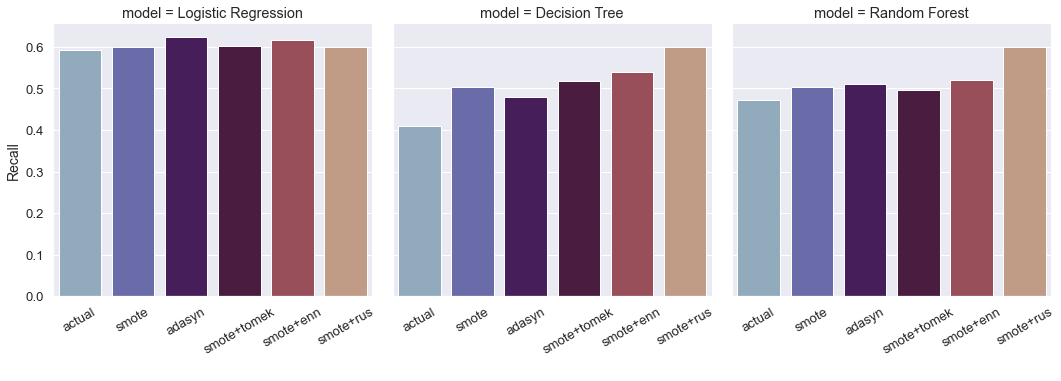

In [103]:
sns.set(font_scale=1.2)
#sns.palplot(sns.color_palette())
g = sns.FacetGrid(clf_eval_df, col="model", height=5)
g.map(sns.barplot, "resample", "recall", palette='twilight', order=["actual", "smote", "adasyn", "smote+tomek", "smote+enn","smote+rus"])
g.set_xticklabels(rotation=30)
g.set_xlabels(' ', fontsize=14)
g.set_ylabels('Recall', fontsize=14)

In [101]:
#instead of facetgrid
g = sns.catplot(x="sex", y="total_bill",
                hue="smoker", col="time",
                data=tips, kind="bar",
                height=4, aspect=.7);


NameError: name 'tips' is not defined

In [ ]:

data = {'apple': 10, 'orange': 15, 'lemon': 5, 'lime': 20}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')


In [ ]:
ax = sns.countplot(x="gender", data=train,hue = 'target',
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 20))


In [ ]:
#Let's use pivot table to analyze it.
table = pd.pivot_table(train,index=['gender'],aggfunc={'target':np.sum})
table
#table.plot(kind='bar')

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_model=AdaBoostClassifier()

from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
svc=SVC(probability=True, kernel='linear')

dst = DecisionTreeClassifier()

ada_params={'n_estimators':[500,1000,2000],
             'learning_rate':[.001,0.01,.1],
             'base_estimator':[svc, dst]
           }

clf_ada=RandomizedSearchCV(ada_model,ada_params,cv=cv, scoring='roc_auc',n_jobs=1)

clf_ada.fit(X_train, y_train)
clf_ada.best_estimator_

In [ ]:
mlp
mlp_params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}